In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
import itertools

In [69]:
def load_data(filepath):
    df = pd.read_csv(filepath, index_col=0)
    return df

In [70]:
SIGNAL_CATEGORIES = {
    'ECG': ['HR_mean', 'HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV', 'LF', 'HF', 'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm'],
    'PPG': ['PPG_HR_mean','PPG_HR_std','PPG_RMSSD','PPG_SDNN','PPG_LF','PPG_HF','PPG_LF_HF','PPG_num_beats','PPG_RiseTime','PPG_DecayTime','PPG_PAV_mean','PPG_PAV_std','PPG_RI'],
    'EDA': ['EDA_mean','EDA_std','EDA_min','EDA_max','EDA_range','EDA_slope','scl_mean','scl_std','scr_mean','scr_std','corr_scl_t','scr_count','scr_amp','scr_sum','scr_area'],
    'RESP': ['Resp_mean','Resp_std','Resp_I_mean','Resp_I_std','Resp_E_mean','Resp_E_std','Resp_IE_ratio','Resp_range','Resp_insp_vol','Resp_rate','Resp_duration'],
}
random = 13577

# Modelos que requieren normalización
MODELS_NEED_SCALING = ["KNN", "LDA"]

In [71]:
def calculate_metrics(y_true, y_pred, stage):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    metrics_table = pd.DataFrame({
        "Métrica": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Valor": [accuracy, precision, recall, f1],
        "Etapa": stage
    })
    
    print(f"{stage} Metrics")
    print(metrics_table)
    return metrics_table

In [72]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    print(f"{title} - Confusion Matrix")
    print(conf_mat)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, cmap="Greens", xticklabels=set(y_true), yticklabels=set(y_true), fmt='g')
    plt.xlabel("Etiquetas predichas")
    plt.ylabel("Etiquetas verdaderas")
    plt.title(f'Matriz de confusión - {title}')
    plt.show()

In [73]:
def train_and_evaluate(X, y, model, param_grid, model_name, signal_name):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random, stratify=y)
    
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=16, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred, stage=f"{signal_name} - {model_name}")
    acc = metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0]
    
    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] Accuracy: {acc:.4f}')

    plot_confusion_matrix(y_test, y_pred, f'{signal_name} - {model_name}')

    print(classification_report(y_test, y_pred))

    return metrics


In [74]:
def train_and_evaluate_group(X, y, groups, model, param_grid, model_name, signal_name):
    group_kfold = GroupKFold(n_splits=5)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=group_kfold,
        n_jobs=16,
        verbose=1
    )
    grid_search.fit(X, y, groups=groups)  # Aquí pasamos los grupos (sujetos)

    best_model = grid_search.best_estimator_

    y_true, y_pred = [], []
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        best_model.fit(X_train, y_train)
        preds = best_model.predict(X_test)

        y_true.extend(y_test)
        y_pred.extend(preds)

    metrics = calculate_metrics(y_true, y_pred, stage=f"{signal_name} - {model_name}")
    acc = metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0]

    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] Accuracy: {acc:.4f}')

    plot_confusion_matrix(y_true, y_pred, f'{signal_name} - {model_name}')
    print(classification_report(y_true, y_pred))

    return metrics

In [75]:
def train_and_evaluate_loso(X, y, subjects, base_model, param_grid, model_name, signal_name):
    logo = LeaveOneGroupOut()
    y_true_all = []
    y_pred_all = []

    all_metrics = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}

    for train_idx, test_idx in logo.split(X, y, groups=subjects):
        y_train_fold = y[train_idx]
        class_counts = Counter(y_train_fold)
        print(f"Distribución de clases en el fold: {class_counts}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        train_subjects = subjects.iloc[train_idx]

        # Construir pipeline con StandardScaler y modelo
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('clf', base_model)
        ])

        # Ajustar nombres del grid search para el pipeline
        adjusted_param_grid = {f"clf__{k}": v for k, v in param_grid.items()}

        # Validación cruzada interna con LOGO
        inner_logo = LeaveOneGroupOut()
        inner_cv = inner_logo.split(X_train, y_train, groups=train_subjects)

        grid_search = GridSearchCV(pipeline, adjusted_param_grid, cv=inner_cv, n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        metrics = calculate_metrics(y_test, y_pred, stage=f"{signal_name} - {model_name} (LOSO Fold)")
        best_params = grid_search.best_params_
        print(f"Best params for {model_name} in {signal_name}: {best_params}")

        all_metrics["accuracy"].append(metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0])
        all_metrics["precision"].append(metrics.loc[metrics["Métrica"] == "Precision", "Valor"].values[0])
        all_metrics["recall"].append(metrics.loc[metrics["Métrica"] == "Recall", "Valor"].values[0])
        all_metrics["f1_score"].append(metrics.loc[metrics["Métrica"] == "F1 Score", "Valor"].values[0])

        plot_confusion_matrix(y_test, y_pred, f'{signal_name} - {model_name}')

    final_metrics = {
        "accuracy": np.mean(all_metrics["accuracy"]),
        "precision": np.mean(all_metrics["precision"]),
        "recall": np.mean(all_metrics["recall"]),
        "f1_score": np.mean(all_metrics["f1_score"])
    }

    print(f'[{signal_name} - {model_name}] Final Metrics:')
    print(pd.DataFrame(final_metrics, index=["Valor"]).T)

    folds = range(1, len(all_metrics["accuracy"]) + 1)
    plt.figure(figsize=(10, 6))

    plt.plot(folds, all_metrics["accuracy"], label="Accuracy", marker='o')
    plt.plot(folds, all_metrics["precision"], label="Precision", marker='x')
    plt.plot(folds, all_metrics["recall"], label="Recall", marker='s')
    plt.plot(folds, all_metrics["f1_score"], label="F1 Score", marker='^')

    plt.xlabel("Fold")
    plt.ylabel("Metric Value")
    plt.title(f"Metrics per Fold - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return final_metrics

In [76]:
models = {
    "DecisionTree": (
        DecisionTreeClassifier(class_weight='balanced', random_state=random),
        {"max_depth": [3, 5, 10, 15],
         "min_samples_split": [2, 5, 10], 
         "max_leaf_nodes": [10, 15, 20, 30, 40],
         "criterion": ["gini", "entropy"]}
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight='balanced', random_state=random),
        {"n_estimators": [100, 200, 300],
         "max_depth": [3, 5, 10, 20],
         "min_samples_split": [2, 5, 10, 20],
         "min_samples_leaf": [2, 4],
         "max_features": ['sqrt', 'log2']}
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=random),
        {"n_estimators": [50, 100, 200, 300], 
         "learning_rate": [0.01, 0.1, 0.5, 1], 
         "estimator": [
             DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
             DecisionTreeClassifier(max_depth=3, class_weight='balanced')
         ]}
    ),
    "LDA": (
        LinearDiscriminantAnalysis(),
        {"solver": ["svd"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
    )
}

results = {}


all_signals = list(SIGNAL_CATEGORIES.keys())
combinations = []
for r in range(2, len(all_signals) + 1):
    combinations.extend(itertools.combinations(all_signals, r))

In [77]:
file = r'features_30_075\features.csv'

df = load_data(file)
df = df.fillna(0)

In [78]:
df.columns

Index(['HR_mean', 'HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV', 'LF', 'HF',
       'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm', 'PPG_HR_mean',
       'PPG_HR_std', 'PPG_RMSSD', 'PPG_SDNN', 'PPG_LF', 'PPG_HF', 'PPG_LF_HF',
       'PPG_num_beats', 'PPG_RiseTime', 'PPG_DecayTime', 'PPG_PAV_mean',
       'PPG_PAV_std', 'PPG_RI', 'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max',
       'EDA_range', 'EDA_slope', 'scl_mean', 'scl_std', 'scr_mean', 'scr_std',
       'corr_scl_t', 'scr_count', 'scr_amp', 'scr_sum', 'scr_area',
       'Resp_mean', 'Resp_std', 'Resp_I_mean', 'Resp_I_std', 'Resp_E_mean',
       'Resp_E_std', 'Resp_IE_ratio', 'Resp_range', 'Resp_insp_vol',
       'Resp_rate', 'Resp_duration', 'subject', 'label'],
      dtype='object')

In [52]:
print("Valores nulos por columna:\n", df.isna().sum())

Valores nulos por columna:
 HR_mean          0
HR_std           0
NN50             0
pNN50            0
TINN             0
rmsHRV           0
LF               0
HF               0
LF_HF            0
sum_f            0
rel_f            0
LF_norm          0
HF_norm          0
PPG_HR_mean      0
PPG_HR_std       0
PPG_RMSSD        0
PPG_SDNN         0
PPG_LF           0
PPG_HF           0
PPG_LF_HF        0
PPG_num_beats    0
PPG_RiseTime     0
PPG_DecayTime    0
PPG_PAV_mean     0
PPG_PAV_std      0
PPG_RI           0
EDA_mean         0
EDA_std          0
EDA_min          0
EDA_max          0
EDA_range        0
EDA_slope        0
scl_mean         0
scl_std          0
scr_mean         0
scr_std          0
corr_scl_t       0
scr_count        0
scr_amp          0
scr_sum          0
scr_area         0
Resp_mean        0
Resp_std         0
Resp_I_mean      0
Resp_I_std       0
Resp_E_mean      0
Resp_E_std       0
Resp_IE_ratio    0
Resp_range       0
Resp_insp_vol    0
Resp_rate        0
Res

In [79]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 21943
Label: 2 total: 8973
Label: 3 total: 21939
Label: 4 total: 13869


In [80]:
#Aplicar muestra binaria
df['label'] = df['label'].apply(lambda x: 1 if x in [1, 2] else 2)

In [81]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 30916
Label: 2 total: 35808


Training by signal:   0%|          | 0/4 [00:00<?, ?it/s]

Training DecisionTree model for ECG using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
ECG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.661072  ECG - DecisionTree
1  Precision  0.668560  ECG - DecisionTree
2     Recall  0.661072  ECG - DecisionTree
3   F1 Score  0.661014  ECG - DecisionTree
[ECG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[ECG - DecisionTree] Accuracy: 0.6611
ECG - DecisionTree - Confusion Matrix
[[4426 1757]
 [2766 4396]]


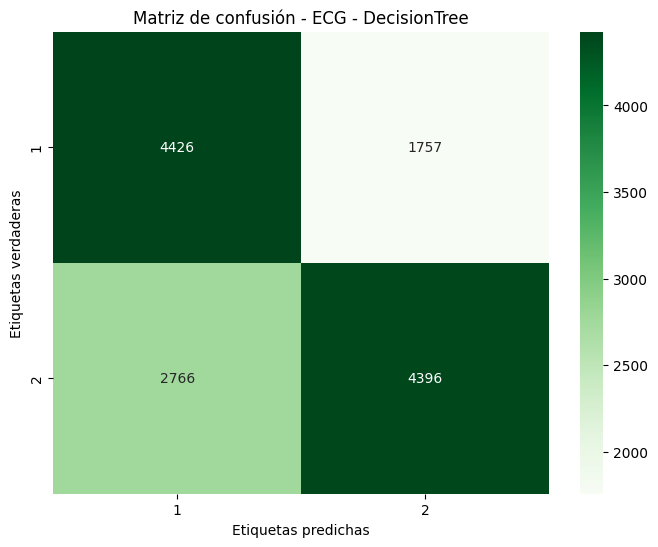

              precision    recall  f1-score   support

           1       0.62      0.72      0.66      6183
           2       0.71      0.61      0.66      7162

    accuracy                           0.66     13345
   macro avg       0.66      0.66      0.66     13345
weighted avg       0.67      0.66      0.66     13345

Training RandomForest model for ECG using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
ECG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.911802  ECG - RandomForest
1  Precision  0.912043  ECG - RandomForest
2     Recall  0.911802  ECG - RandomForest
3   F1 Score  0.911852  ECG - RandomForest
[ECG - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[ECG - RandomForest] Accuracy: 0.9118
ECG - RandomForest - Confusion Matrix
[[5653  530]
 [ 647 6515]]


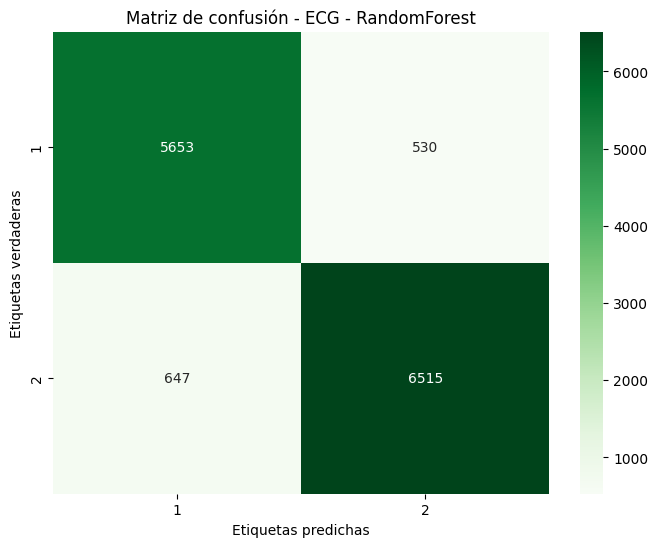

              precision    recall  f1-score   support

           1       0.90      0.91      0.91      6183
           2       0.92      0.91      0.92      7162

    accuracy                           0.91     13345
   macro avg       0.91      0.91      0.91     13345
weighted avg       0.91      0.91      0.91     13345

Training AdaBoost model for ECG using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ECG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.794005  ECG - AdaBoost
1  Precision  0.795519  ECG - AdaBoost
2     Recall  0.794005  ECG - AdaBoost
3   F1 Score  0.794256  ECG - AdaBoost
[ECG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[ECG - AdaBoost] Accuracy: 0.7940
ECG - AdaBoost - Confusion Matrix
[[4977 1206]
 [1543 5619]]


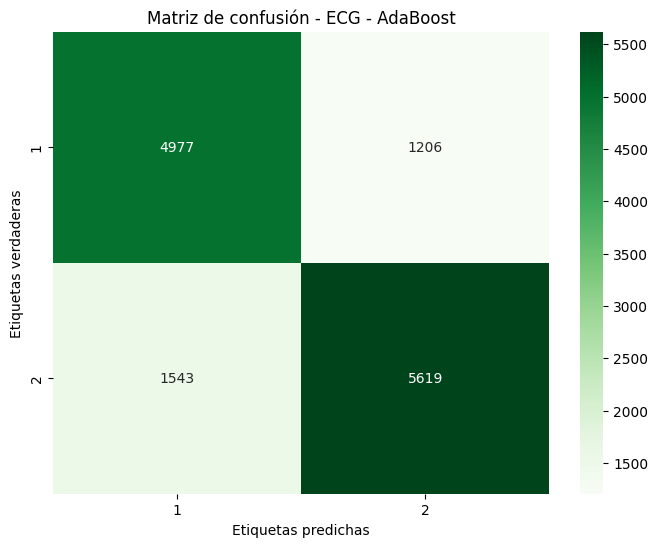

              precision    recall  f1-score   support

           1       0.76      0.80      0.78      6183
           2       0.82      0.78      0.80      7162

    accuracy                           0.79     13345
   macro avg       0.79      0.79      0.79     13345
weighted avg       0.80      0.79      0.79     13345

Training LDA model for ECG using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ECG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.605920  ECG - LDA
1  Precision  0.604834  ECG - LDA
2     Recall  0.605920  ECG - LDA
3   F1 Score  0.605081  ECG - LDA
[ECG - LDA] Best Params: {'solver': 'svd'}
[ECG - LDA] Accuracy: 0.6059
ECG - LDA - Confusion Matrix
[[3406 2777]
 [2482 4680]]


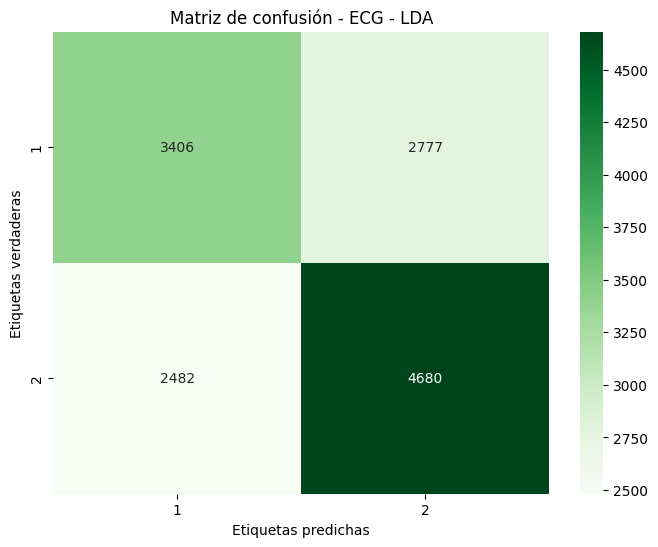

              precision    recall  f1-score   support

           1       0.58      0.55      0.56      6183
           2       0.63      0.65      0.64      7162

    accuracy                           0.61     13345
   macro avg       0.60      0.60      0.60     13345
weighted avg       0.60      0.61      0.61     13345

Training KNN model for ECG using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ECG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.714125  ECG - KNN
1  Precision  0.714091  ECG - KNN
2     Recall  0.714125  ECG - KNN
3   F1 Score  0.714108  ECG - KNN
[ECG - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[ECG - KNN] Accuracy: 0.7141
ECG - KNN - Confusion Matrix
[[4270 1913]
 [1902 5260]]


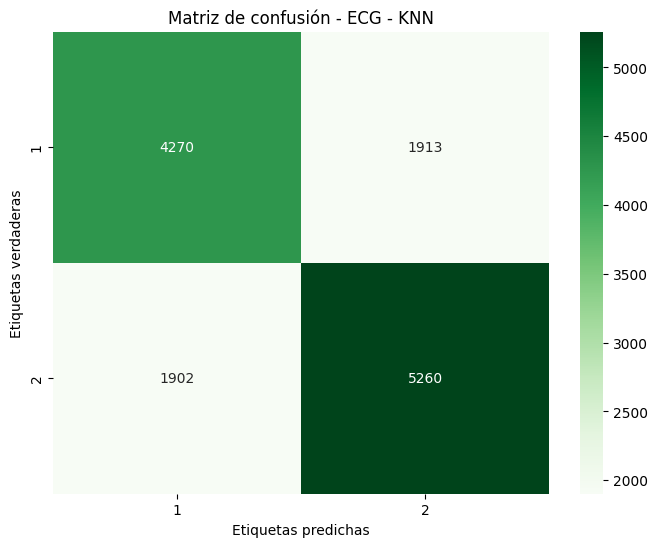

Training by signal:  25%|██▌       | 1/4 [1:07:06<3:21:18, 4026.07s/it]

              precision    recall  f1-score   support

           1       0.69      0.69      0.69      6183
           2       0.73      0.73      0.73      7162

    accuracy                           0.71     13345
   macro avg       0.71      0.71      0.71     13345
weighted avg       0.71      0.71      0.71     13345

Training DecisionTree model for PPG using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
PPG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.828625  PPG - DecisionTree
1  Precision  0.828504  PPG - DecisionTree
2     Recall  0.828625  PPG - DecisionTree
3   F1 Score  0.828477  PPG - DecisionTree
[PPG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[PPG - DecisionTree] Accuracy: 0.8286
PPG - DecisionTree - Confusion Matrix
[[4971 1212]
 [1075 6087]]


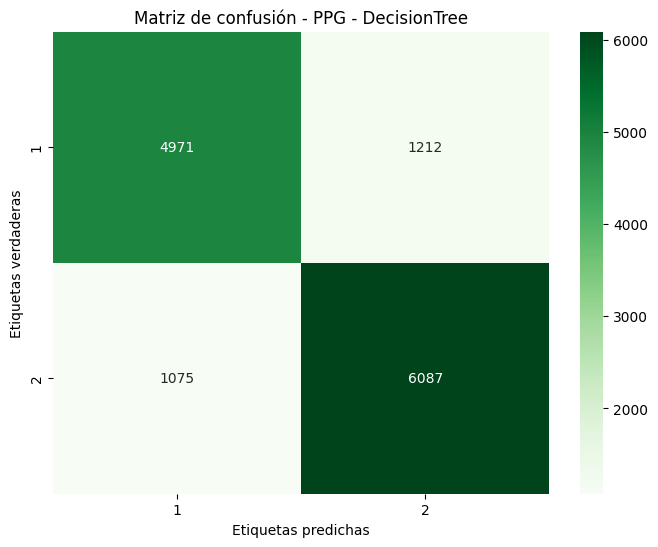

              precision    recall  f1-score   support

           1       0.82      0.80      0.81      6183
           2       0.83      0.85      0.84      7162

    accuracy                           0.83     13345
   macro avg       0.83      0.83      0.83     13345
weighted avg       0.83      0.83      0.83     13345

Training RandomForest model for PPG using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
PPG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.989659  PPG - RandomForest
1  Precision  0.989659  PPG - RandomForest
2     Recall  0.989659  PPG - RandomForest
3   F1 Score  0.989659  PPG - RandomForest
[PPG - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[PPG - RandomForest] Accuracy: 0.9897
PPG - RandomForest - Confusion Matrix
[[6111   72]
 [  66 7096]]


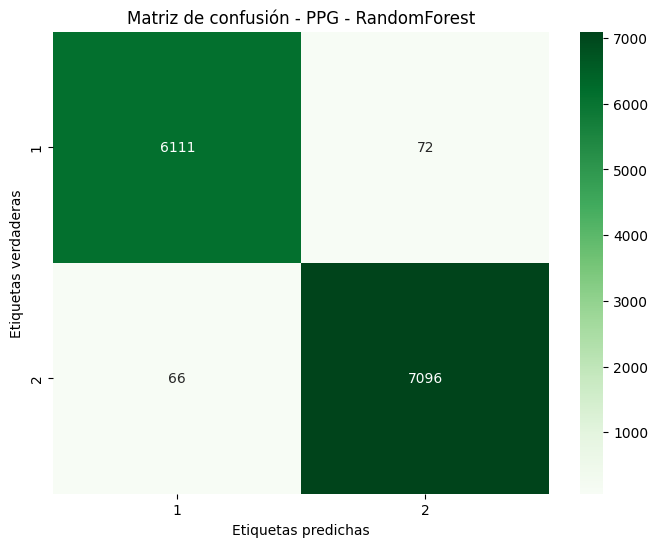

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      6183
           2       0.99      0.99      0.99      7162

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training AdaBoost model for PPG using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
PPG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.970326  PPG - AdaBoost
1  Precision  0.970328  PPG - AdaBoost
2     Recall  0.970326  PPG - AdaBoost
3   F1 Score  0.970327  PPG - AdaBoost
[PPG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[PPG - AdaBoost] Accuracy: 0.9703
PPG - AdaBoost - Confusion Matrix
[[5988  195]
 [ 201 6961]]


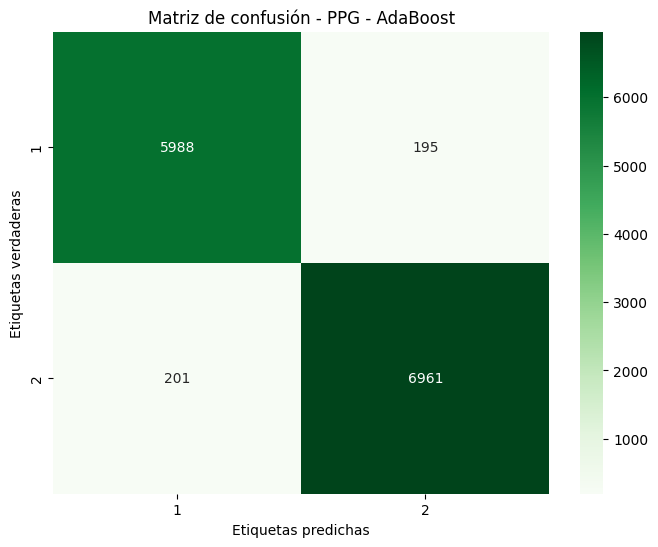

              precision    recall  f1-score   support

           1       0.97      0.97      0.97      6183
           2       0.97      0.97      0.97      7162

    accuracy                           0.97     13345
   macro avg       0.97      0.97      0.97     13345
weighted avg       0.97      0.97      0.97     13345

Training LDA model for PPG using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
PPG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.774223  PPG - LDA
1  Precision  0.777260  PPG - LDA
2     Recall  0.774223  PPG - LDA
3   F1 Score  0.771973  PPG - LDA
[PPG - LDA] Best Params: {'solver': 'svd'}
[PPG - LDA] Accuracy: 0.7742
PPG - LDA - Confusion Matrix
[[4218 1965]
 [1048 6114]]


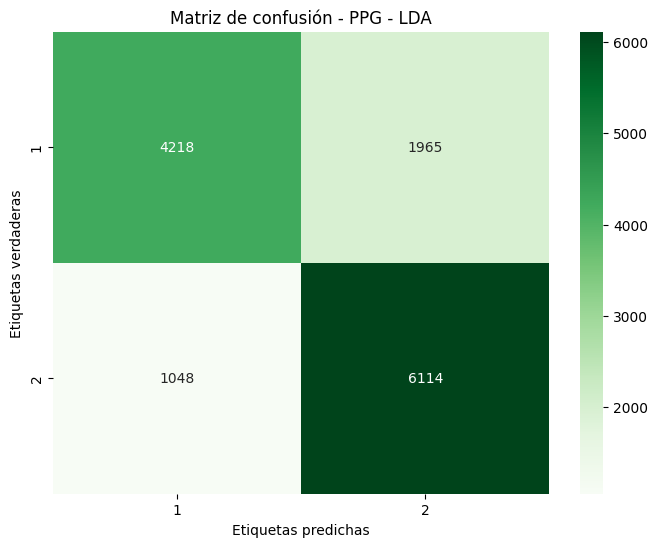

              precision    recall  f1-score   support

           1       0.80      0.68      0.74      6183
           2       0.76      0.85      0.80      7162

    accuracy                           0.77     13345
   macro avg       0.78      0.77      0.77     13345
weighted avg       0.78      0.77      0.77     13345

Training KNN model for PPG using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
PPG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.912102  PPG - KNN
1  Precision  0.912078  PPG - KNN
2     Recall  0.912102  PPG - KNN
3   F1 Score  0.912069  PPG - KNN
[PPG - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[PPG - KNN] Accuracy: 0.9121
PPG - KNN - Confusion Matrix
[[5565  618]
 [ 555 6607]]


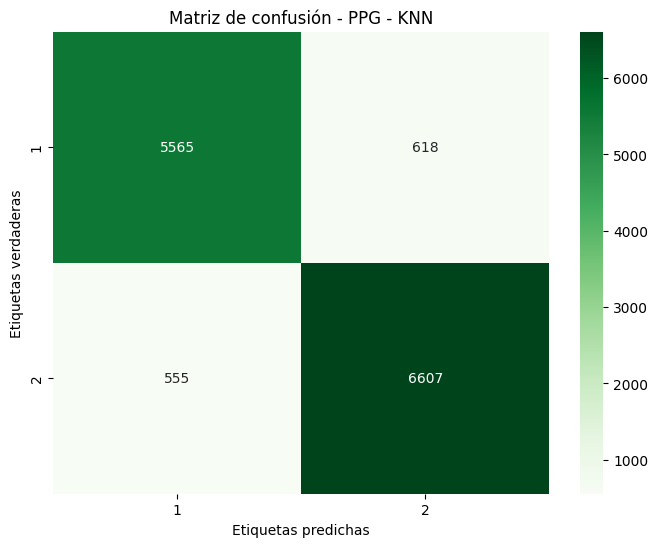

Training by signal:  50%|█████     | 2/4 [2:13:37<2:13:31, 4005.73s/it]

              precision    recall  f1-score   support

           1       0.91      0.90      0.90      6183
           2       0.91      0.92      0.92      7162

    accuracy                           0.91     13345
   macro avg       0.91      0.91      0.91     13345
weighted avg       0.91      0.91      0.91     13345

Training DecisionTree model for EDA using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
EDA - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.780817  EDA - DecisionTree
1  Precision  0.784254  EDA - DecisionTree
2     Recall  0.780817  EDA - DecisionTree
3   F1 Score  0.778561  EDA - DecisionTree
[EDA - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[EDA - DecisionTree] Accuracy: 0.7808
EDA - DecisionTree - Confusion Matrix
[[4252 1931]
 [ 994 6168]]


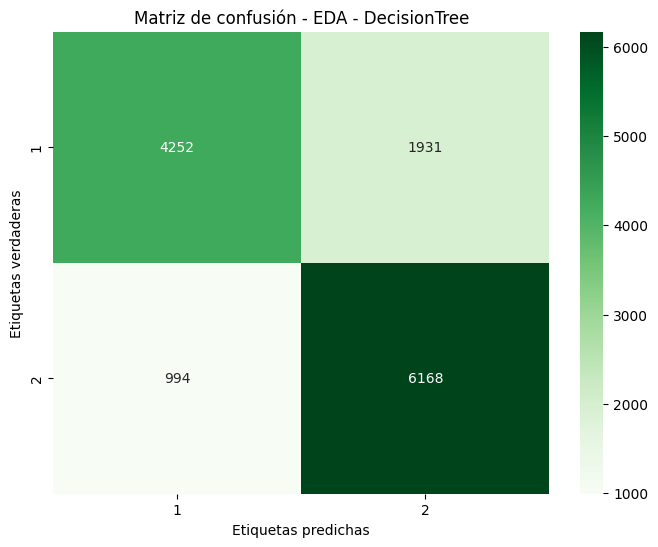

              precision    recall  f1-score   support

           1       0.81      0.69      0.74      6183
           2       0.76      0.86      0.81      7162

    accuracy                           0.78     13345
   macro avg       0.79      0.77      0.78     13345
weighted avg       0.78      0.78      0.78     13345

Training RandomForest model for EDA using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
EDA - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.983065  EDA - RandomForest
1  Precision  0.983111  EDA - RandomForest
2     Recall  0.983065  EDA - RandomForest
3   F1 Score  0.983057  EDA - RandomForest
[EDA - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
[EDA - RandomForest] Accuracy: 0.9831
EDA - RandomForest - Confusion Matrix
[[6033  150]
 [  76 7086]]


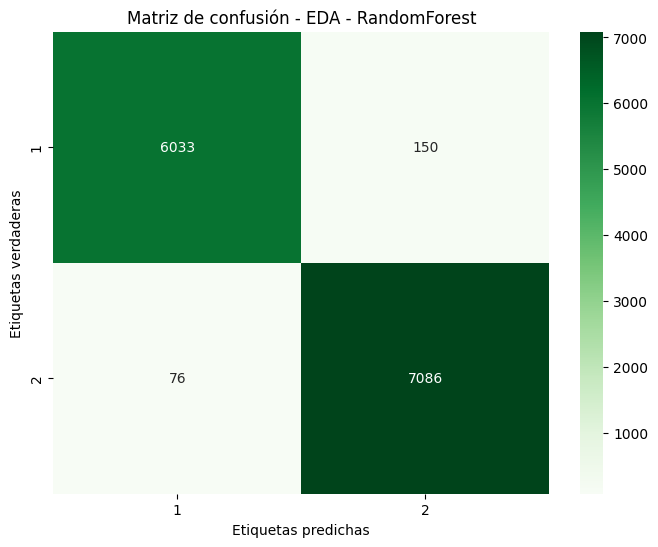

              precision    recall  f1-score   support

           1       0.99      0.98      0.98      6183
           2       0.98      0.99      0.98      7162

    accuracy                           0.98     13345
   macro avg       0.98      0.98      0.98     13345
weighted avg       0.98      0.98      0.98     13345

Training AdaBoost model for EDA using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
EDA - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.964706  EDA - AdaBoost
1  Precision  0.964718  EDA - AdaBoost
2     Recall  0.964706  EDA - AdaBoost
3   F1 Score  0.964694  EDA - AdaBoost
[EDA - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[EDA - AdaBoost] Accuracy: 0.9647
EDA - AdaBoost - Confusion Matrix
[[5919  264]
 [ 207 6955]]


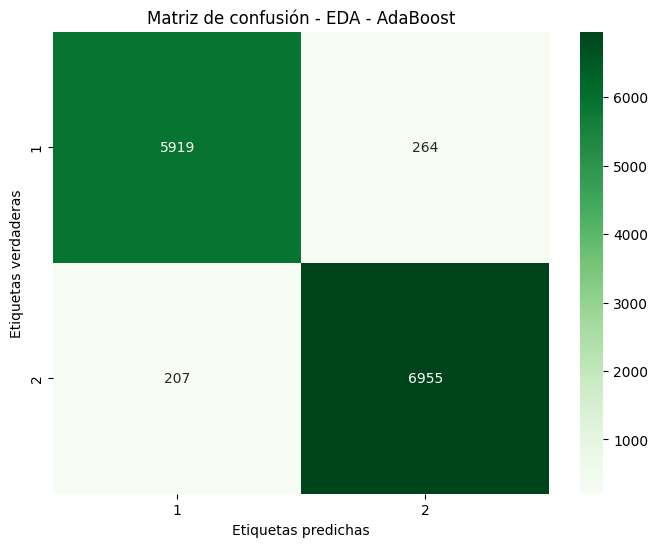

              precision    recall  f1-score   support

           1       0.97      0.96      0.96      6183
           2       0.96      0.97      0.97      7162

    accuracy                           0.96     13345
   macro avg       0.96      0.96      0.96     13345
weighted avg       0.96      0.96      0.96     13345

Training LDA model for EDA using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
EDA - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.607493  EDA - LDA
1  Precision  0.612871  EDA - LDA
2     Recall  0.607493  EDA - LDA
3   F1 Score  0.607745  EDA - LDA
[EDA - LDA] Best Params: {'solver': 'svd'}
[EDA - LDA] Accuracy: 0.6075
EDA - LDA - Confusion Matrix
[[3986 2197]
 [3041 4121]]


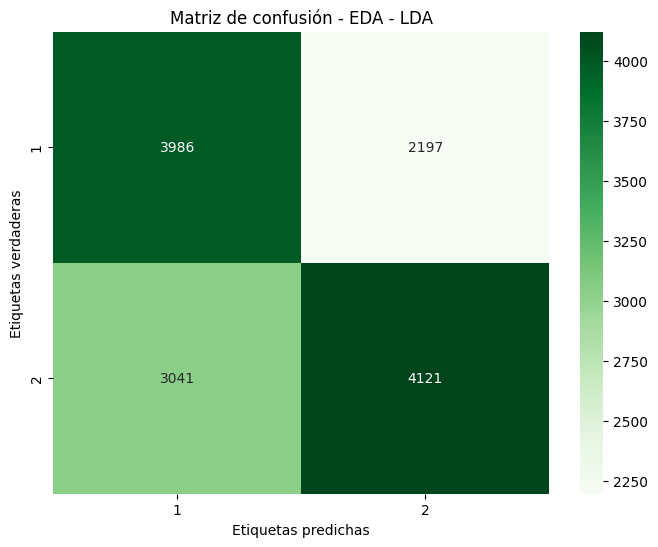

              precision    recall  f1-score   support

           1       0.57      0.64      0.60      6183
           2       0.65      0.58      0.61      7162

    accuracy                           0.61     13345
   macro avg       0.61      0.61      0.61     13345
weighted avg       0.61      0.61      0.61     13345

Training KNN model for EDA using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
EDA - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.941851  EDA - KNN
1  Precision  0.941867  EDA - KNN
2     Recall  0.941851  EDA - KNN
3   F1 Score  0.941822  EDA - KNN
[EDA - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[EDA - KNN] Accuracy: 0.9419
EDA - KNN - Confusion Matrix
[[5753  430]
 [ 346 6816]]


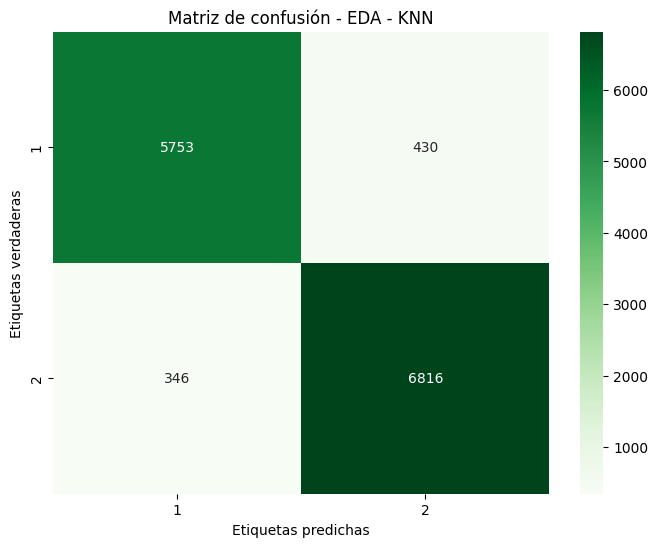

Training by signal:  75%|███████▌  | 3/4 [3:06:26<1:00:23, 3623.63s/it]

              precision    recall  f1-score   support

           1       0.94      0.93      0.94      6183
           2       0.94      0.95      0.95      7162

    accuracy                           0.94     13345
   macro avg       0.94      0.94      0.94     13345
weighted avg       0.94      0.94      0.94     13345

Training DecisionTree model for RESP using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
RESP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.713076  RESP - DecisionTree
1  Precision  0.713410  RESP - DecisionTree
2     Recall  0.713076  RESP - DecisionTree
3   F1 Score  0.710955  RESP - DecisionTree
[RESP - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[RESP - DecisionTree] Accuracy: 0.7131
RESP - DecisionTree - Confusion Matrix
[[3894 2289]
 [1540 5622]]


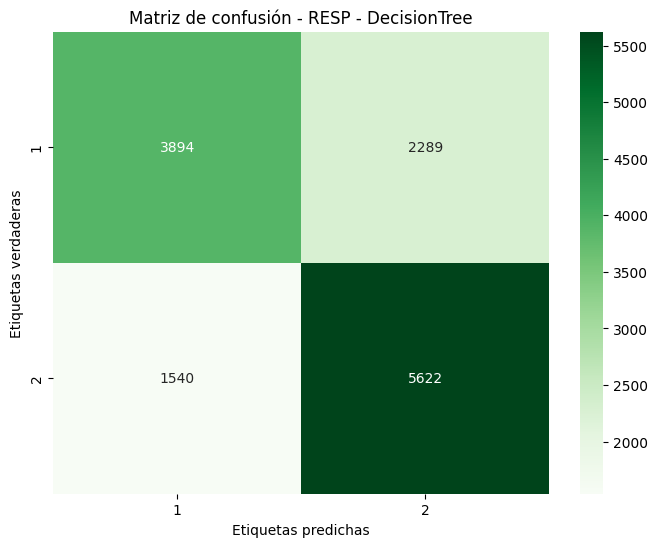

              precision    recall  f1-score   support

           1       0.72      0.63      0.67      6183
           2       0.71      0.78      0.75      7162

    accuracy                           0.71     13345
   macro avg       0.71      0.71      0.71     13345
weighted avg       0.71      0.71      0.71     13345

Training RandomForest model for RESP using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
RESP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.972424  RESP - RandomForest
1  Precision  0.972429  RESP - RandomForest
2     Recall  0.972424  RESP - RandomForest
3   F1 Score  0.972426  RESP - RandomForest
[RESP - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[RESP - RandomForest] Accuracy: 0.9724
RESP - RandomForest - Confusion Matrix
[[6005  178]
 [ 190 6972]]


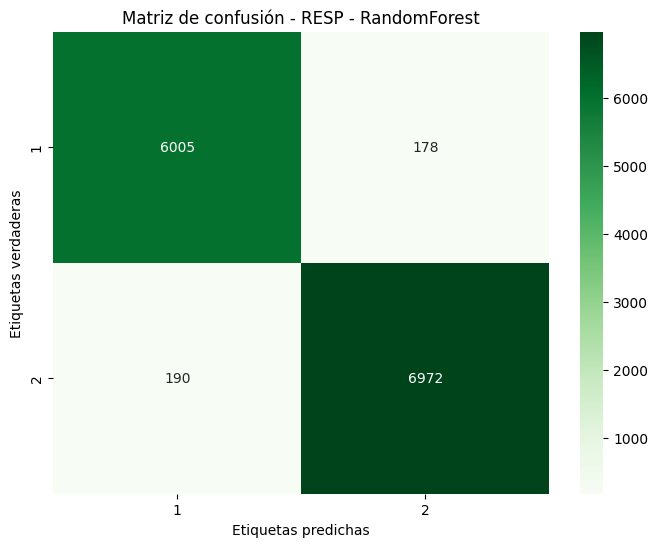

              precision    recall  f1-score   support

           1       0.97      0.97      0.97      6183
           2       0.98      0.97      0.97      7162

    accuracy                           0.97     13345
   macro avg       0.97      0.97      0.97     13345
weighted avg       0.97      0.97      0.97     13345

Training AdaBoost model for RESP using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
RESP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.883702  RESP - AdaBoost
1  Precision  0.884303  RESP - AdaBoost
2     Recall  0.883702  RESP - AdaBoost
3   F1 Score  0.883804  RESP - AdaBoost
[RESP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[RESP - AdaBoost] Accuracy: 0.8837
RESP - AdaBoost - Confusion Matrix
[[5507  676]
 [ 876 6286]]


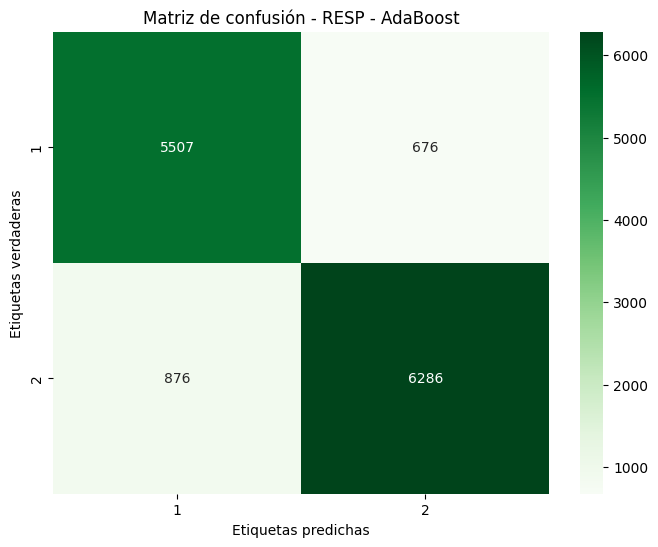

              precision    recall  f1-score   support

           1       0.86      0.89      0.88      6183
           2       0.90      0.88      0.89      7162

    accuracy                           0.88     13345
   macro avg       0.88      0.88      0.88     13345
weighted avg       0.88      0.88      0.88     13345

Training LDA model for RESP using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
RESP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.627951  RESP - LDA
1  Precision  0.626607  RESP - LDA
2     Recall  0.627951  RESP - LDA
3   F1 Score  0.623984  RESP - LDA
[RESP - LDA] Best Params: {'solver': 'svd'}
[RESP - LDA] Accuracy: 0.6280
RESP - LDA - Confusion Matrix
[[3221 2962]
 [2003 5159]]


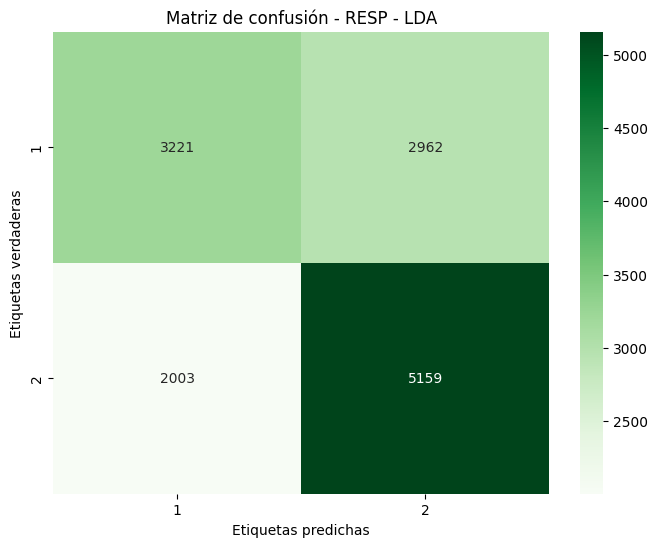

              precision    recall  f1-score   support

           1       0.62      0.52      0.56      6183
           2       0.64      0.72      0.68      7162

    accuracy                           0.63     13345
   macro avg       0.63      0.62      0.62     13345
weighted avg       0.63      0.63      0.62     13345

Training KNN model for RESP using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
RESP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.976695  RESP - KNN
1  Precision  0.976726  RESP - KNN
2     Recall  0.976695  RESP - KNN
3   F1 Score  0.976701  RESP - KNN
[RESP - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[RESP - KNN] Accuracy: 0.9767
RESP - KNN - Confusion Matrix
[[6049  134]
 [ 177 6985]]


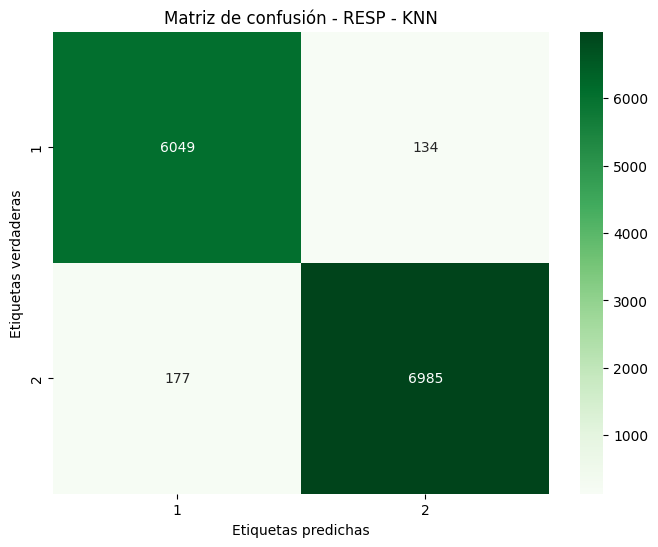

Training by signal: 100%|██████████| 4/4 [3:57:16<00:00, 3559.17s/it]  


              precision    recall  f1-score   support

           1       0.97      0.98      0.97      6183
           2       0.98      0.98      0.98      7162

    accuracy                           0.98     13345
   macro avg       0.98      0.98      0.98     13345
weighted avg       0.98      0.98      0.98     13345



Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.900862  ALL - DecisionTree
1  Precision  0.901059  ALL - DecisionTree
2     Recall  0.900862  ALL - DecisionTree
3   F1 Score  0.900910  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[ALL - DecisionTree] Accuracy: 0.9009
ALL - DecisionTree - Confusion Matrix
[[5571  612]
 [ 711 6451]]


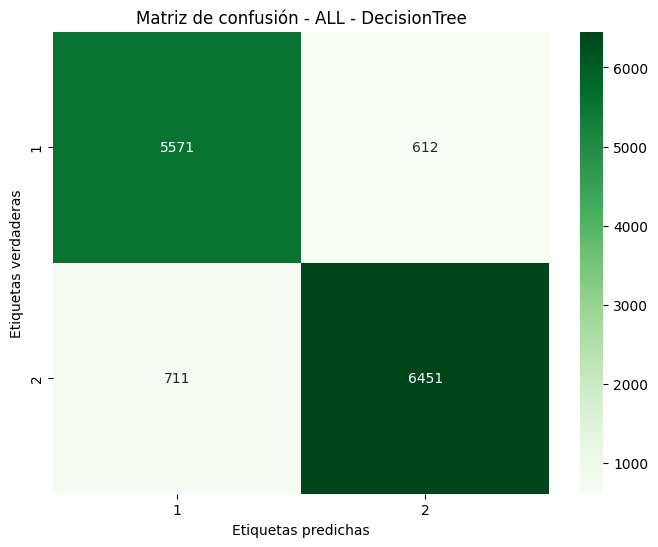

Training with ALL signals:  20%|██        | 1/5 [02:18<09:15, 138.77s/it]

              precision    recall  f1-score   support

           1       0.89      0.90      0.89      6183
           2       0.91      0.90      0.91      7162

    accuracy                           0.90     13345
   macro avg       0.90      0.90      0.90     13345
weighted avg       0.90      0.90      0.90     13345

Training RandomForest model for ALL signals using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
ALL - RandomForest Metrics
     Métrica    Valor               Etapa
0   Accuracy  0.99985  ALL - RandomForest
1  Precision  0.99985  ALL - RandomForest
2     Recall  0.99985  ALL - RandomForest
3   F1 Score  0.99985  ALL - RandomForest
[ALL - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
[ALL - RandomForest] Accuracy: 0.9999
ALL - RandomForest - Confusion Matrix
[[6182    1]
 [   1 7161]]


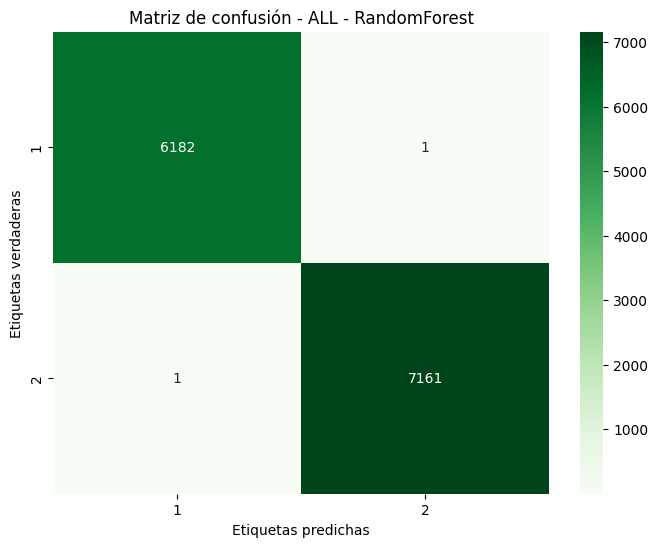

Training with ALL signals:  40%|████      | 2/5 [1:26:51<2:32:02, 3040.94s/it]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ALL signals using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ALL - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.999625  ALL - AdaBoost
1  Precision  0.999625  ALL - AdaBoost
2     Recall  0.999625  ALL - AdaBoost
3   F1 Score  0.999625  ALL - AdaBoost
[ALL - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[ALL - AdaBoost] Accuracy: 0.9996
ALL - AdaBoost - Confusion Matrix
[[6180    3]
 [   2 7160]]


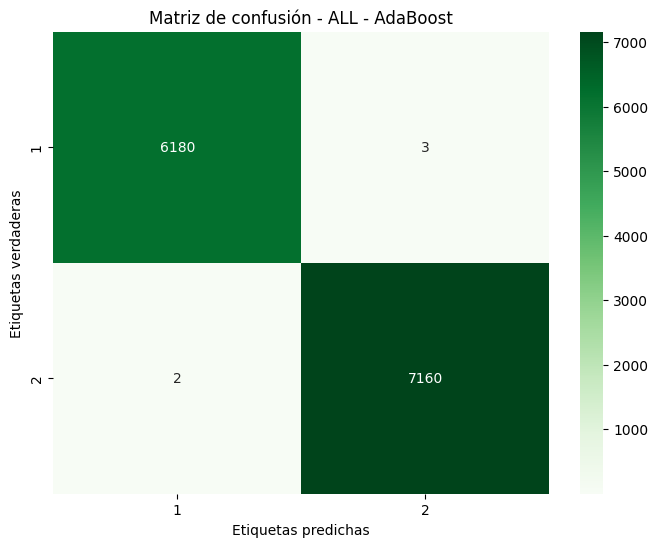

Training with ALL signals:  60%|██████    | 3/5 [2:16:07<1:40:04, 3002.43s/it]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training LDA model for ALL signals using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ALL - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.822630  ALL - LDA
1  Precision  0.824046  ALL - LDA
2     Recall  0.822630  ALL - LDA
3   F1 Score  0.821693  ALL - LDA
[ALL - LDA] Best Params: {'solver': 'svd'}
[ALL - LDA] Accuracy: 0.8226
ALL - LDA - Confusion Matrix
[[4704 1479]
 [ 888 6274]]


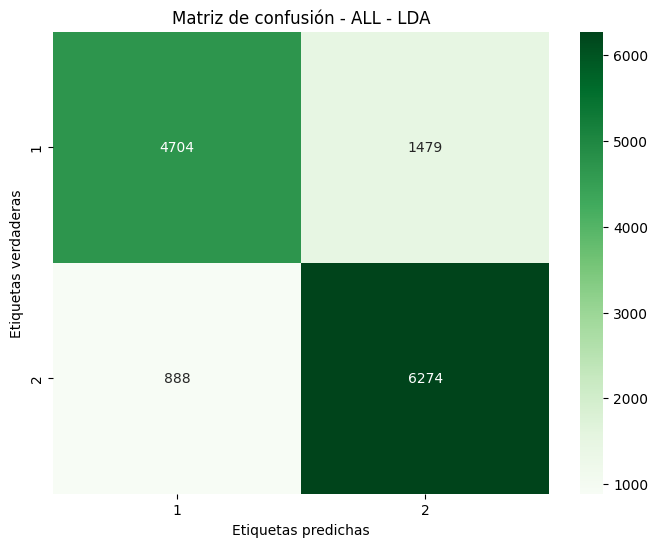

Training with ALL signals:  80%|████████  | 4/5 [2:16:12<30:18, 1818.79s/it]  

              precision    recall  f1-score   support

           1       0.84      0.76      0.80      6183
           2       0.81      0.88      0.84      7162

    accuracy                           0.82     13345
   macro avg       0.83      0.82      0.82     13345
weighted avg       0.82      0.82      0.82     13345

Training KNN model for ALL signals using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ALL - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.735481  ALL - KNN
1  Precision  0.735458  ALL - KNN
2     Recall  0.735481  ALL - KNN
3   F1 Score  0.735470  ALL - KNN
[ALL - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[ALL - KNN] Accuracy: 0.7355
ALL - KNN - Confusion Matrix
[[4414 1769]
 [1761 5401]]


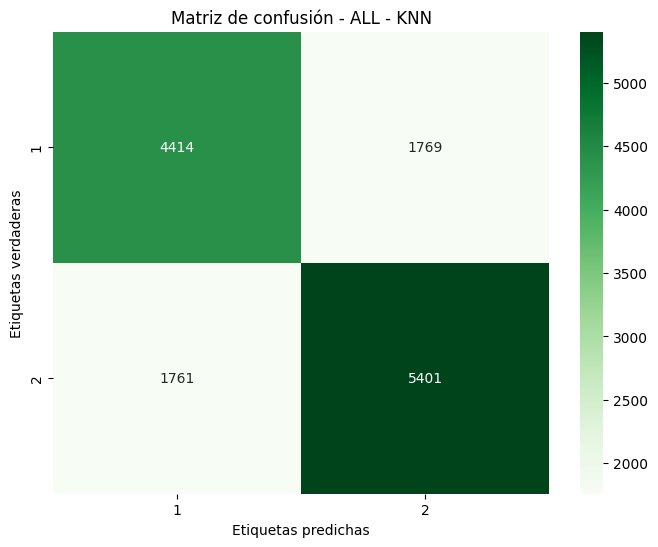

Training with ALL signals: 100%|██████████| 5/5 [2:16:23<00:00, 1636.71s/it]

              precision    recall  f1-score   support

           1       0.71      0.71      0.71      6183
           2       0.75      0.75      0.75      7162

    accuracy                           0.74     13345
   macro avg       0.73      0.73      0.73     13345
weighted avg       0.74      0.74      0.74     13345


Final Comparison:
ECG - DecisionTree:
     Métrica     Valor               Etapa
0   Accuracy  0.661072  ECG - DecisionTree
1  Precision  0.668560  ECG - DecisionTree
2     Recall  0.661072  ECG - DecisionTree
3   F1 Score  0.661014  ECG - DecisionTree
ECG - RandomForest:
     Métrica     Valor               Etapa
0   Accuracy  0.911802  ECG - RandomForest
1  Precision  0.912043  ECG - RandomForest
2     Recall  0.911802  ECG - RandomForest
3   F1 Score  0.911852  ECG - RandomForest
ECG - AdaBoost:
     Métrica     Valor           Etapa
0   Accuracy  0.794005  ECG - AdaBoost
1  Precision  0.795519  ECG - AdaBoost
2     Recall  0.794005  ECG - AdaBoost
3   F1 Score

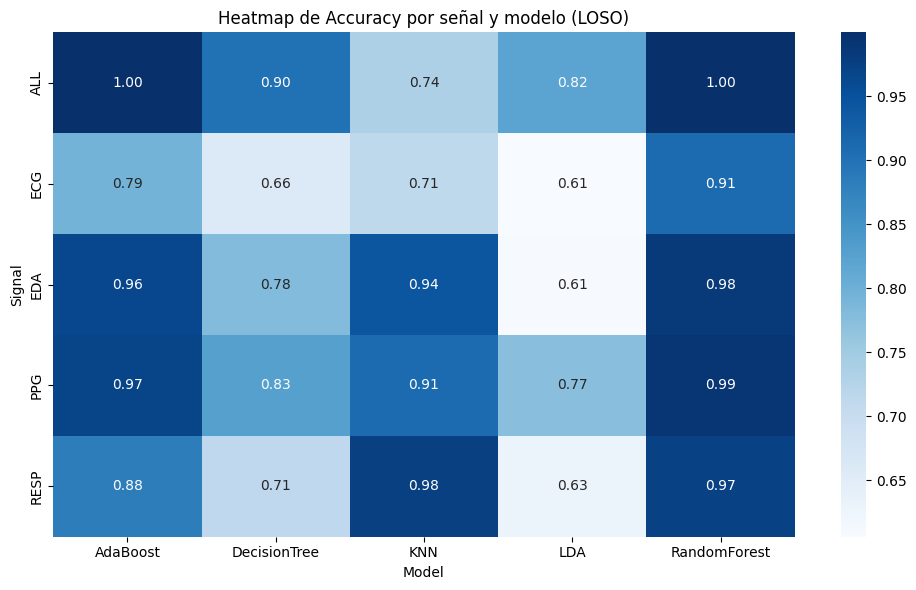

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_15152\2680508847.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xti

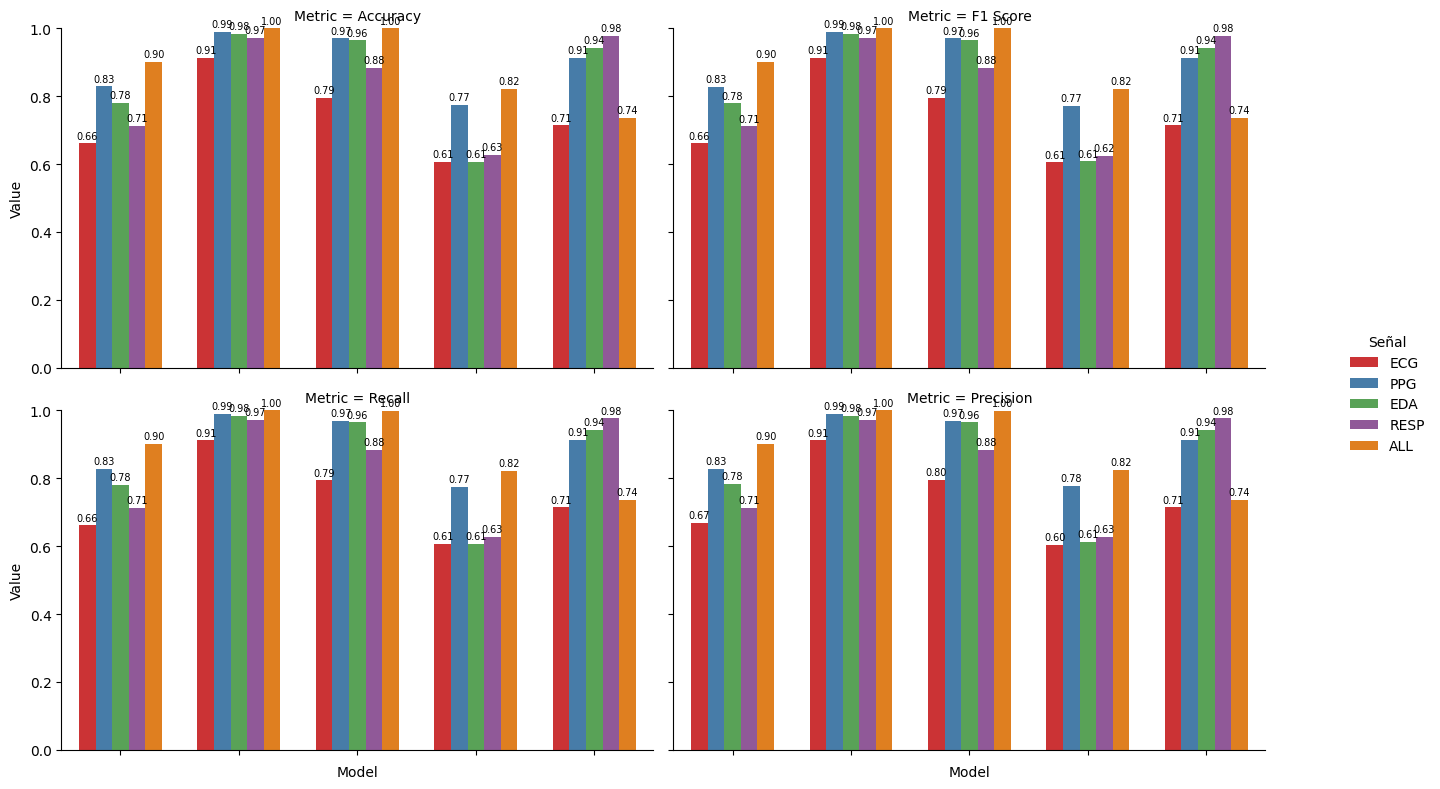

In [36]:
# Entrenamiento por cada tipo de señal
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features]
        y = df['label']
        subjects = df['subject']  # Se agrega el identificador de sujetos para LOSO

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal} using LOSO...')
            metrics = train_and_evaluate(X, y, model, param_grid, model_name, signal)
            
            # Convertir diccionario de métricas a DataFrame con mismo formato que antes
            results[(signal, model_name)] = metrics.copy()

# Entrenamiento con todas las señales combinadas
X_all = df.drop(columns=['label', 'subject'])  # También se excluye 'subject'
y_all = df['label']
subjects_all = df['subject']

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOSO...')
    metrics = train_and_evaluate(X_all, y_all, model, param_grid, model_name, "ALL")

    results[("ALL", model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (signal, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo (LOSO)')
plt.tight_layout()
plt.show()


data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (signal, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((signal, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)  # <-- aquí el width más pequeño

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

Training by signal combinations:   0%|          | 0/11 [00:00<?, ?it/s]

Training DecisionTree model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG') - DecisionTree Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.838291  ('ECG', 'PPG') - DecisionTree
1  Precision  0.838422  ('ECG', 'PPG') - DecisionTree
2     Recall  0.838291  ('ECG', 'PPG') - DecisionTree
3   F1 Score  0.837951  ('ECG', 'PPG') - DecisionTree
[('ECG', 'PPG') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('ECG', 'PPG') - DecisionTree] Accuracy: 0.8383
('ECG', 'PPG') - DecisionTree - Confusion Matrix
[[4958 1225]
 [ 933 6229]]


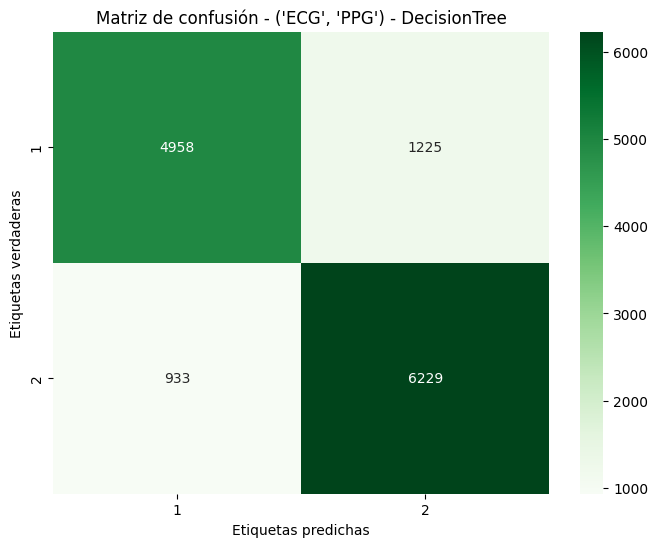

              precision    recall  f1-score   support

           1       0.84      0.80      0.82      6183
           2       0.84      0.87      0.85      7162

    accuracy                           0.84     13345
   macro avg       0.84      0.84      0.84     13345
weighted avg       0.84      0.84      0.84     13345

Training RandomForest model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG') - RandomForest Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.993855  ('ECG', 'PPG') - RandomForest
1  Precision  0.993857  ('ECG', 'PPG') - RandomForest
2     Recall  0.993855  ('ECG', 'PPG') - RandomForest
3   F1 Score  0.993856  ('ECG', 'PPG') - RandomForest
[('ECG', 'PPG') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[('ECG', 'PPG') - RandomForest] Accuracy: 0.9939
('ECG', 'PPG') - RandomForest - Confu

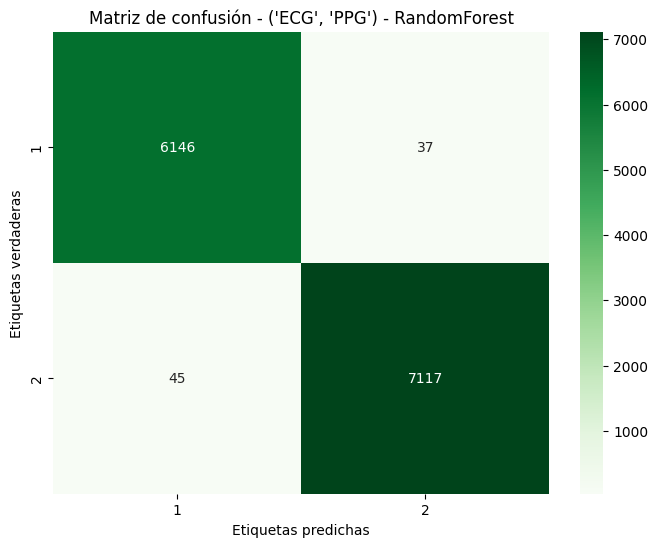

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      6183
           2       0.99      0.99      0.99      7162

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training AdaBoost model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG') - AdaBoost Metrics
     Métrica     Valor                      Etapa
0   Accuracy  0.982241  ('ECG', 'PPG') - AdaBoost
1  Precision  0.982241  ('ECG', 'PPG') - AdaBoost
2     Recall  0.982241  ('ECG', 'PPG') - AdaBoost
3   F1 Score  0.982241  ('ECG', 'PPG') - AdaBoost
[('ECG', 'PPG') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('ECG', 'PPG') - AdaBoost] Accuracy: 0.9822
('ECG', 'PPG') - AdaBoost - Confusion Matrix
[[6065  118]
 [ 119 70

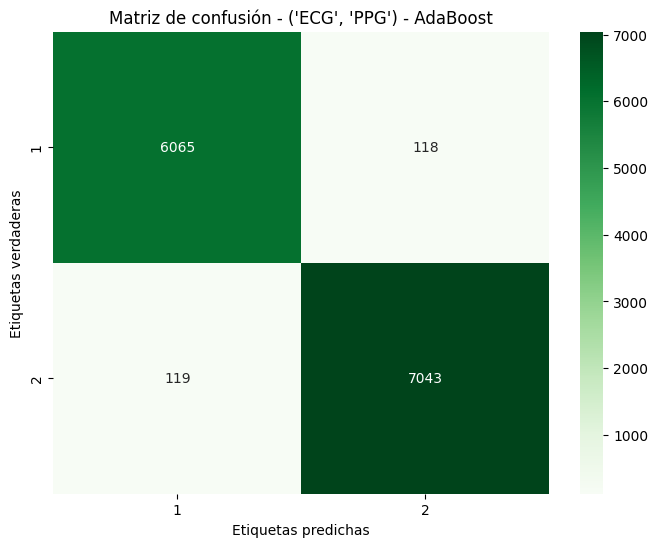

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      6183
           2       0.98      0.98      0.98      7162

    accuracy                           0.98     13345
   macro avg       0.98      0.98      0.98     13345
weighted avg       0.98      0.98      0.98     13345

Training LDA model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG') - LDA Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.782540  ('ECG', 'PPG') - LDA
1  Precision  0.785684  ('ECG', 'PPG') - LDA
2     Recall  0.782540  ('ECG', 'PPG') - LDA
3   F1 Score  0.780427  ('ECG', 'PPG') - LDA
[('ECG', 'PPG') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG') - LDA] Accuracy: 0.7825
('ECG', 'PPG') - LDA - Confusion Matrix
[[4281 1902]
 [1000 6162]]


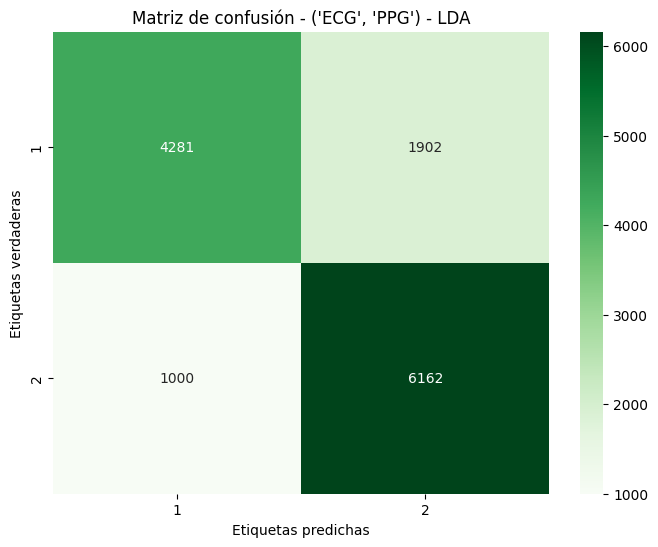

              precision    recall  f1-score   support

           1       0.81      0.69      0.75      6183
           2       0.76      0.86      0.81      7162

    accuracy                           0.78     13345
   macro avg       0.79      0.78      0.78     13345
weighted avg       0.79      0.78      0.78     13345

Training KNN model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG') - KNN Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.717947  ('ECG', 'PPG') - KNN
1  Precision  0.718018  ('ECG', 'PPG') - KNN
2     Recall  0.717947  ('ECG', 'PPG') - KNN
3   F1 Score  0.717980  ('ECG', 'PPG') - KNN
[('ECG', 'PPG') - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[('ECG', 'PPG') - KNN] Accuracy: 0.7179
('ECG', 'PPG') - KNN - Confusion Matrix
[[4312 1871]
 [1893 5269]]


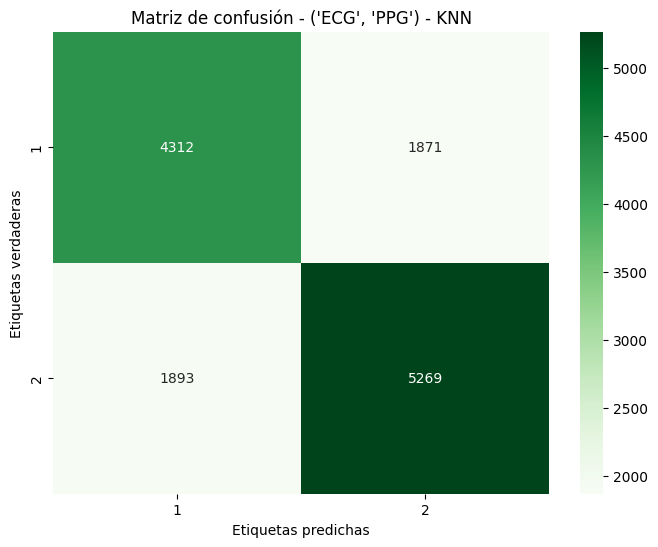

Training by signal combinations:   9%|▉         | 1/11 [1:41:42<16:57:05, 6102.55s/it]

              precision    recall  f1-score   support

           1       0.69      0.70      0.70      6183
           2       0.74      0.74      0.74      7162

    accuracy                           0.72     13345
   macro avg       0.72      0.72      0.72     13345
weighted avg       0.72      0.72      0.72     13345

Training DecisionTree model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'EDA') - DecisionTree Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.826452  ('ECG', 'EDA') - DecisionTree
1  Precision  0.826480  ('ECG', 'EDA') - DecisionTree
2     Recall  0.826452  ('ECG', 'EDA') - DecisionTree
3   F1 Score  0.826465  ('ECG', 'EDA') - DecisionTree
[('ECG', 'EDA') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('ECG', 'EDA') - DecisionTree] Accuracy: 0.8265
('ECG', 'EDA') - DecisionTree - Confusion Matrix
[[5032 1151]


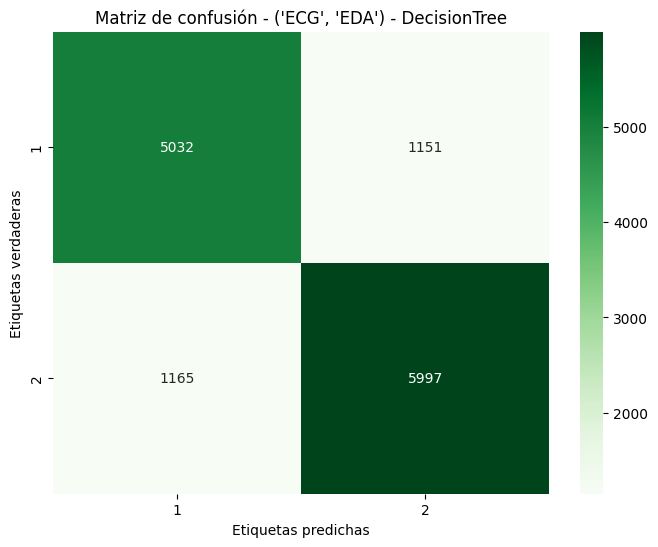

              precision    recall  f1-score   support

           1       0.81      0.81      0.81      6183
           2       0.84      0.84      0.84      7162

    accuracy                           0.83     13345
   macro avg       0.83      0.83      0.83     13345
weighted avg       0.83      0.83      0.83     13345

Training RandomForest model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'EDA') - RandomForest Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.995654  ('ECG', 'EDA') - RandomForest
1  Precision  0.995654  ('ECG', 'EDA') - RandomForest
2     Recall  0.995654  ('ECG', 'EDA') - RandomForest
3   F1 Score  0.995654  ('ECG', 'EDA') - RandomForest
[('ECG', 'EDA') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[('ECG', 'EDA') - RandomForest] Accuracy: 0.9957
('ECG', 'EDA') - RandomForest - Confu

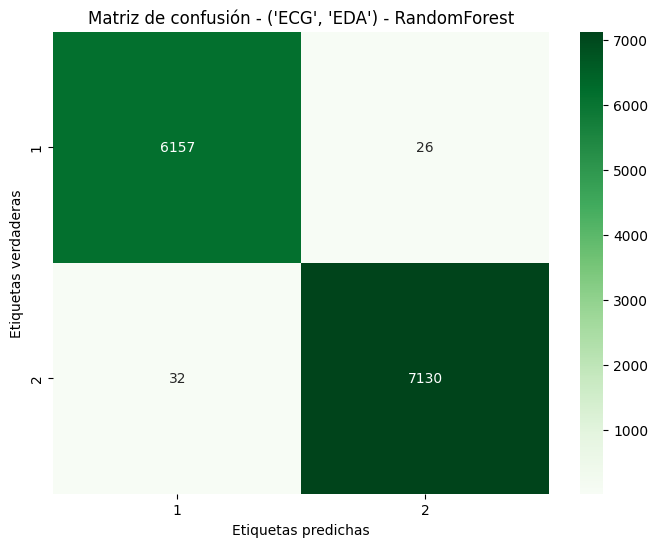

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'EDA') - AdaBoost Metrics
     Métrica     Valor                      Etapa
0   Accuracy  0.989284  ('ECG', 'EDA') - AdaBoost
1  Precision  0.989285  ('ECG', 'EDA') - AdaBoost
2     Recall  0.989284  ('ECG', 'EDA') - AdaBoost
3   F1 Score  0.989284  ('ECG', 'EDA') - AdaBoost
[('ECG', 'EDA') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('ECG', 'EDA') - AdaBoost] Accuracy: 0.9893
('ECG', 'EDA') - AdaBoost - Confusion Matrix
[[6105   78]
 [  65 70

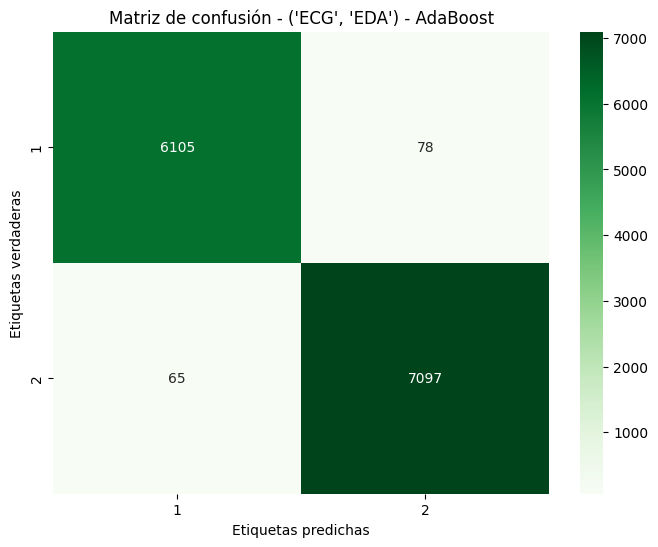

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      6183
           2       0.99      0.99      0.99      7162

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training LDA model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'EDA') - LDA Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.684901  ('ECG', 'EDA') - LDA
1  Precision  0.686985  ('ECG', 'EDA') - LDA
2     Recall  0.684901  ('ECG', 'EDA') - LDA
3   F1 Score  0.685313  ('ECG', 'EDA') - LDA
[('ECG', 'EDA') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'EDA') - LDA] Accuracy: 0.6849
('ECG', 'EDA') - LDA - Confusion Matrix
[[4283 1900]
 [2305 4857]]


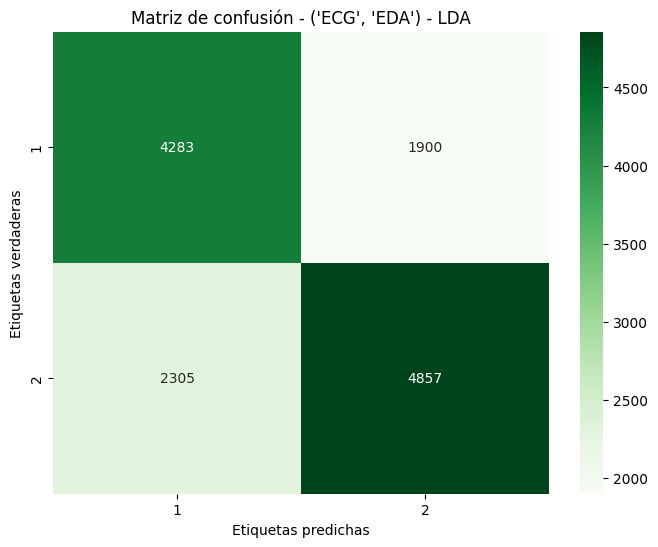

              precision    recall  f1-score   support

           1       0.65      0.69      0.67      6183
           2       0.72      0.68      0.70      7162

    accuracy                           0.68     13345
   macro avg       0.68      0.69      0.68     13345
weighted avg       0.69      0.68      0.69     13345

Training KNN model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'EDA') - KNN Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.731585  ('ECG', 'EDA') - KNN
1  Precision  0.731501  ('ECG', 'EDA') - KNN
2     Recall  0.731585  ('ECG', 'EDA') - KNN
3   F1 Score  0.731539  ('ECG', 'EDA') - KNN
[('ECG', 'EDA') - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[('ECG', 'EDA') - KNN] Accuracy: 0.7316
('ECG', 'EDA') - KNN - Confusion Matrix
[[4377 1806]
 [1776 5386]]


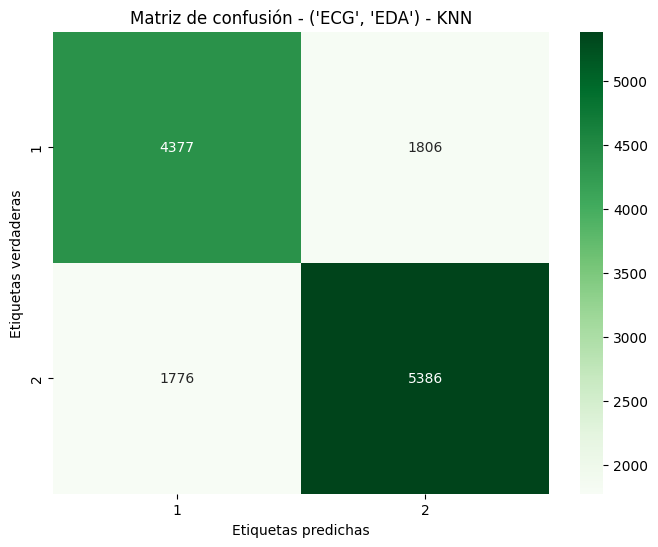

Training by signal combinations:  18%|█▊        | 2/11 [3:11:43<14:13:30, 5690.01s/it]

              precision    recall  f1-score   support

           1       0.71      0.71      0.71      6183
           2       0.75      0.75      0.75      7162

    accuracy                           0.73     13345
   macro avg       0.73      0.73      0.73     13345
weighted avg       0.73      0.73      0.73     13345

Training DecisionTree model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'RESP') - DecisionTree Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.736755  ('ECG', 'RESP') - DecisionTree
1  Precision  0.736819  ('ECG', 'RESP') - DecisionTree
2     Recall  0.736755  ('ECG', 'RESP') - DecisionTree
3   F1 Score  0.736785  ('ECG', 'RESP') - DecisionTree
[('ECG', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('ECG', 'RESP') - DecisionTree] Accuracy: 0.7368
('ECG', 'RESP') - DecisionTree - Confusion Matrix
[[4

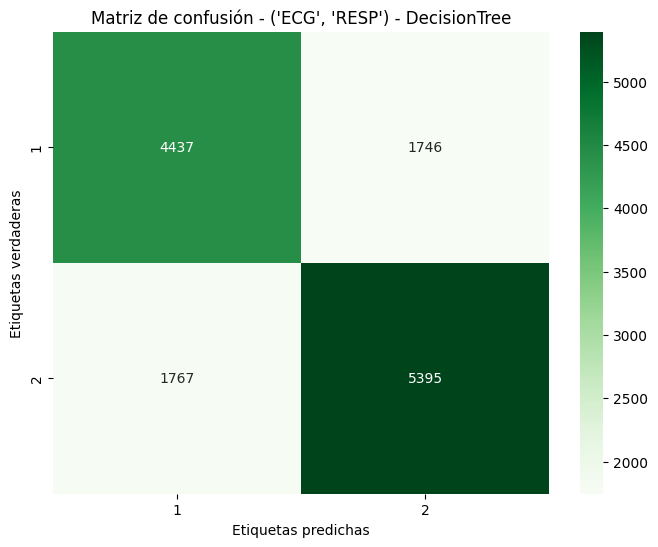

              precision    recall  f1-score   support

           1       0.72      0.72      0.72      6183
           2       0.76      0.75      0.75      7162

    accuracy                           0.74     13345
   macro avg       0.74      0.74      0.74     13345
weighted avg       0.74      0.74      0.74     13345

Training RandomForest model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'RESP') - RandomForest Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.991832  ('ECG', 'RESP') - RandomForest
1  Precision  0.991876  ('ECG', 'RESP') - RandomForest
2     Recall  0.991832  ('ECG', 'RESP') - RandomForest
3   F1 Score  0.991835  ('ECG', 'RESP') - RandomForest
[('ECG', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[('ECG', 'RESP') - RandomForest] Accuracy: 0.9918
('ECG', 'RESP') - RandomFore

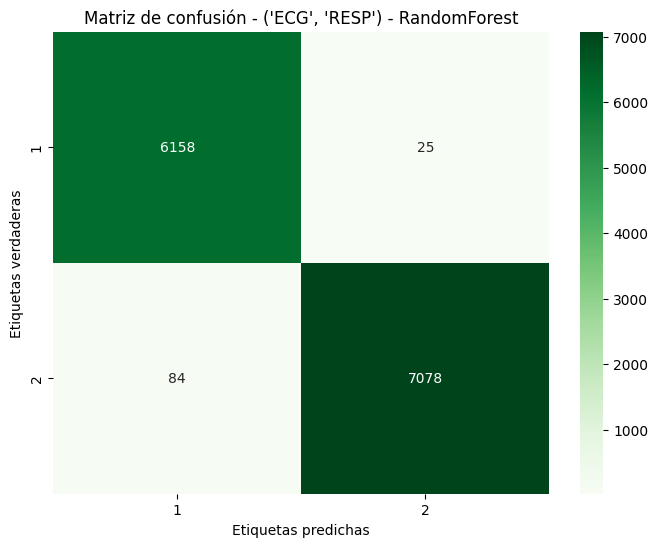

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      6183
           2       1.00      0.99      0.99      7162

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training AdaBoost model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'RESP') - AdaBoost Metrics
     Métrica     Valor                       Etapa
0   Accuracy  0.957362  ('ECG', 'RESP') - AdaBoost
1  Precision  0.957456  ('ECG', 'RESP') - AdaBoost
2     Recall  0.957362  ('ECG', 'RESP') - AdaBoost
3   F1 Score  0.957379  ('ECG', 'RESP') - AdaBoost
[('ECG', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('ECG', 'RESP') - AdaBoost] Accuracy: 0.9574
('ECG', 'RESP') - AdaBoost - Confusion Matrix
[[5936  247]

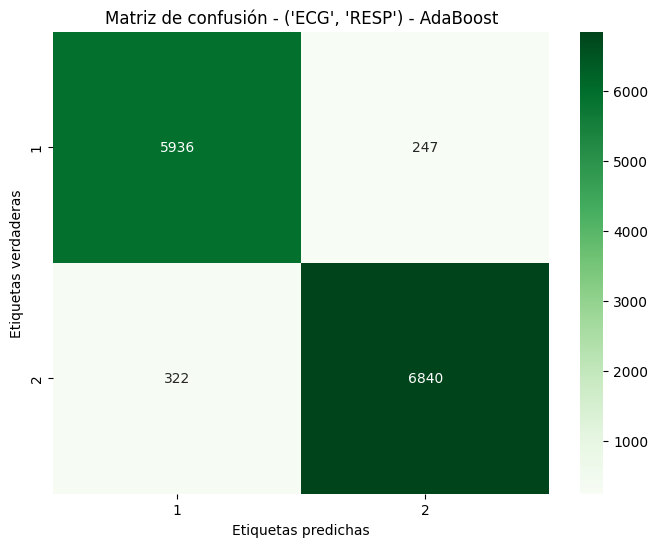

              precision    recall  f1-score   support

           1       0.95      0.96      0.95      6183
           2       0.97      0.96      0.96      7162

    accuracy                           0.96     13345
   macro avg       0.96      0.96      0.96     13345
weighted avg       0.96      0.96      0.96     13345

Training LDA model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'RESP') - LDA Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.663544  ('ECG', 'RESP') - LDA
1  Precision  0.662636  ('ECG', 'RESP') - LDA
2     Recall  0.663544  ('ECG', 'RESP') - LDA
3   F1 Score  0.662491  ('ECG', 'RESP') - LDA
[('ECG', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'RESP') - LDA] Accuracy: 0.6635
('ECG', 'RESP') - LDA - Confusion Matrix
[[3738 2445]
 [2045 5117]]


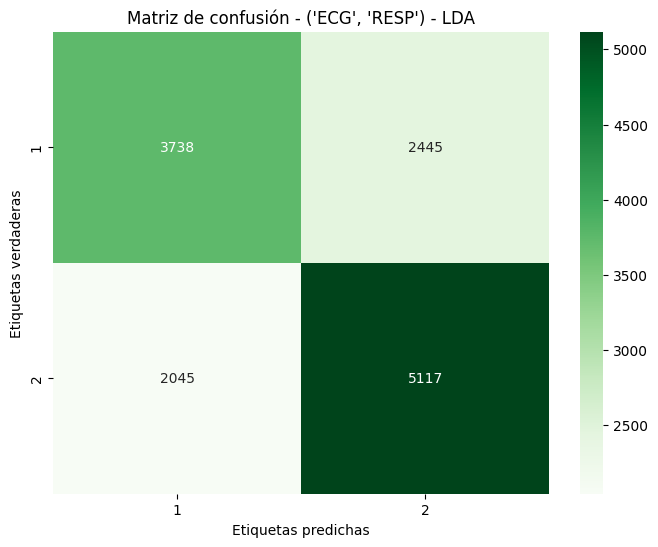

              precision    recall  f1-score   support

           1       0.65      0.60      0.62      6183
           2       0.68      0.71      0.70      7162

    accuracy                           0.66     13345
   macro avg       0.66      0.66      0.66     13345
weighted avg       0.66      0.66      0.66     13345

Training KNN model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'RESP') - KNN Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.715099  ('ECG', 'RESP') - KNN
1  Precision  0.715068  ('ECG', 'RESP') - KNN
2     Recall  0.715099  ('ECG', 'RESP') - KNN
3   F1 Score  0.715083  ('ECG', 'RESP') - KNN
[('ECG', 'RESP') - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[('ECG', 'RESP') - KNN] Accuracy: 0.7151
('ECG', 'RESP') - KNN - Confusion Matrix
[[4277 1906]
 [1896 5266]]


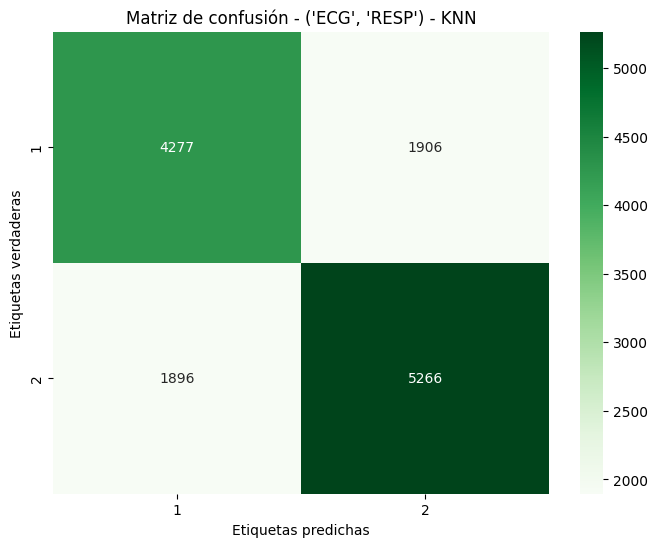

Training by signal combinations:  27%|██▋       | 3/11 [4:34:53<11:56:02, 5370.33s/it]

              precision    recall  f1-score   support

           1       0.69      0.69      0.69      6183
           2       0.73      0.74      0.73      7162

    accuracy                           0.72     13345
   macro avg       0.71      0.71      0.71     13345
weighted avg       0.72      0.72      0.72     13345

Training DecisionTree model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('PPG', 'EDA') - DecisionTree Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.887673  ('PPG', 'EDA') - DecisionTree
1  Precision  0.888480  ('PPG', 'EDA') - DecisionTree
2     Recall  0.887673  ('PPG', 'EDA') - DecisionTree
3   F1 Score  0.887343  ('PPG', 'EDA') - DecisionTree
[('PPG', 'EDA') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('PPG', 'EDA') - DecisionTree] Accuracy: 0.8877
('PPG', 'EDA') - DecisionTree - Confusion Matrix
[[5243  940]


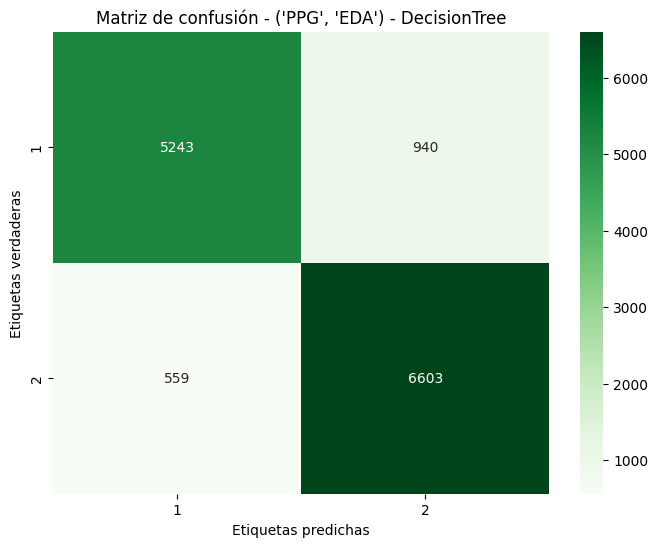

              precision    recall  f1-score   support

           1       0.90      0.85      0.87      6183
           2       0.88      0.92      0.90      7162

    accuracy                           0.89     13345
   macro avg       0.89      0.88      0.89     13345
weighted avg       0.89      0.89      0.89     13345

Training RandomForest model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('PPG', 'EDA') - RandomForest Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.999026  ('PPG', 'EDA') - RandomForest
1  Precision  0.999026  ('PPG', 'EDA') - RandomForest
2     Recall  0.999026  ('PPG', 'EDA') - RandomForest
3   F1 Score  0.999026  ('PPG', 'EDA') - RandomForest
[('PPG', 'EDA') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
[('PPG', 'EDA') - RandomForest] Accuracy: 0.9990
('PPG', 'EDA') - RandomForest - Confu

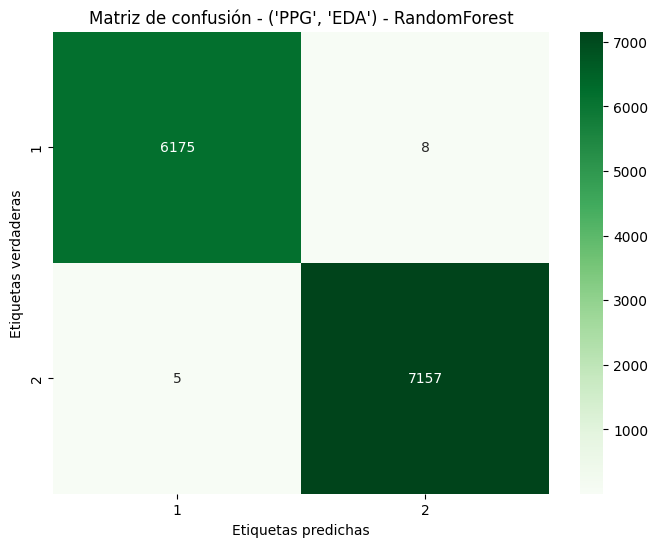

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('PPG', 'EDA') - AdaBoost Metrics
     Métrica     Valor                      Etapa
0   Accuracy  0.997602  ('PPG', 'EDA') - AdaBoost
1  Precision  0.997602  ('PPG', 'EDA') - AdaBoost
2     Recall  0.997602  ('PPG', 'EDA') - AdaBoost
3   F1 Score  0.997602  ('PPG', 'EDA') - AdaBoost
[('PPG', 'EDA') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('PPG', 'EDA') - AdaBoost] Accuracy: 0.9976
('PPG', 'EDA') - AdaBoost - Confusion Matrix
[[6165   18]
 [  14 71

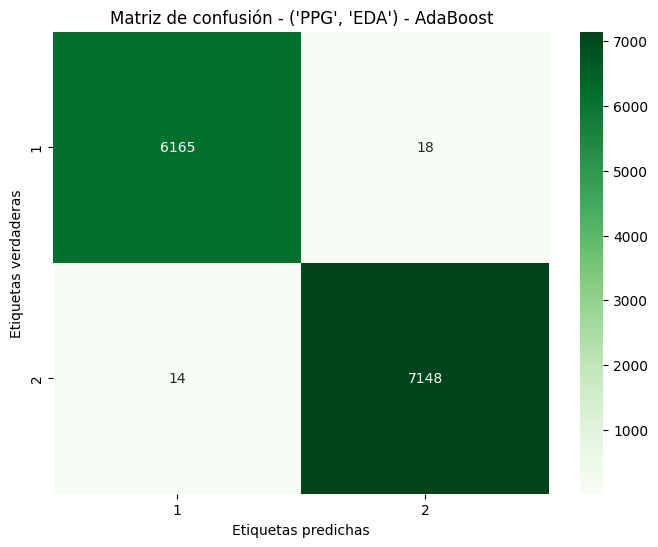

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training LDA model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('PPG', 'EDA') - LDA Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.791832  ('PPG', 'EDA') - LDA
1  Precision  0.793438  ('PPG', 'EDA') - LDA
2     Recall  0.791832  ('PPG', 'EDA') - LDA
3   F1 Score  0.790459  ('PPG', 'EDA') - LDA
[('PPG', 'EDA') - LDA] Best Params: {'solver': 'svd'}
[('PPG', 'EDA') - LDA] Accuracy: 0.7918
('PPG', 'EDA') - LDA - Confusion Matrix
[[4448 1735]
 [1043 6119]]


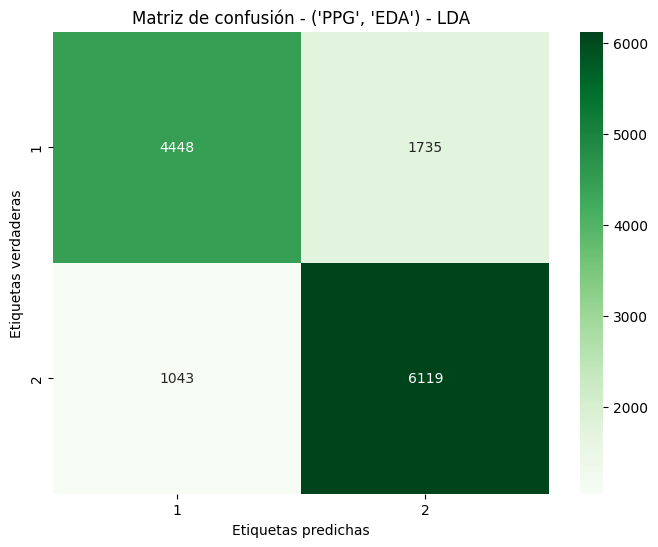

              precision    recall  f1-score   support

           1       0.81      0.72      0.76      6183
           2       0.78      0.85      0.81      7162

    accuracy                           0.79     13345
   macro avg       0.79      0.79      0.79     13345
weighted avg       0.79      0.79      0.79     13345

Training KNN model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('PPG', 'EDA') - KNN Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.985688  ('PPG', 'EDA') - KNN
1  Precision  0.985692  ('PPG', 'EDA') - KNN
2     Recall  0.985688  ('PPG', 'EDA') - KNN
3   F1 Score  0.985689  ('PPG', 'EDA') - KNN
[('PPG', 'EDA') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('PPG', 'EDA') - KNN] Accuracy: 0.9857
('PPG', 'EDA') - KNN - Confusion Matrix
[[6095   88]
 [ 103 7059]]


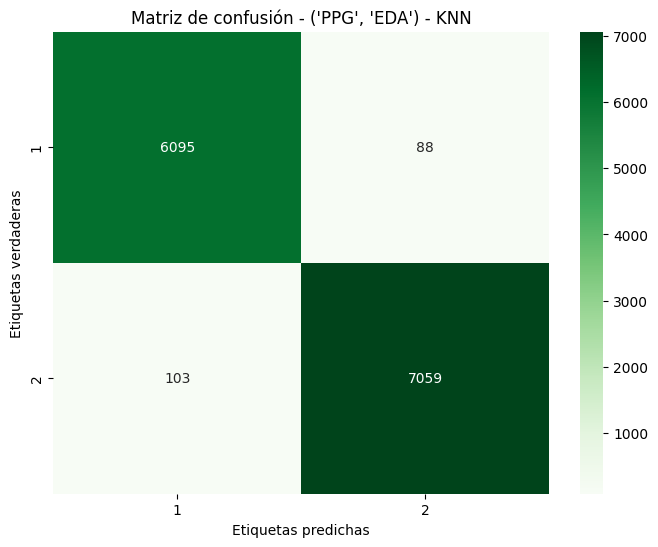

Training by signal combinations:  36%|███▋      | 4/11 [6:04:49<10:27:42, 5380.35s/it]

              precision    recall  f1-score   support

           1       0.98      0.99      0.98      6183
           2       0.99      0.99      0.99      7162

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training DecisionTree model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('PPG', 'RESP') - DecisionTree Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.866317  ('PPG', 'RESP') - DecisionTree
1  Precision  0.866547  ('PPG', 'RESP') - DecisionTree
2     Recall  0.866317  ('PPG', 'RESP') - DecisionTree
3   F1 Score  0.866052  ('PPG', 'RESP') - DecisionTree
[('PPG', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('PPG', 'RESP') - DecisionTree] Accuracy: 0.8663
('PPG', 'RESP') - DecisionTree - Confusion Matrix
[[5

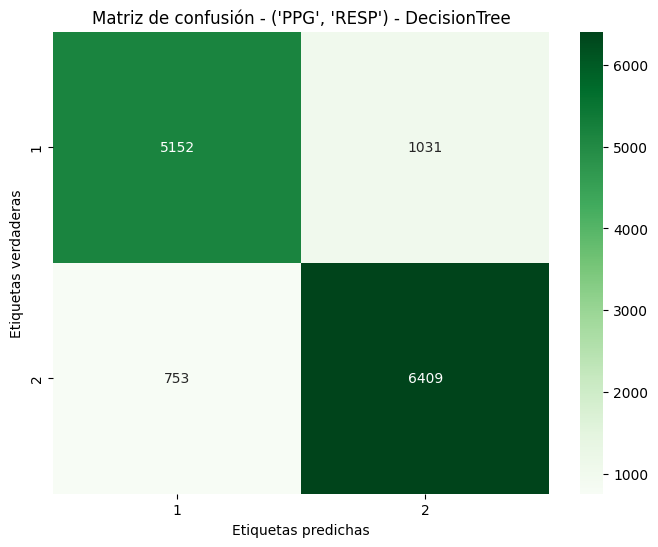

              precision    recall  f1-score   support

           1       0.87      0.83      0.85      6183
           2       0.86      0.89      0.88      7162

    accuracy                           0.87     13345
   macro avg       0.87      0.86      0.87     13345
weighted avg       0.87      0.87      0.87     13345

Training RandomForest model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('PPG', 'RESP') - RandomForest Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.998202  ('PPG', 'RESP') - RandomForest
1  Precision  0.998202  ('PPG', 'RESP') - RandomForest
2     Recall  0.998202  ('PPG', 'RESP') - RandomForest
3   F1 Score  0.998202  ('PPG', 'RESP') - RandomForest
[('PPG', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[('PPG', 'RESP') - RandomForest] Accuracy: 0.9982
('PPG', 'RESP') - RandomFore

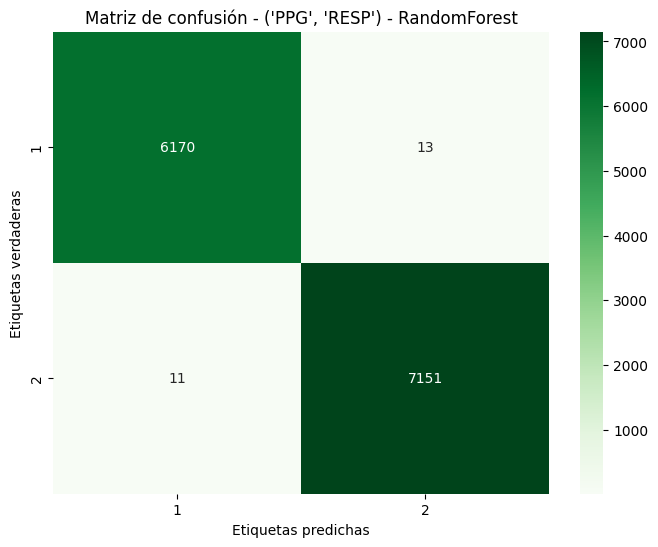

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('PPG', 'RESP') - AdaBoost Metrics
     Métrica     Valor                       Etapa
0   Accuracy  0.995504  ('PPG', 'RESP') - AdaBoost
1  Precision  0.995504  ('PPG', 'RESP') - AdaBoost
2     Recall  0.995504  ('PPG', 'RESP') - AdaBoost
3   F1 Score  0.995504  ('PPG', 'RESP') - AdaBoost
[('PPG', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('PPG', 'RESP') - AdaBoost] Accuracy: 0.9955
('PPG', 'RESP') - AdaBoost - Confusion Matrix
[[6150   33]

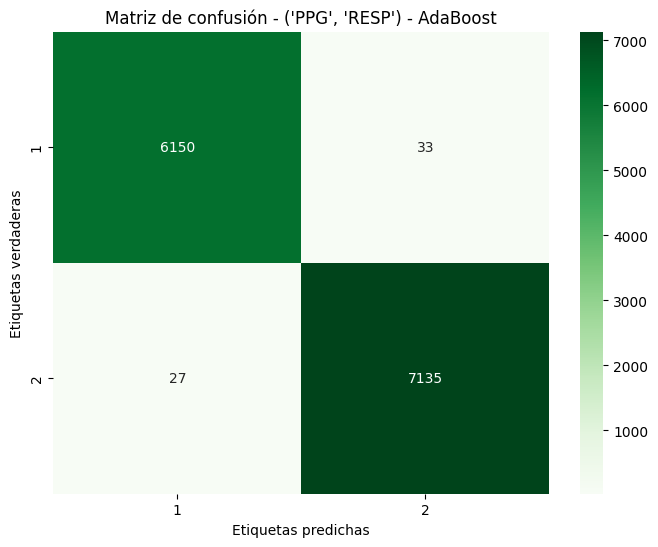

              precision    recall  f1-score   support

           1       1.00      0.99      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training LDA model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('PPG', 'RESP') - LDA Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.803372  ('PPG', 'RESP') - LDA
1  Precision  0.805273  ('PPG', 'RESP') - LDA
2     Recall  0.803372  ('PPG', 'RESP') - LDA
3   F1 Score  0.802048  ('PPG', 'RESP') - LDA
[('PPG', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('PPG', 'RESP') - LDA] Accuracy: 0.8034
('PPG', 'RESP') - LDA - Confusion Matrix
[[4520 1663]
 [ 961 6201]]


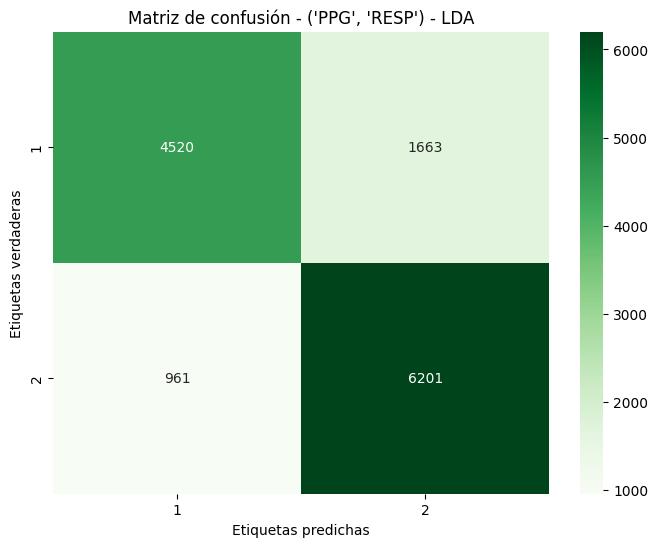

              precision    recall  f1-score   support

           1       0.82      0.73      0.78      6183
           2       0.79      0.87      0.83      7162

    accuracy                           0.80     13345
   macro avg       0.81      0.80      0.80     13345
weighted avg       0.81      0.80      0.80     13345

Training KNN model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('PPG', 'RESP') - KNN Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.988835  ('PPG', 'RESP') - KNN
1  Precision  0.988848  ('PPG', 'RESP') - KNN
2     Recall  0.988835  ('PPG', 'RESP') - KNN
3   F1 Score  0.988837  ('PPG', 'RESP') - KNN
[('PPG', 'RESP') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('PPG', 'RESP') - KNN] Accuracy: 0.9888
('PPG', 'RESP') - KNN - Confusion Matrix
[[6123   60]
 [  89 7073]]


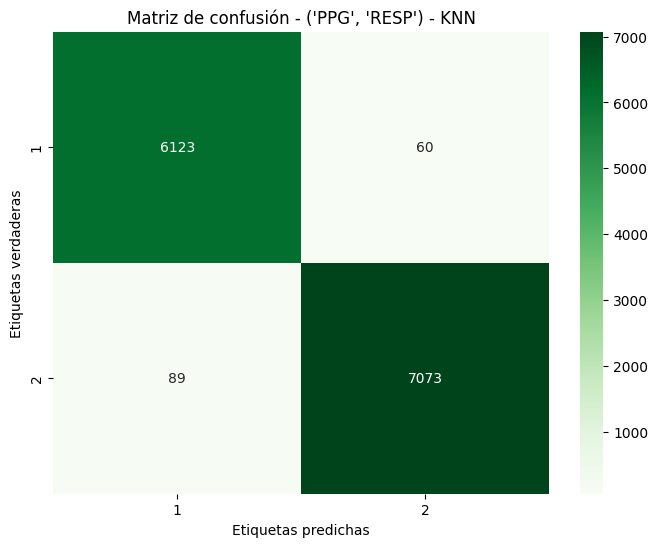

Training by signal combinations:  45%|████▌     | 5/11 [7:27:43<8:43:22, 5233.71s/it] 

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      6183
           2       0.99      0.99      0.99      7162

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training DecisionTree model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.842563  ('EDA', 'RESP') - DecisionTree
1  Precision  0.843485  ('EDA', 'RESP') - DecisionTree
2     Recall  0.842563  ('EDA', 'RESP') - DecisionTree
3   F1 Score  0.841948  ('EDA', 'RESP') - DecisionTree
[('EDA', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('EDA', 'RESP') - DecisionTree] Accuracy: 0.8426
('EDA', 'RESP') - DecisionTree - Confusion Matrix
[[4

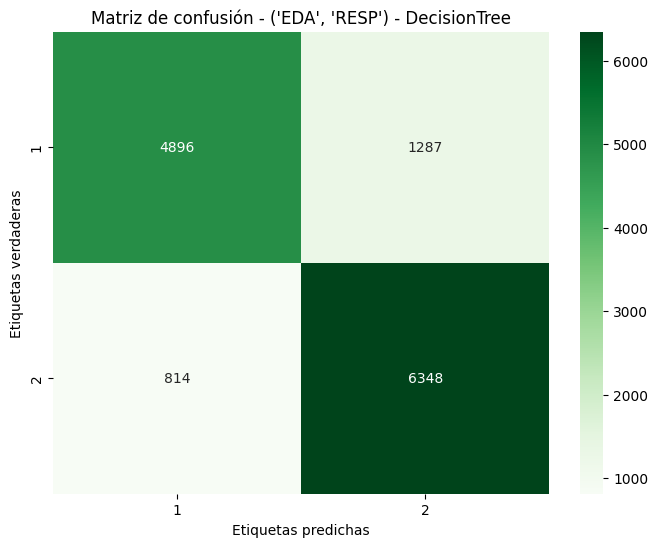

              precision    recall  f1-score   support

           1       0.86      0.79      0.82      6183
           2       0.83      0.89      0.86      7162

    accuracy                           0.84     13345
   macro avg       0.84      0.84      0.84     13345
weighted avg       0.84      0.84      0.84     13345

Training RandomForest model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('EDA', 'RESP') - RandomForest Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.997452  ('EDA', 'RESP') - RandomForest
1  Precision  0.997452  ('EDA', 'RESP') - RandomForest
2     Recall  0.997452  ('EDA', 'RESP') - RandomForest
3   F1 Score  0.997452  ('EDA', 'RESP') - RandomForest
[('EDA', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
[('EDA', 'RESP') - RandomForest] Accuracy: 0.9975
('EDA', 'RESP') - RandomFore

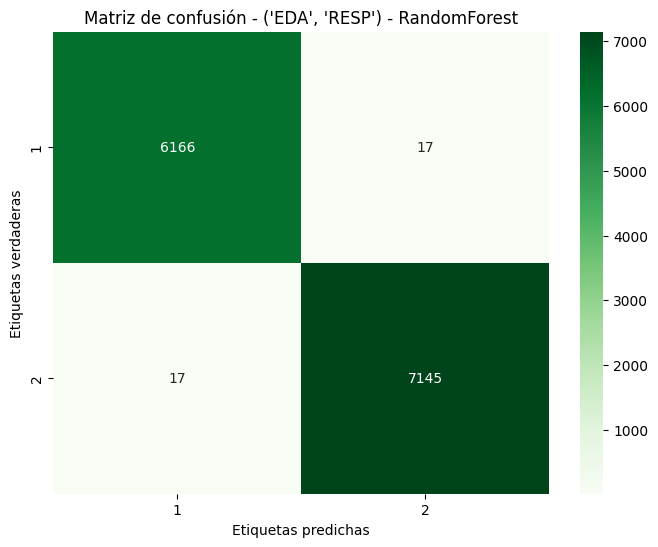

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                       Etapa
0   Accuracy  0.994530  ('EDA', 'RESP') - AdaBoost
1  Precision  0.994530  ('EDA', 'RESP') - AdaBoost
2     Recall  0.994530  ('EDA', 'RESP') - AdaBoost
3   F1 Score  0.994529  ('EDA', 'RESP') - AdaBoost
[('EDA', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('EDA', 'RESP') - AdaBoost] Accuracy: 0.9945
('EDA', 'RESP') - AdaBoost - Confusion Matrix
[[6141   42]

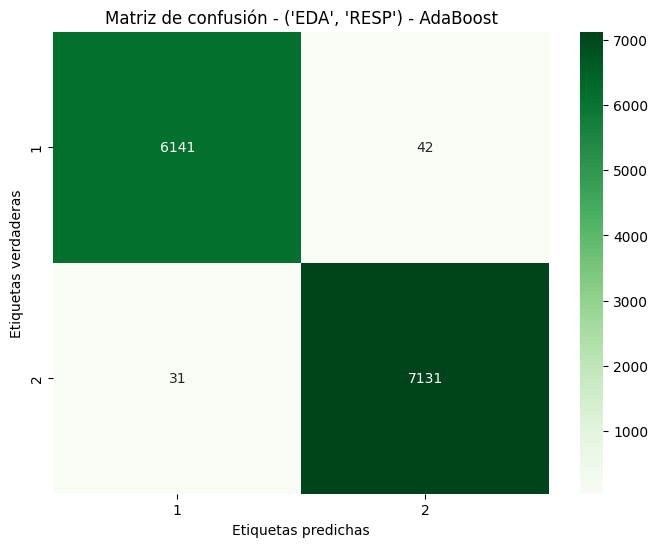

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      6183
           2       0.99      1.00      0.99      7162

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training LDA model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('EDA', 'RESP') - LDA Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.692544  ('EDA', 'RESP') - LDA
1  Precision  0.692069  ('EDA', 'RESP') - LDA
2     Recall  0.692544  ('EDA', 'RESP') - LDA
3   F1 Score  0.692179  ('EDA', 'RESP') - LDA
[('EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('EDA', 'RESP') - LDA] Accuracy: 0.6925
('EDA', 'RESP') - LDA - Confusion Matrix
[[4041 2142]
 [1961 5201]]


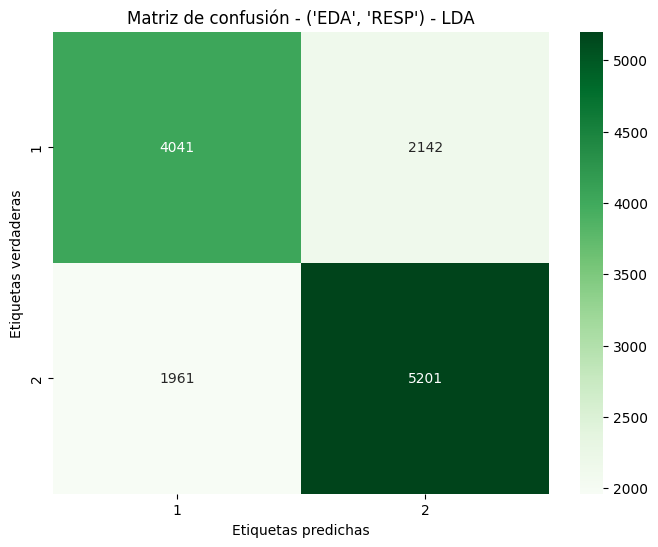

              precision    recall  f1-score   support

           1       0.67      0.65      0.66      6183
           2       0.71      0.73      0.72      7162

    accuracy                           0.69     13345
   macro avg       0.69      0.69      0.69     13345
weighted avg       0.69      0.69      0.69     13345

Training KNN model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('EDA', 'RESP') - KNN Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.986961  ('EDA', 'RESP') - KNN
1  Precision  0.986962  ('EDA', 'RESP') - KNN
2     Recall  0.986961  ('EDA', 'RESP') - KNN
3   F1 Score  0.986960  ('EDA', 'RESP') - KNN
[('EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('EDA', 'RESP') - KNN] Accuracy: 0.9870
('EDA', 'RESP') - KNN - Confusion Matrix
[[6087   96]
 [  78 7084]]


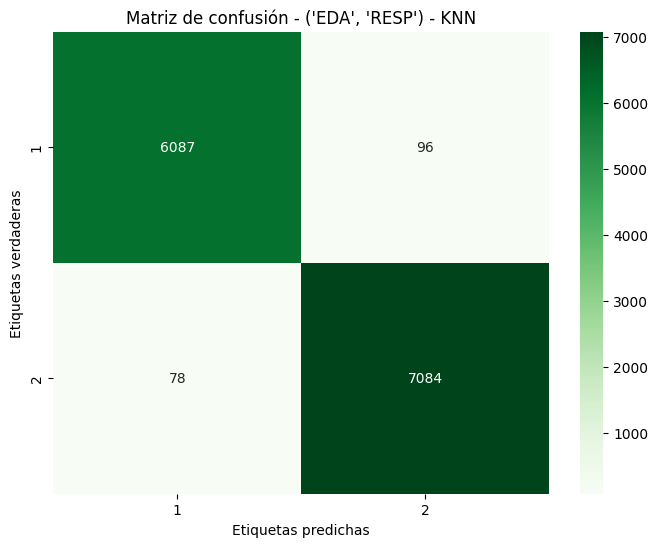

Training by signal combinations:  55%|█████▍    | 6/11 [8:46:22<7:01:33, 5058.71s/it]

              precision    recall  f1-score   support

           1       0.99      0.98      0.99      6183
           2       0.99      0.99      0.99      7162

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training DecisionTree model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG', 'EDA') - DecisionTree Metrics
     Métrica     Valor                                 Etapa
0   Accuracy  0.888872  ('ECG', 'PPG', 'EDA') - DecisionTree
1  Precision  0.889500  ('ECG', 'PPG', 'EDA') - DecisionTree
2     Recall  0.888872  ('ECG', 'PPG', 'EDA') - DecisionTree
3   F1 Score  0.888584  ('ECG', 'PPG', 'EDA') - DecisionTree
[('ECG', 'PPG', 'EDA') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('ECG', 'PPG', 'EDA') - DecisionTree] Accuracy: 0.8889

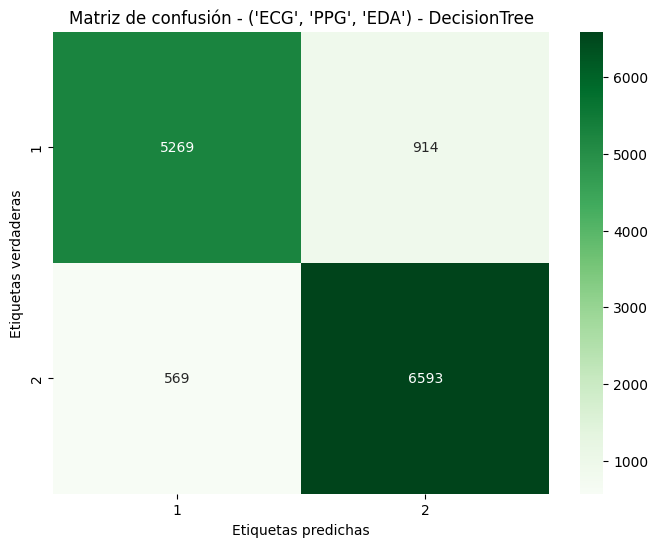

              precision    recall  f1-score   support

           1       0.90      0.85      0.88      6183
           2       0.88      0.92      0.90      7162

    accuracy                           0.89     13345
   macro avg       0.89      0.89      0.89     13345
weighted avg       0.89      0.89      0.89     13345

Training RandomForest model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG', 'EDA') - RandomForest Metrics
     Métrica     Valor                                 Etapa
0   Accuracy  0.999625  ('ECG', 'PPG', 'EDA') - RandomForest
1  Precision  0.999625  ('ECG', 'PPG', 'EDA') - RandomForest
2     Recall  0.999625  ('ECG', 'PPG', 'EDA') - RandomForest
3   F1 Score  0.999625  ('ECG', 'PPG', 'EDA') - RandomForest
[('ECG', 'PPG', 'EDA') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
[('ECG', 'PPG', 'EDA') - Rando

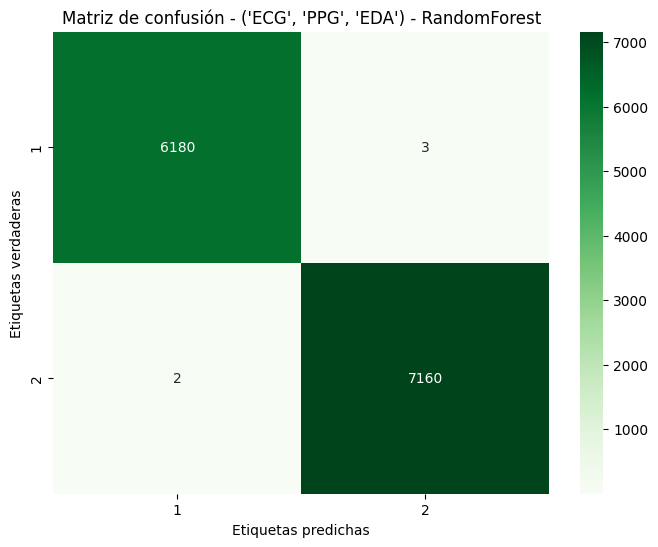

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG', 'EDA') - AdaBoost Metrics
     Métrica     Valor                             Etapa
0   Accuracy  0.998951  ('ECG', 'PPG', 'EDA') - AdaBoost
1  Precision  0.998951  ('ECG', 'PPG', 'EDA') - AdaBoost
2     Recall  0.998951  ('ECG', 'PPG', 'EDA') - AdaBoost
3   F1 Score  0.998951  ('ECG', 'PPG', 'EDA') - AdaBoost
[('ECG', 'PPG', 'EDA') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('ECG', 'PPG', 'EDA') - AdaBoost] Accuracy: 0.9990
('EC

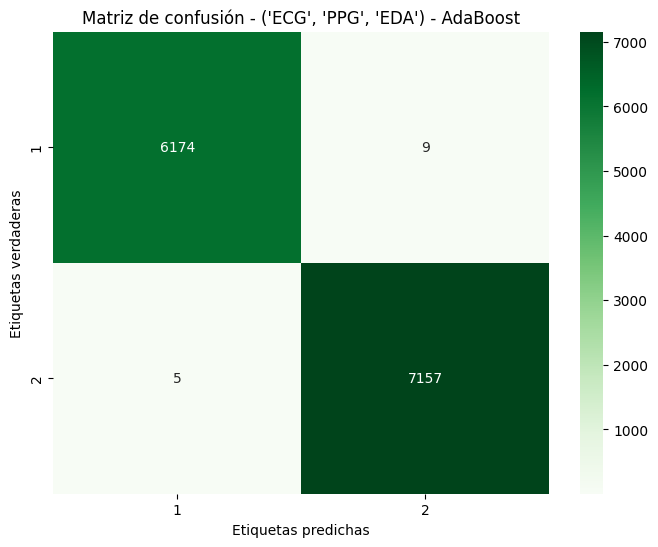

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training LDA model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG', 'EDA') - LDA Metrics
     Métrica     Valor                        Etapa
0   Accuracy  0.797152  ('ECG', 'PPG', 'EDA') - LDA
1  Precision  0.798750  ('ECG', 'PPG', 'EDA') - LDA
2     Recall  0.797152  ('ECG', 'PPG', 'EDA') - LDA
3   F1 Score  0.795856  ('ECG', 'PPG', 'EDA') - LDA
[('ECG', 'PPG', 'EDA') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG', 'EDA') - LDA] Accuracy: 0.7972
('ECG', 'PPG', 'EDA') - LDA - Confusion Matrix
[[4491 1692]
 [1015 6147]]


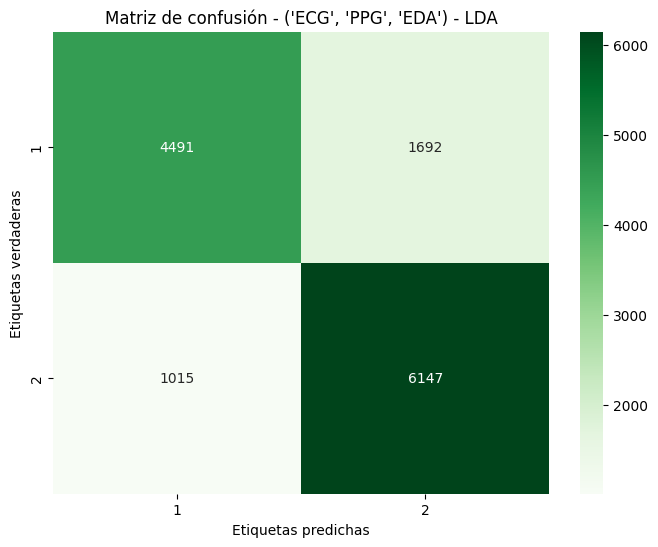

              precision    recall  f1-score   support

           1       0.82      0.73      0.77      6183
           2       0.78      0.86      0.82      7162

    accuracy                           0.80     13345
   macro avg       0.80      0.79      0.79     13345
weighted avg       0.80      0.80      0.80     13345

Training KNN model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG', 'EDA') - KNN Metrics
     Métrica     Valor                        Etapa
0   Accuracy  0.733983  ('ECG', 'PPG', 'EDA') - KNN
1  Precision  0.733989  ('ECG', 'PPG', 'EDA') - KNN
2     Recall  0.733983  ('ECG', 'PPG', 'EDA') - KNN
3   F1 Score  0.733986  ('ECG', 'PPG', 'EDA') - KNN
[('ECG', 'PPG', 'EDA') - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[('ECG', 'PPG', 'EDA') - KNN] Accuracy: 0.7340
('ECG', 'PPG', 'EDA') - KNN - Confusion Matrix
[[4409 1774]
 [1776 5386]]


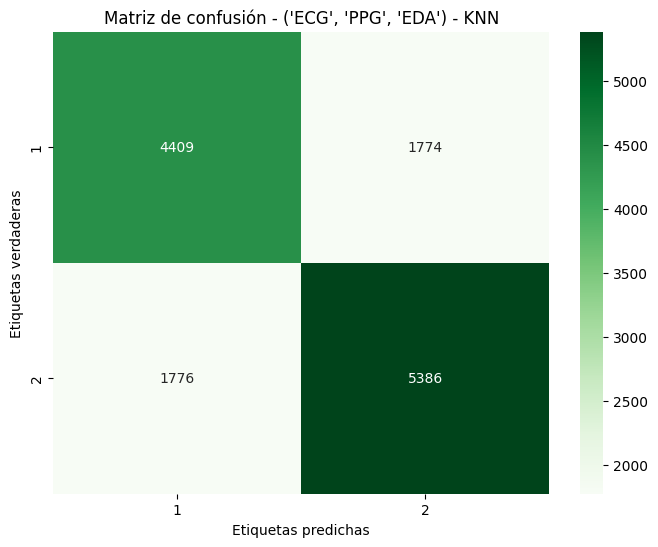

Training by signal combinations:  64%|██████▎   | 7/11 [10:46:24<6:23:58, 5759.63s/it]

              precision    recall  f1-score   support

           1       0.71      0.71      0.71      6183
           2       0.75      0.75      0.75      7162

    accuracy                           0.73     13345
   macro avg       0.73      0.73      0.73     13345
weighted avg       0.73      0.73      0.73     13345

Training DecisionTree model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.867966  ('ECG', 'PPG', 'RESP') - DecisionTree
1  Precision  0.869322  ('ECG', 'PPG', 'RESP') - DecisionTree
2     Recall  0.867966  ('ECG', 'PPG', 'RESP') - DecisionTree
3   F1 Score  0.867413  ('ECG', 'PPG', 'RESP') - DecisionTree
[('ECG', 'PPG', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('ECG', 'PPG', 'RESP') - DecisionTree] Accurac

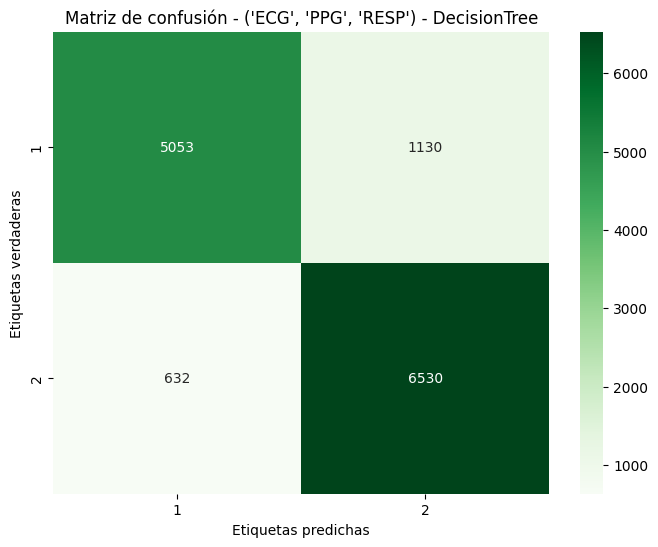

              precision    recall  f1-score   support

           1       0.89      0.82      0.85      6183
           2       0.85      0.91      0.88      7162

    accuracy                           0.87     13345
   macro avg       0.87      0.86      0.87     13345
weighted avg       0.87      0.87      0.87     13345

Training RandomForest model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG', 'RESP') - RandomForest Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.998426  ('ECG', 'PPG', 'RESP') - RandomForest
1  Precision  0.998427  ('ECG', 'PPG', 'RESP') - RandomForest
2     Recall  0.998426  ('ECG', 'PPG', 'RESP') - RandomForest
3   F1 Score  0.998426  ('ECG', 'PPG', 'RESP') - RandomForest
[('ECG', 'PPG', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
[('ECG', 'PPG', 'RESP'

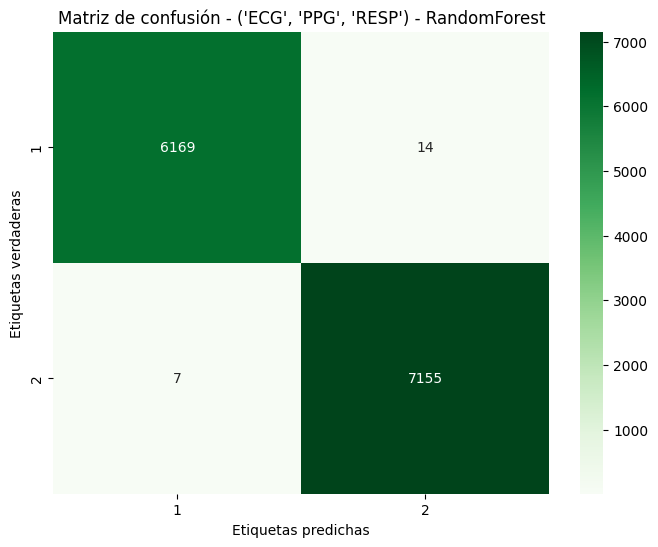

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG', 'RESP') - AdaBoost Metrics
     Métrica     Valor                              Etapa
0   Accuracy  0.997152  ('ECG', 'PPG', 'RESP') - AdaBoost
1  Precision  0.997153  ('ECG', 'PPG', 'RESP') - AdaBoost
2     Recall  0.997152  ('ECG', 'PPG', 'RESP') - AdaBoost
3   F1 Score  0.997152  ('ECG', 'PPG', 'RESP') - AdaBoost
[('ECG', 'PPG', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('ECG', 'PPG', 'RESP') - AdaBoost] Accuracy: 0.

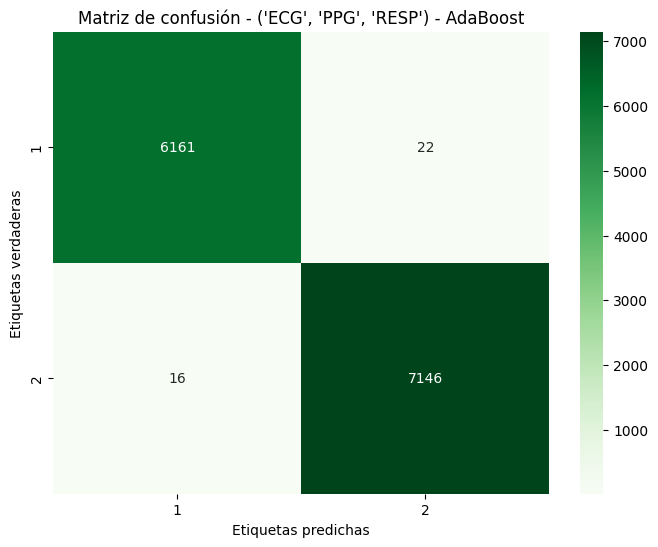

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training LDA model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG', 'RESP') - LDA Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.813788  ('ECG', 'PPG', 'RESP') - LDA
1  Precision  0.815276  ('ECG', 'PPG', 'RESP') - LDA
2     Recall  0.813788  ('ECG', 'PPG', 'RESP') - LDA
3   F1 Score  0.812734  ('ECG', 'PPG', 'RESP') - LDA
[('ECG', 'PPG', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG', 'RESP') - LDA] Accuracy: 0.8138
('ECG', 'PPG', 'RESP') - LDA - Confusion Matrix
[[4630 1553]
 [ 932 6230]]


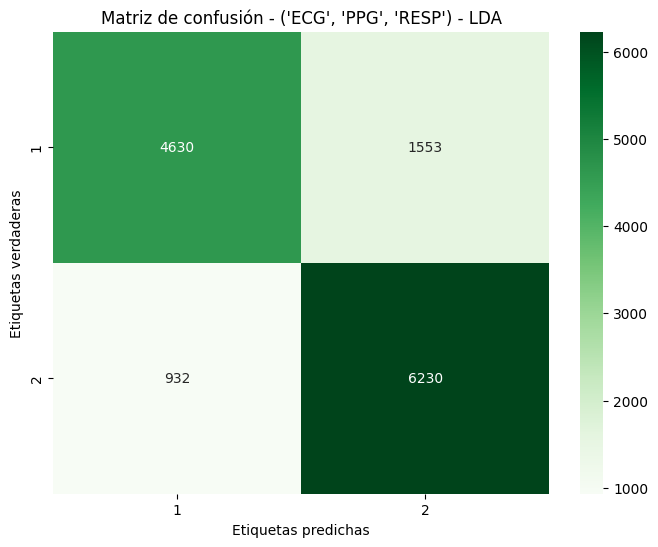

              precision    recall  f1-score   support

           1       0.83      0.75      0.79      6183
           2       0.80      0.87      0.83      7162

    accuracy                           0.81     13345
   macro avg       0.82      0.81      0.81     13345
weighted avg       0.82      0.81      0.81     13345

Training KNN model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG', 'RESP') - KNN Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.719071  ('ECG', 'PPG', 'RESP') - KNN
1  Precision  0.719145  ('ECG', 'PPG', 'RESP') - KNN
2     Recall  0.719071  ('ECG', 'PPG', 'RESP') - KNN
3   F1 Score  0.719106  ('ECG', 'PPG', 'RESP') - KNN
[('ECG', 'PPG', 'RESP') - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[('ECG', 'PPG', 'RESP') - KNN] Accuracy: 0.7191
('ECG', 'PPG', 'RESP') - KNN - Confusion Matrix
[[4320 1863]
 [1886 5276]]


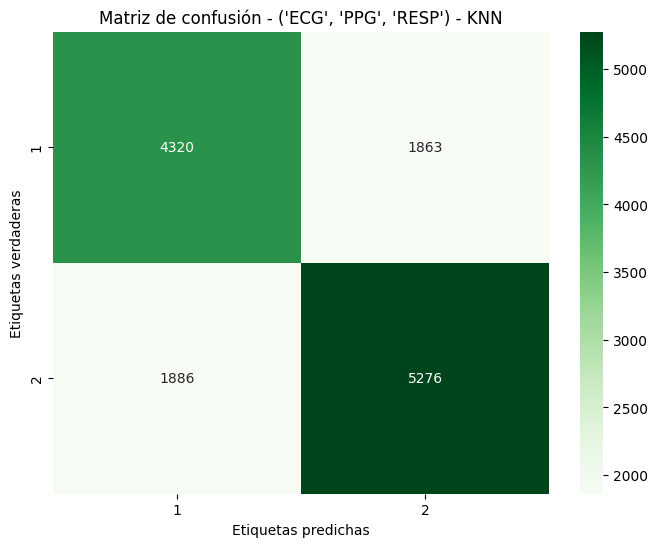

Training by signal combinations:  73%|███████▎  | 8/11 [12:44:46<5:09:20, 6186.81s/it]

              precision    recall  f1-score   support

           1       0.70      0.70      0.70      6183
           2       0.74      0.74      0.74      7162

    accuracy                           0.72     13345
   macro avg       0.72      0.72      0.72     13345
weighted avg       0.72      0.72      0.72     13345

Training DecisionTree model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.867666  ('ECG', 'EDA', 'RESP') - DecisionTree
1  Precision  0.868808  ('ECG', 'EDA', 'RESP') - DecisionTree
2     Recall  0.867666  ('ECG', 'EDA', 'RESP') - DecisionTree
3   F1 Score  0.867816  ('ECG', 'EDA', 'RESP') - DecisionTree
[('ECG', 'EDA', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('ECG', 'EDA', 'RESP') - DecisionTree] Accurac

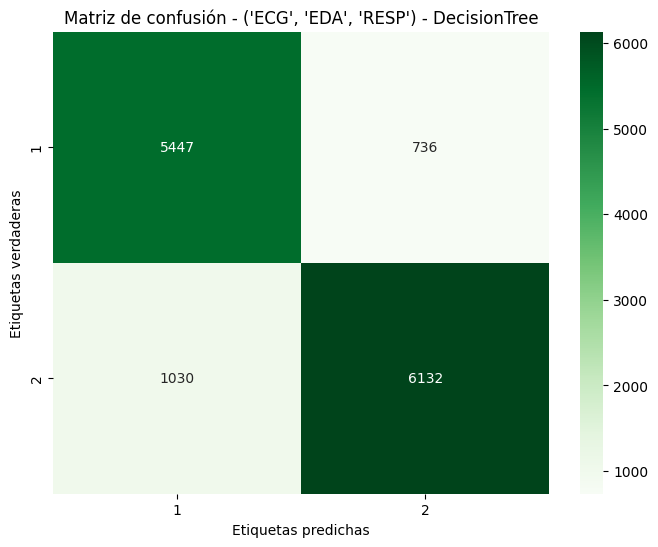

              precision    recall  f1-score   support

           1       0.84      0.88      0.86      6183
           2       0.89      0.86      0.87      7162

    accuracy                           0.87     13345
   macro avg       0.87      0.87      0.87     13345
weighted avg       0.87      0.87      0.87     13345

Training RandomForest model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'EDA', 'RESP') - RandomForest Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.999101  ('ECG', 'EDA', 'RESP') - RandomForest
1  Precision  0.999101  ('ECG', 'EDA', 'RESP') - RandomForest
2     Recall  0.999101  ('ECG', 'EDA', 'RESP') - RandomForest
3   F1 Score  0.999101  ('ECG', 'EDA', 'RESP') - RandomForest
[('ECG', 'EDA', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[('ECG', 'EDA', 'RESP'

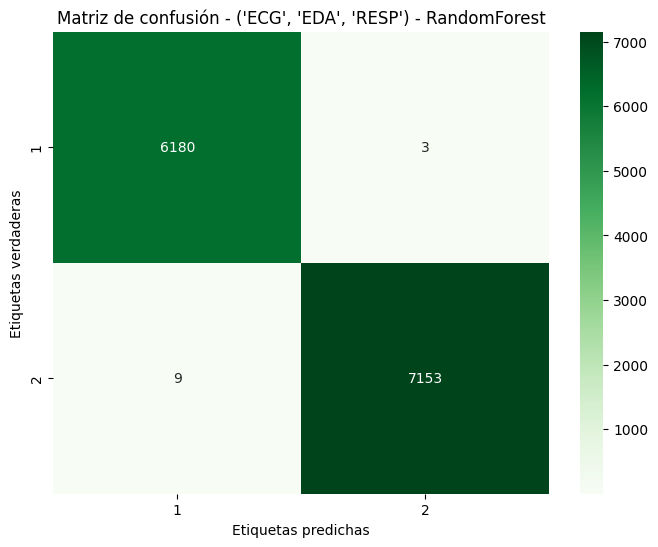

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                              Etapa
0   Accuracy  0.996853  ('ECG', 'EDA', 'RESP') - AdaBoost
1  Precision  0.996854  ('ECG', 'EDA', 'RESP') - AdaBoost
2     Recall  0.996853  ('ECG', 'EDA', 'RESP') - AdaBoost
3   F1 Score  0.996853  ('ECG', 'EDA', 'RESP') - AdaBoost
[('ECG', 'EDA', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('ECG', 'EDA', 'RESP') - AdaBoost] Accuracy: 0.

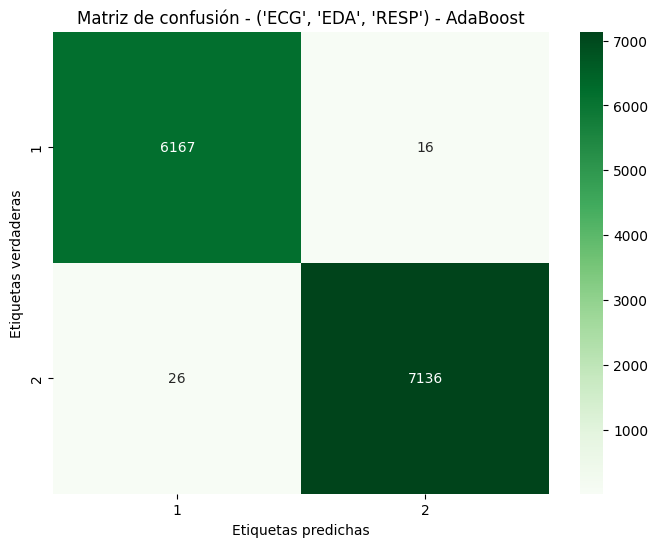

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training LDA model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'EDA', 'RESP') - LDA Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.724241  ('ECG', 'EDA', 'RESP') - LDA
1  Precision  0.723897  ('ECG', 'EDA', 'RESP') - LDA
2     Recall  0.724241  ('ECG', 'EDA', 'RESP') - LDA
3   F1 Score  0.723977  ('ECG', 'EDA', 'RESP') - LDA
[('ECG', 'EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'EDA', 'RESP') - LDA] Accuracy: 0.7242
('ECG', 'EDA', 'RESP') - LDA - Confusion Matrix
[[4268 1915]
 [1765 5397]]


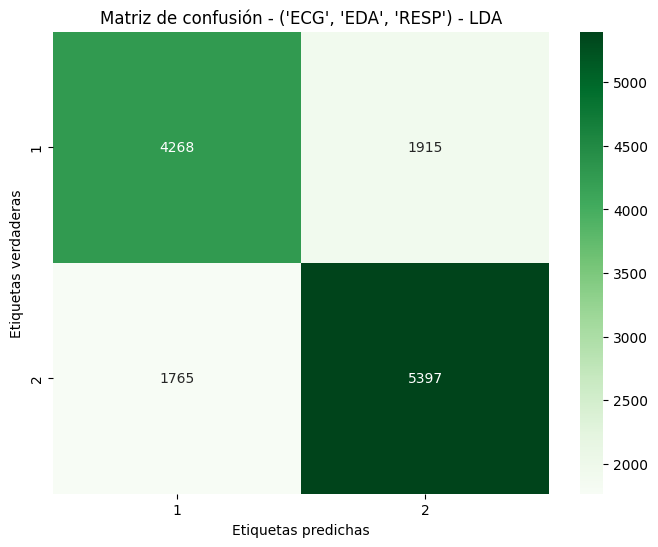

              precision    recall  f1-score   support

           1       0.71      0.69      0.70      6183
           2       0.74      0.75      0.75      7162

    accuracy                           0.72     13345
   macro avg       0.72      0.72      0.72     13345
weighted avg       0.72      0.72      0.72     13345

Training KNN model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'EDA', 'RESP') - KNN Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.733084  ('ECG', 'EDA', 'RESP') - KNN
1  Precision  0.732994  ('ECG', 'EDA', 'RESP') - KNN
2     Recall  0.733084  ('ECG', 'EDA', 'RESP') - KNN
3   F1 Score  0.733035  ('ECG', 'EDA', 'RESP') - KNN
[('ECG', 'EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[('ECG', 'EDA', 'RESP') - KNN] Accuracy: 0.7331
('ECG', 'EDA', 'RESP') - KNN - Confusion Matrix
[[4386 1797]
 [1765 5397]]


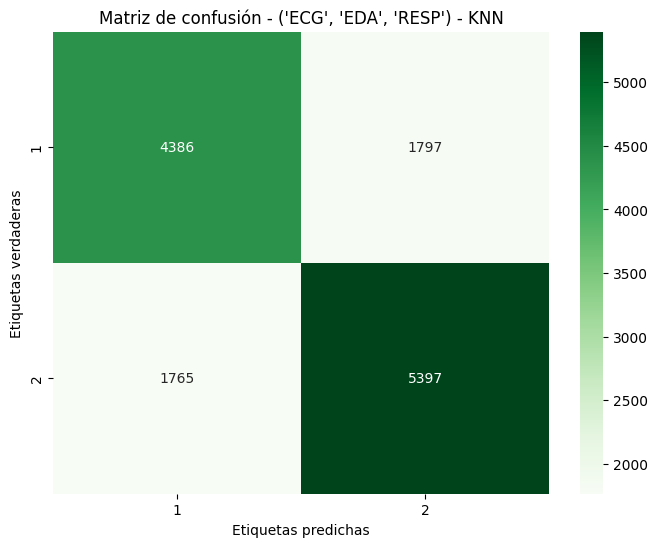

Training by signal combinations:  82%|████████▏ | 9/11 [14:35:45<3:31:08, 6334.34s/it]

              precision    recall  f1-score   support

           1       0.71      0.71      0.71      6183
           2       0.75      0.75      0.75      7162

    accuracy                           0.73     13345
   macro avg       0.73      0.73      0.73     13345
weighted avg       0.73      0.73      0.73     13345

Training DecisionTree model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('PPG', 'EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.900487  ('PPG', 'EDA', 'RESP') - DecisionTree
1  Precision  0.900736  ('PPG', 'EDA', 'RESP') - DecisionTree
2     Recall  0.900487  ('PPG', 'EDA', 'RESP') - DecisionTree
3   F1 Score  0.900543  ('PPG', 'EDA', 'RESP') - DecisionTree
[('PPG', 'EDA', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('PPG', 'EDA', 'RESP') - DecisionTree] Accurac

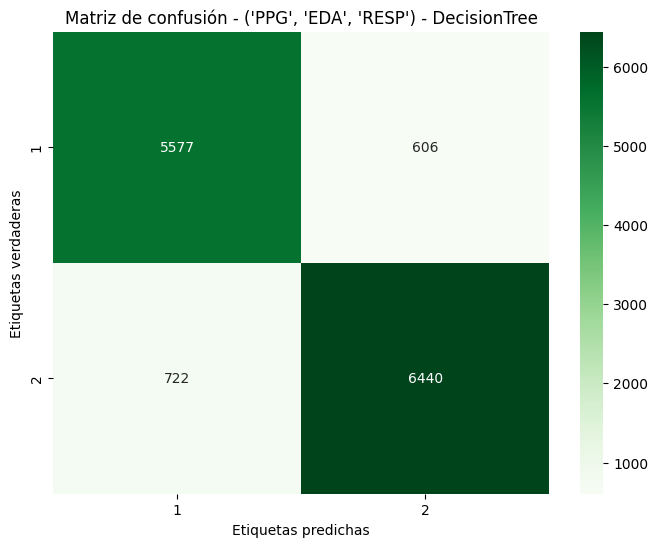

              precision    recall  f1-score   support

           1       0.89      0.90      0.89      6183
           2       0.91      0.90      0.91      7162

    accuracy                           0.90     13345
   macro avg       0.90      0.90      0.90     13345
weighted avg       0.90      0.90      0.90     13345

Training RandomForest model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('PPG', 'EDA', 'RESP') - RandomForest Metrics
     Métrica    Valor                                  Etapa
0   Accuracy  0.99985  ('PPG', 'EDA', 'RESP') - RandomForest
1  Precision  0.99985  ('PPG', 'EDA', 'RESP') - RandomForest
2     Recall  0.99985  ('PPG', 'EDA', 'RESP') - RandomForest
3   F1 Score  0.99985  ('PPG', 'EDA', 'RESP') - RandomForest
[('PPG', 'EDA', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
[('PPG', 'EDA', 'RESP') - R

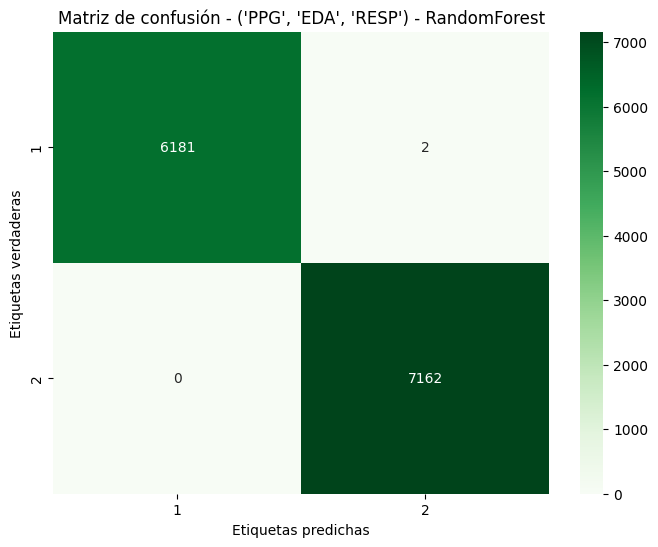

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('PPG', 'EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                              Etapa
0   Accuracy  0.999026  ('PPG', 'EDA', 'RESP') - AdaBoost
1  Precision  0.999026  ('PPG', 'EDA', 'RESP') - AdaBoost
2     Recall  0.999026  ('PPG', 'EDA', 'RESP') - AdaBoost
3   F1 Score  0.999026  ('PPG', 'EDA', 'RESP') - AdaBoost
[('PPG', 'EDA', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('PPG', 'EDA', 'RESP') - AdaBoost] Accuracy: 0.

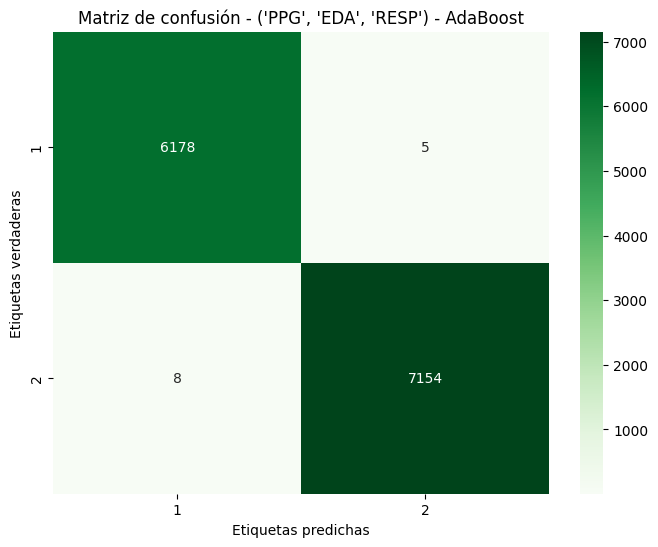

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training LDA model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('PPG', 'EDA', 'RESP') - LDA Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.818134  ('PPG', 'EDA', 'RESP') - LDA
1  Precision  0.819943  ('PPG', 'EDA', 'RESP') - LDA
2     Recall  0.818134  ('PPG', 'EDA', 'RESP') - LDA
3   F1 Score  0.817025  ('PPG', 'EDA', 'RESP') - LDA
[('PPG', 'EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('PPG', 'EDA', 'RESP') - LDA] Accuracy: 0.8181
('PPG', 'EDA', 'RESP') - LDA - Confusion Matrix
[[4642 1541]
 [ 886 6276]]


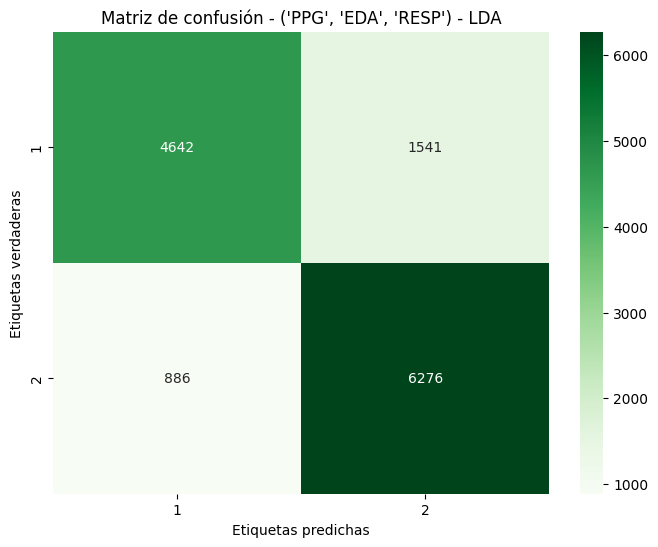

              precision    recall  f1-score   support

           1       0.84      0.75      0.79      6183
           2       0.80      0.88      0.84      7162

    accuracy                           0.82     13345
   macro avg       0.82      0.81      0.82     13345
weighted avg       0.82      0.82      0.82     13345

Training KNN model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('PPG', 'EDA', 'RESP') - KNN Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.995879  ('PPG', 'EDA', 'RESP') - KNN
1  Precision  0.995879  ('PPG', 'EDA', 'RESP') - KNN
2     Recall  0.995879  ('PPG', 'EDA', 'RESP') - KNN
3   F1 Score  0.995879  ('PPG', 'EDA', 'RESP') - KNN
[('PPG', 'EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('PPG', 'EDA', 'RESP') - KNN] Accuracy: 0.9959
('PPG', 'EDA', 'RESP') - KNN - Confusion Matrix
[[6155   28]
 [  27 7135]]


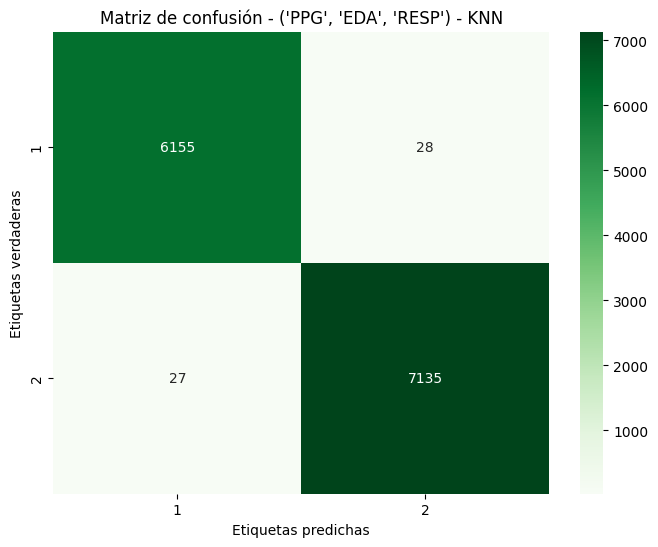

Training by signal combinations:  91%|█████████ | 10/11 [16:27:51<1:47:35, 6455.48s/it]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training DecisionTree model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                         Etapa
0   Accuracy  0.900862  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
1  Precision  0.901059  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
2     Recall  0.900862  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
3   F1 Score  0.900910  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
[('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_sp

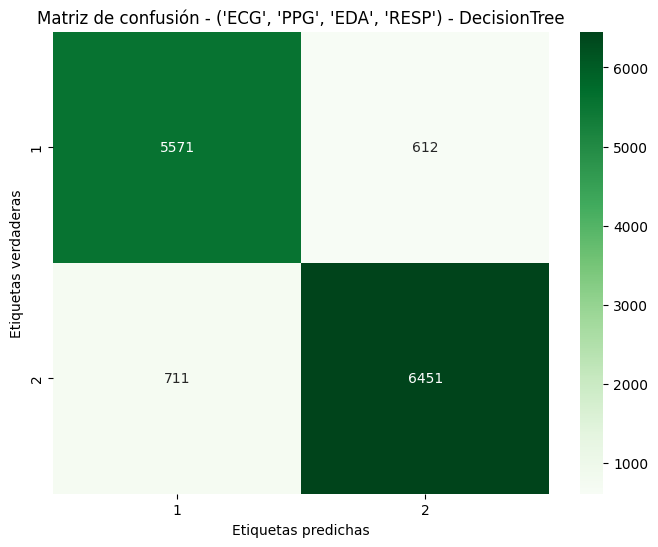

              precision    recall  f1-score   support

           1       0.89      0.90      0.89      6183
           2       0.91      0.90      0.91      7162

    accuracy                           0.90     13345
   macro avg       0.90      0.90      0.90     13345
weighted avg       0.90      0.90      0.90     13345

Training RandomForest model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG', 'EDA', 'RESP') - RandomForest Metrics
     Métrica    Valor                                         Etapa
0   Accuracy  0.99985  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
1  Precision  0.99985  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
2     Recall  0.99985  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
3   F1 Score  0.99985  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
[('ECG', 'PPG', 'EDA', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_spl

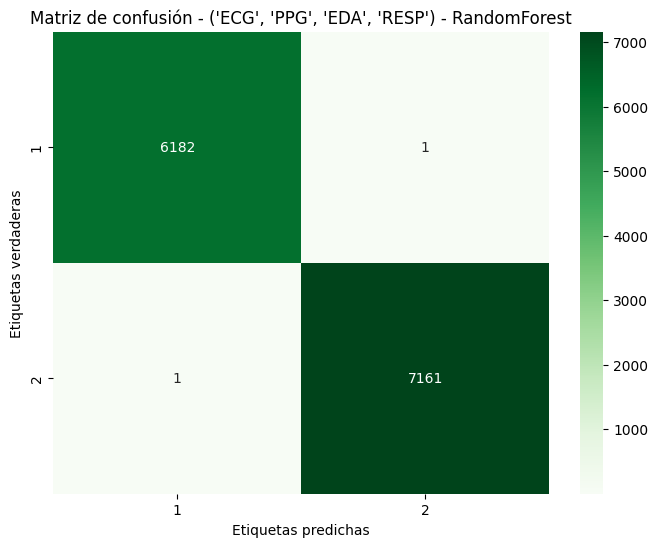

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                                     Etapa
0   Accuracy  0.999625  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
1  Precision  0.999625  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
2     Recall  0.999625  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
3   F1 Score  0.999625  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
[('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators

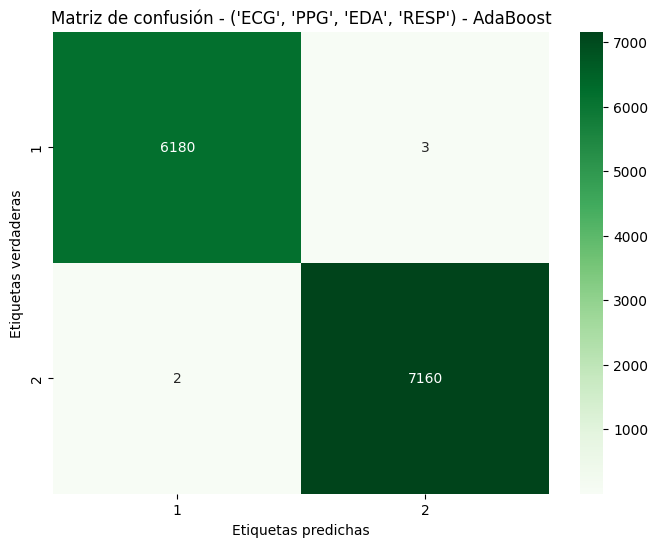

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6183
           2       1.00      1.00      1.00      7162

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training LDA model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG', 'EDA', 'RESP') - LDA Metrics
     Métrica     Valor                                Etapa
0   Accuracy  0.822630  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
1  Precision  0.824046  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
2     Recall  0.822630  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
3   F1 Score  0.821693  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
[('ECG', 'PPG', 'EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG', 'EDA', 'RESP') - LDA] Accuracy: 0.8226
('ECG', 'PPG', 'EDA', 'RESP') - LDA - Confusion Matrix
[[4704 1479]
 [ 888 6274

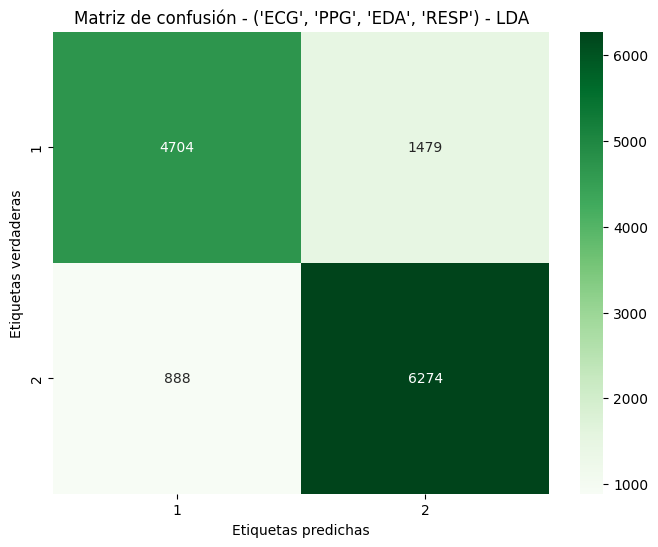

              precision    recall  f1-score   support

           1       0.84      0.76      0.80      6183
           2       0.81      0.88      0.84      7162

    accuracy                           0.82     13345
   macro avg       0.83      0.82      0.82     13345
weighted avg       0.82      0.82      0.82     13345

Training KNN model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG', 'EDA', 'RESP') - KNN Metrics
     Métrica     Valor                                Etapa
0   Accuracy  0.735481  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
1  Precision  0.735458  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
2     Recall  0.735481  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
3   F1 Score  0.735470  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
[('ECG', 'PPG', 'EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[('ECG', 'PPG', 'EDA', 'RESP') - KNN] Accuracy: 0.7355
('ECG', 'PPG', 'EDA', 'RESP') - KNN - Confusion Matrix

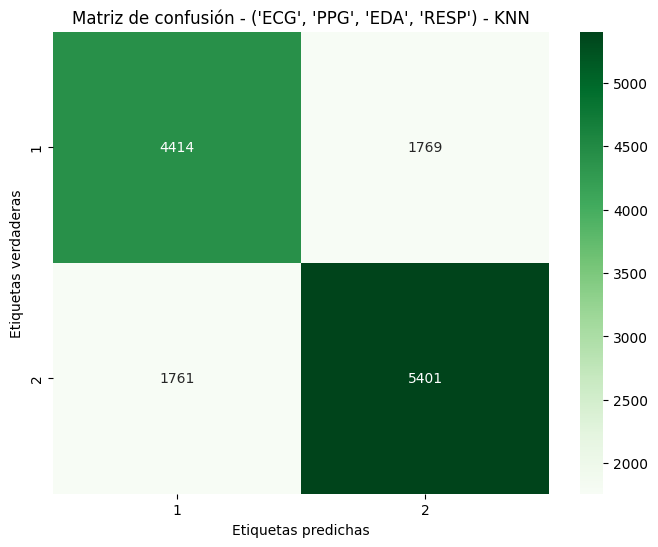

Training by signal combinations: 100%|██████████| 11/11 [18:43:46<00:00, 6129.68s/it]  

              precision    recall  f1-score   support

           1       0.71      0.71      0.71      6183
           2       0.75      0.75      0.75      7162

    accuracy                           0.74     13345
   macro avg       0.73      0.73      0.73     13345
weighted avg       0.74      0.74      0.74     13345


Final Comparison:
('ECG', 'PPG') - DecisionTree:
     Métrica     Valor                          Etapa
0   Accuracy  0.838291  ('ECG', 'PPG') - DecisionTree
1  Precision  0.838422  ('ECG', 'PPG') - DecisionTree
2     Recall  0.838291  ('ECG', 'PPG') - DecisionTree
3   F1 Score  0.837951  ('ECG', 'PPG') - DecisionTree
('ECG', 'PPG') - RandomForest:
     Métrica     Valor                          Etapa
0   Accuracy  0.993855  ('ECG', 'PPG') - RandomForest
1  Precision  0.993857  ('ECG', 'PPG') - RandomForest
2     Recall  0.993855  ('ECG', 'PPG') - RandomForest
3   F1 Score  0.993856  ('ECG', 'PPG') - RandomForest
('ECG', 'PPG') - AdaBoost:
     Métrica     Valor   

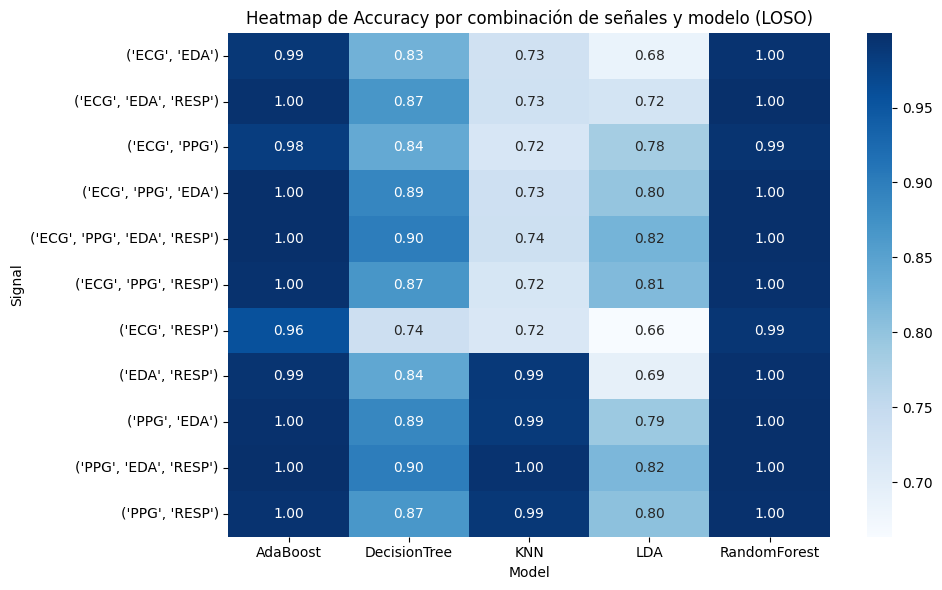

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
C:\Users\Gustavo\AppData\Local\Temp\ipyk

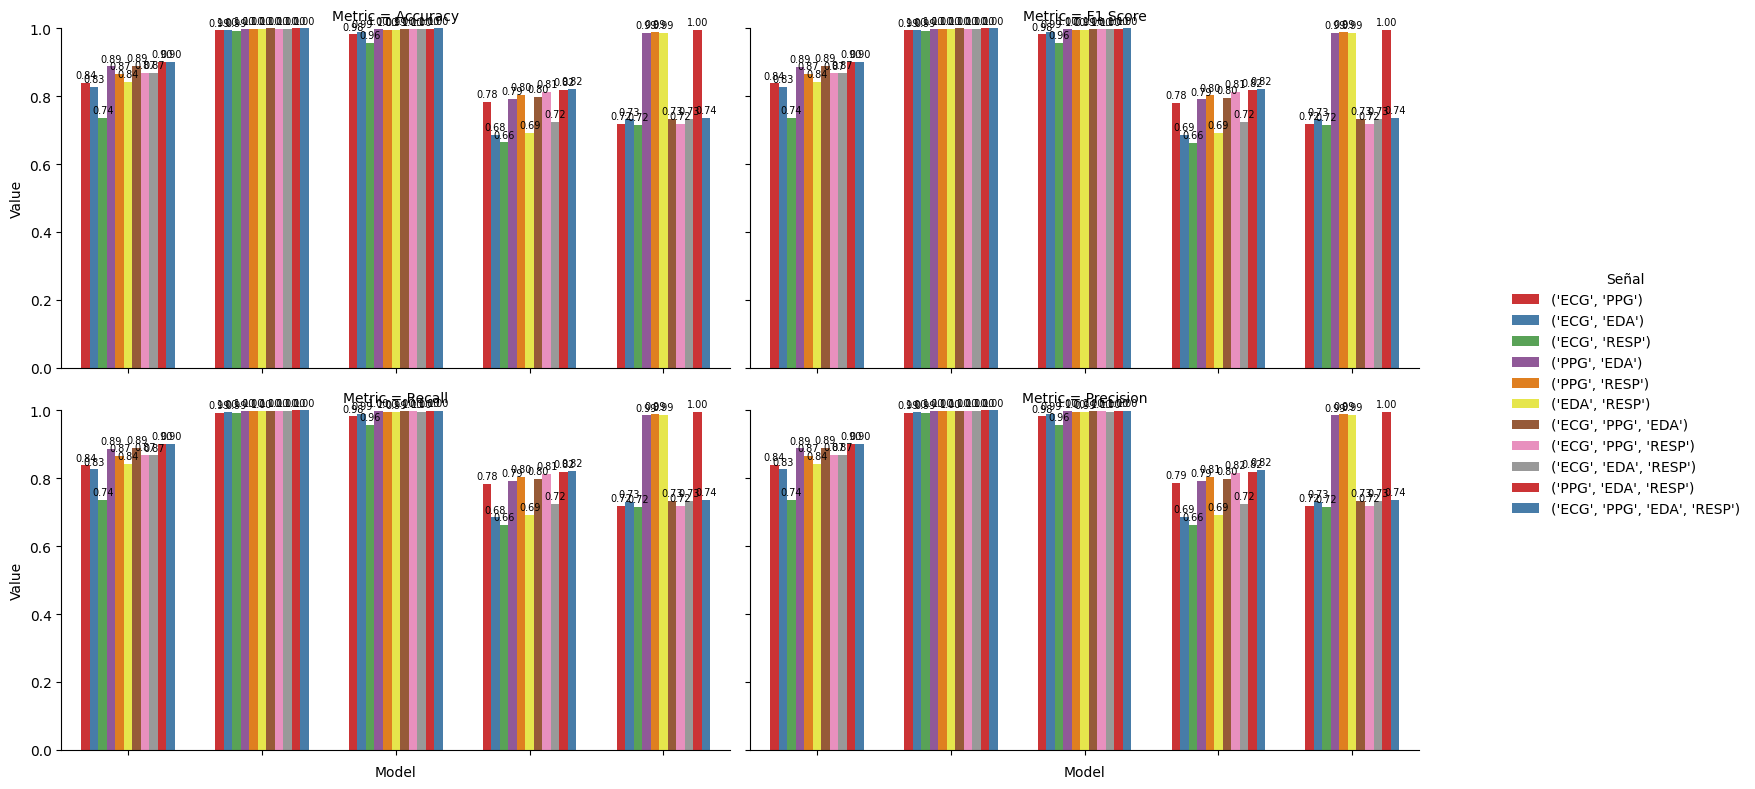

In [82]:
for combo in tqdm(combinations, desc="Training by signal combinations"):
    features = sum([SIGNAL_CATEGORIES[signal] for signal in combo], [])
    if all(f in df.columns for f in features):# Verificar que todas las columnas existen
        X = df[features]
        y = df['label']
        subjects = df['subject'] # Se agrega el identificador de sujetos para LOSO

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {combo} using LOSO...')
            metrics = train_and_evaluate(X, y, model, param_grid, model_name, combo)
        
            # Convertir diccionario de métricas a DataFrame con mismo formato que antes
            results[(combo, model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (combo, model_name), acc in results.items():
    print(f'{combo} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (combo, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']

    row = {
    'Signal': combo,
    'Model': model,
    'Accuracy': metric_values.get('Accuracy', None),
    'F1': metric_values.get('F1 Score', None),
    'Precision': metric_values.get('Precision', None),
    'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por combinación de señales y modelo (LOSO)')
plt.tight_layout()
plt.show()

data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (combo, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((combo, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


4-CLASIFICATION

In [83]:
file = r'features_30_075\features.csv'

df = load_data(file)
df = df.fillna(0)

In [84]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 21943
Label: 2 total: 8973
Label: 3 total: 21939
Label: 4 total: 13869


Training by signal:   0%|          | 0/4 [00:00<?, ?it/s]

Training DecisionTree model for ECG using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
ECG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.422405  ECG - DecisionTree
1  Precision  0.478494  ECG - DecisionTree
2     Recall  0.422405  ECG - DecisionTree
3   F1 Score  0.332208  ECG - DecisionTree
[ECG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 10, 'min_samples_split': 2}
[ECG - DecisionTree] Accuracy: 0.4224
ECG - DecisionTree - Confusion Matrix
[[4197    0  162   30]
 [1567    8  206   13]
 [2955   10 1277  146]
 [2180    1  438  155]]


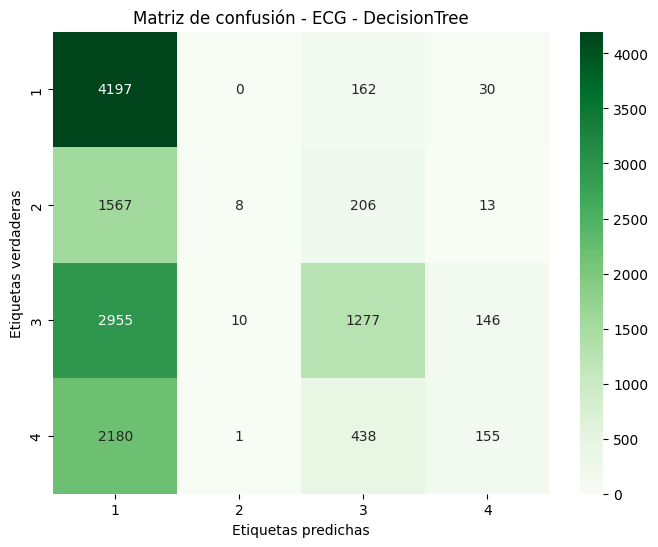

              precision    recall  f1-score   support

           1       0.39      0.96      0.55      4389
           2       0.42      0.00      0.01      1794
           3       0.61      0.29      0.39      4388
           4       0.45      0.06      0.10      2774

    accuracy                           0.42     13345
   macro avg       0.47      0.33      0.26     13345
weighted avg       0.48      0.42      0.33     13345

Training RandomForest model for ECG using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
ECG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.868865  ECG - RandomForest
1  Precision  0.870533  ECG - RandomForest
2     Recall  0.868865  ECG - RandomForest
3   F1 Score  0.868797  ECG - RandomForest
[ECG - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[ECG - RandomForest] Accuracy: 0.8689
ECG - RandomForest - Confusi

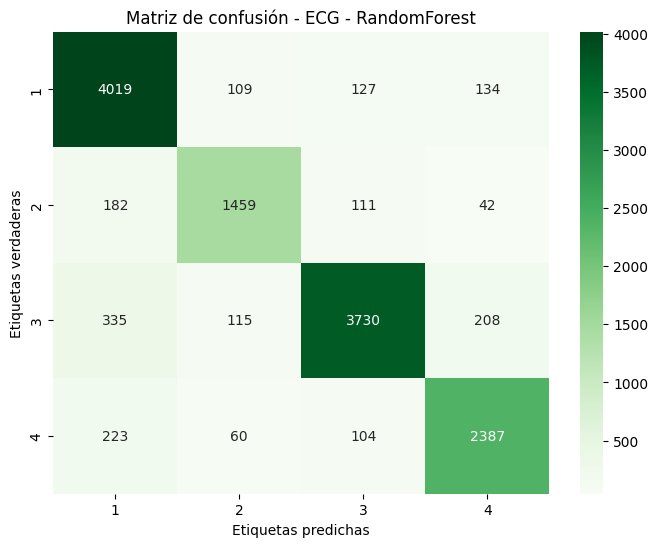

              precision    recall  f1-score   support

           1       0.84      0.92      0.88      4389
           2       0.84      0.81      0.82      1794
           3       0.92      0.85      0.88      4388
           4       0.86      0.86      0.86      2774

    accuracy                           0.87     13345
   macro avg       0.86      0.86      0.86     13345
weighted avg       0.87      0.87      0.87     13345

Training AdaBoost model for ECG using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ECG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.574447  ECG - AdaBoost
1  Precision  0.590911  ECG - AdaBoost
2     Recall  0.574447  ECG - AdaBoost
3   F1 Score  0.579224  ECG - AdaBoost
[ECG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[ECG - AdaBoost] Accuracy: 0.5744
ECG - AdaBoost - Confusion Matrix
[[2656  755  521  457]

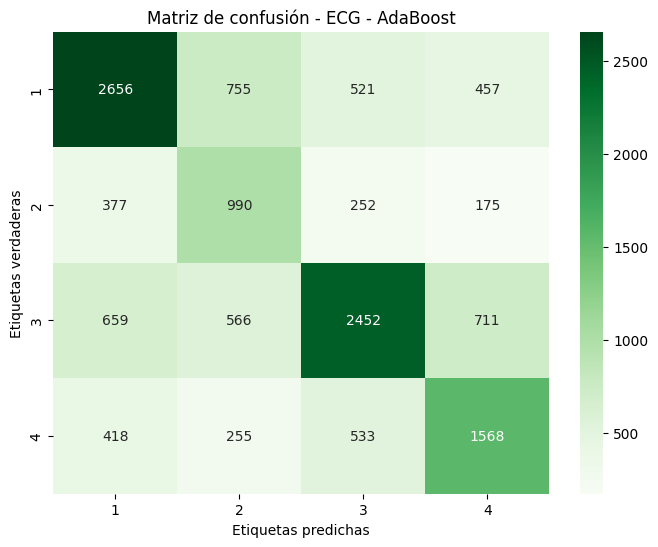

              precision    recall  f1-score   support

           1       0.65      0.61      0.63      4389
           2       0.39      0.55      0.45      1794
           3       0.65      0.56      0.60      4388
           4       0.54      0.57      0.55      2774

    accuracy                           0.57     13345
   macro avg       0.56      0.57      0.56     13345
weighted avg       0.59      0.57      0.58     13345

Training LDA model for ECG using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ECG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.420982  ECG - LDA
1  Precision  0.403216  ECG - LDA
2     Recall  0.420982  ECG - LDA
3   F1 Score  0.364223  ECG - LDA
[ECG - LDA] Best Params: {'solver': 'svd'}
[ECG - LDA] Accuracy: 0.4210
ECG - LDA - Confusion Matrix
[[3148   12 1017  212]
 [1083   10  618   83]
 [1952    7 2123  306]
 [1405    0 1032  337]]


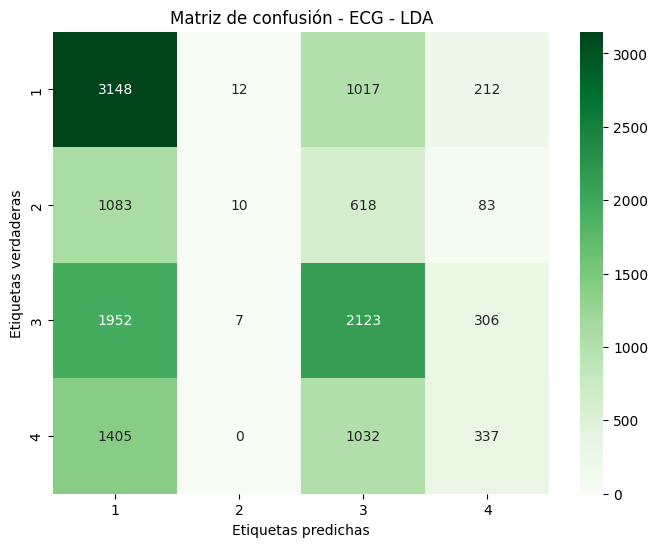

              precision    recall  f1-score   support

           1       0.41      0.72      0.53      4389
           2       0.34      0.01      0.01      1794
           3       0.44      0.48      0.46      4388
           4       0.36      0.12      0.18      2774

    accuracy                           0.42     13345
   macro avg       0.39      0.33      0.30     13345
weighted avg       0.40      0.42      0.36     13345

Training KNN model for ECG using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ECG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.557212  ECG - KNN
1  Precision  0.553460  ECG - KNN
2     Recall  0.557212  ECG - KNN
3   F1 Score  0.554461  ECG - KNN
[ECG - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[ECG - KNN] Accuracy: 0.5572
ECG - KNN - Confusion Matrix
[[2814  338  779  458]
 [ 490  698  371  235]
 [ 853  366 2653  516]
 [ 639  213  651 1271]]


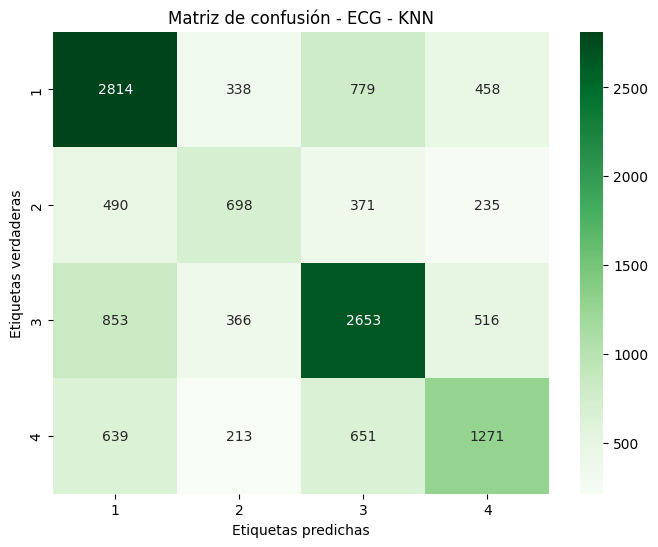

Training by signal:  25%|██▌       | 1/4 [1:08:54<3:26:43, 4134.64s/it]

              precision    recall  f1-score   support

           1       0.59      0.64      0.61      4389
           2       0.43      0.39      0.41      1794
           3       0.60      0.60      0.60      4388
           4       0.51      0.46      0.48      2774

    accuracy                           0.56     13345
   macro avg       0.53      0.52      0.53     13345
weighted avg       0.55      0.56      0.55     13345

Training DecisionTree model for PPG using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
PPG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.576845  PPG - DecisionTree
1  Precision  0.675865  PPG - DecisionTree
2     Recall  0.576845  PPG - DecisionTree
3   F1 Score  0.603362  PPG - DecisionTree
[PPG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[PPG - DecisionTree] Accuracy: 0.5768
PPG - DecisionTree - Confusion Matrix
[[2810 1050   6

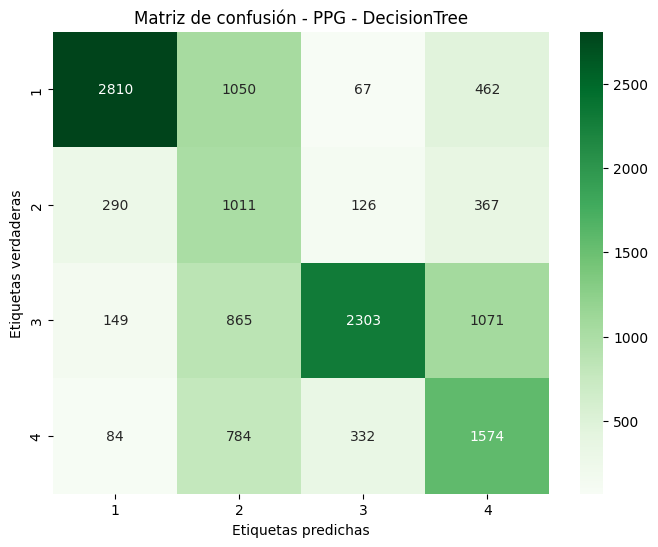

              precision    recall  f1-score   support

           1       0.84      0.64      0.73      4389
           2       0.27      0.56      0.37      1794
           3       0.81      0.52      0.64      4388
           4       0.45      0.57      0.50      2774

    accuracy                           0.58     13345
   macro avg       0.60      0.57      0.56     13345
weighted avg       0.68      0.58      0.60     13345

Training RandomForest model for PPG using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
PPG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.983140  PPG - RandomForest
1  Precision  0.983139  PPG - RandomForest
2     Recall  0.983140  PPG - RandomForest
3   F1 Score  0.983118  PPG - RandomForest
[PPG - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[PPG - RandomForest] Accuracy: 0.9831
PPG - RandomForest - Confusi

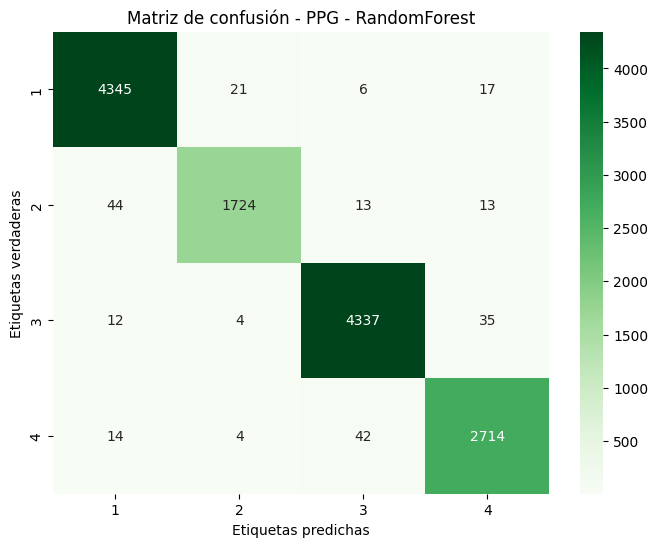

              precision    recall  f1-score   support

           1       0.98      0.99      0.99      4389
           2       0.98      0.96      0.97      1794
           3       0.99      0.99      0.99      4388
           4       0.98      0.98      0.98      2774

    accuracy                           0.98     13345
   macro avg       0.98      0.98      0.98     13345
weighted avg       0.98      0.98      0.98     13345

Training AdaBoost model for PPG using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
PPG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.726265  PPG - AdaBoost
1  Precision  0.748118  PPG - AdaBoost
2     Recall  0.726265  PPG - AdaBoost
3   F1 Score  0.732077  PPG - AdaBoost
[PPG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[PPG - AdaBoost] Accuracy: 0.7263
PPG - AdaBoost - Confusion Matrix
[[3636  545   85  123]

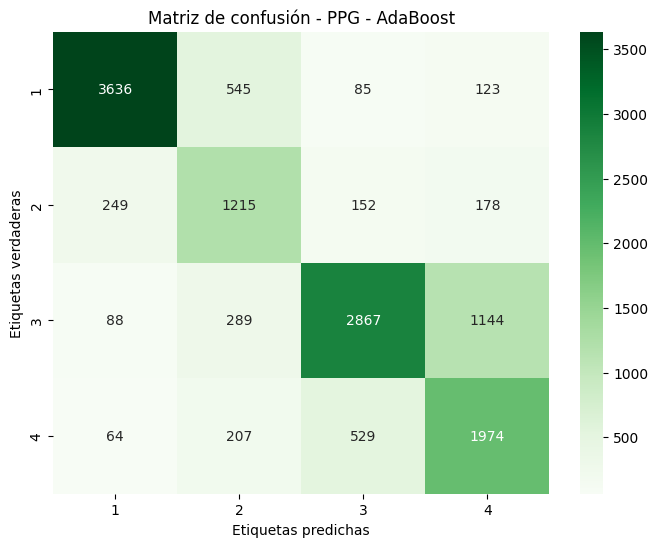

              precision    recall  f1-score   support

           1       0.90      0.83      0.86      4389
           2       0.54      0.68      0.60      1794
           3       0.79      0.65      0.71      4388
           4       0.58      0.71      0.64      2774

    accuracy                           0.73     13345
   macro avg       0.70      0.72      0.70     13345
weighted avg       0.75      0.73      0.73     13345

Training LDA model for PPG using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
PPG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.562533  PPG - LDA
1  Precision  0.524057  PPG - LDA
2     Recall  0.562533  PPG - LDA
3   F1 Score  0.509478  PPG - LDA
[PPG - LDA] Best Params: {'solver': 'svd'}
[PPG - LDA] Accuracy: 0.5625
PPG - LDA - Confusion Matrix
[[3367   14  558  450]
 [ 771   17  638  368]
 [ 427    5 3433  523]
 [ 517    7 1560  690]]


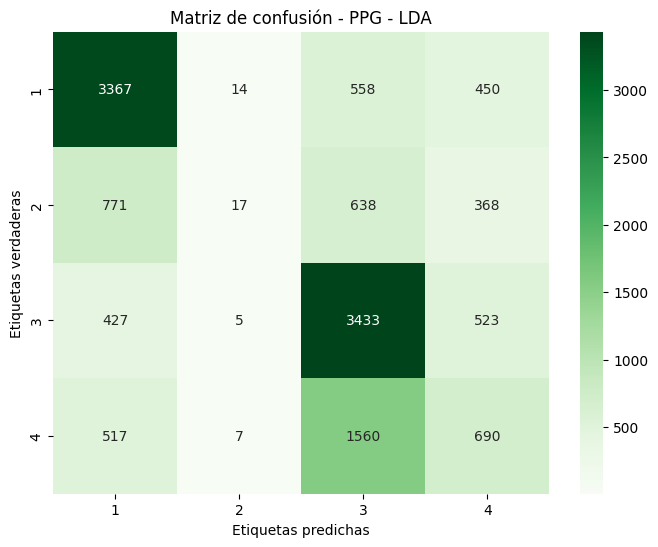

              precision    recall  f1-score   support

           1       0.66      0.77      0.71      4389
           2       0.40      0.01      0.02      1794
           3       0.55      0.78      0.65      4388
           4       0.34      0.25      0.29      2774

    accuracy                           0.56     13345
   macro avg       0.49      0.45      0.42     13345
weighted avg       0.52      0.56      0.51     13345

Training KNN model for PPG using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
PPG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.849082  PPG - KNN
1  Precision  0.848407  PPG - KNN
2     Recall  0.849082  PPG - KNN
3   F1 Score  0.848692  PPG - KNN
[PPG - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[PPG - KNN] Accuracy: 0.8491
PPG - KNN - Confusion Matrix
[[3918  157  158  156]
 [ 187 1333  141  133]
 [ 161  126 3874  227]
 [ 176  130  262 2206]]


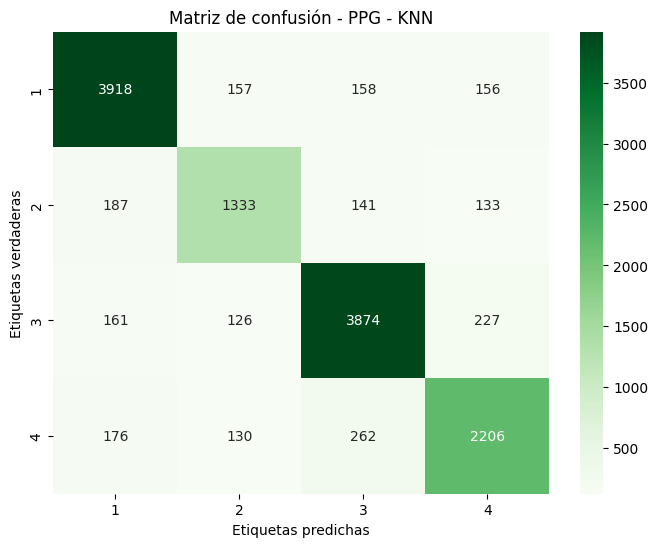

Training by signal:  50%|█████     | 2/4 [2:18:34<2:18:42, 4161.09s/it]

              precision    recall  f1-score   support

           1       0.88      0.89      0.89      4389
           2       0.76      0.74      0.75      1794
           3       0.87      0.88      0.88      4388
           4       0.81      0.80      0.80      2774

    accuracy                           0.85     13345
   macro avg       0.83      0.83      0.83     13345
weighted avg       0.85      0.85      0.85     13345

Training DecisionTree model for EDA using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
EDA - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.534283  EDA - DecisionTree
1  Precision  0.574228  EDA - DecisionTree
2     Recall  0.534283  EDA - DecisionTree
3   F1 Score  0.543069  EDA - DecisionTree
[EDA - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[EDA - DecisionTree] Accuracy: 0.5343
EDA - DecisionTree - Confusion Matrix
[[2714  712  46

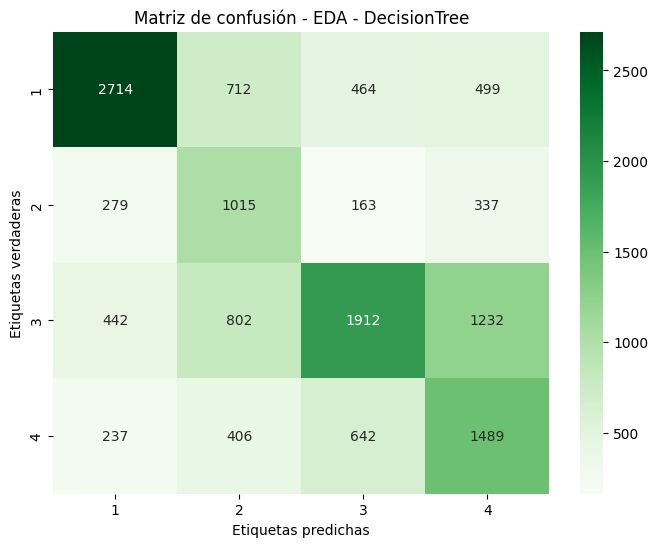

              precision    recall  f1-score   support

           1       0.74      0.62      0.67      4389
           2       0.35      0.57      0.43      1794
           3       0.60      0.44      0.51      4388
           4       0.42      0.54      0.47      2774

    accuracy                           0.53     13345
   macro avg       0.53      0.54      0.52     13345
weighted avg       0.57      0.53      0.54     13345

Training RandomForest model for EDA using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
EDA - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.975571  EDA - RandomForest
1  Precision  0.975612  EDA - RandomForest
2     Recall  0.975571  EDA - RandomForest
3   F1 Score  0.975570  EDA - RandomForest
[EDA - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[EDA - RandomForest] Accuracy: 0.9756
EDA - RandomForest - Confusi

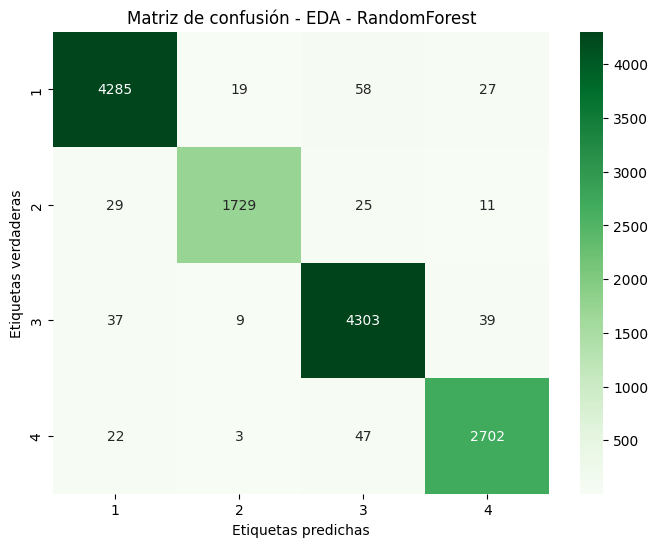

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      4389
           2       0.98      0.96      0.97      1794
           3       0.97      0.98      0.98      4388
           4       0.97      0.97      0.97      2774

    accuracy                           0.98     13345
   macro avg       0.98      0.97      0.97     13345
weighted avg       0.98      0.98      0.98     13345

Training AdaBoost model for EDA using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
EDA - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.671413  EDA - AdaBoost
1  Precision  0.686601  EDA - AdaBoost
2     Recall  0.671413  EDA - AdaBoost
3   F1 Score  0.675033  EDA - AdaBoost
[EDA - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[EDA - AdaBoost] Accuracy: 0.6714
EDA - AdaBoost - Confusion Matrix
[[2932  707  459  291]

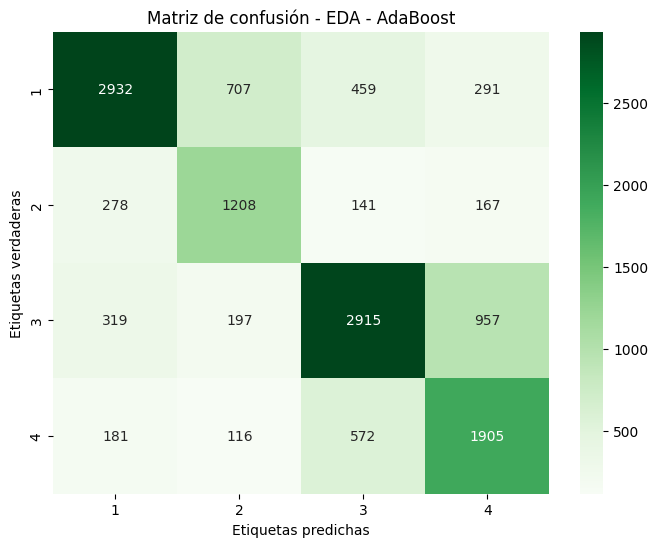

              precision    recall  f1-score   support

           1       0.79      0.67      0.72      4389
           2       0.54      0.67      0.60      1794
           3       0.71      0.66      0.69      4388
           4       0.57      0.69      0.63      2774

    accuracy                           0.67     13345
   macro avg       0.65      0.67      0.66     13345
weighted avg       0.69      0.67      0.68     13345

Training LDA model for EDA using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
EDA - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.417385  EDA - LDA
1  Precision  0.371065  EDA - LDA
2     Recall  0.417385  EDA - LDA
3   F1 Score  0.348455  EDA - LDA
[EDA - LDA] Best Params: {'solver': 'svd'}
[EDA - LDA] Accuracy: 0.4174
EDA - LDA - Confusion Matrix
[[3225    0 1011  153]
 [ 988    1  732   73]
 [2077    0 2160  151]
 [1216    4 1370  184]]


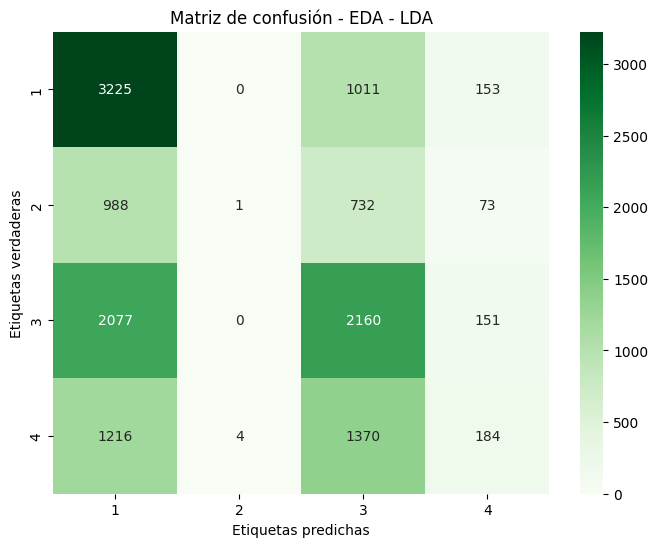

              precision    recall  f1-score   support

           1       0.43      0.73      0.54      4389
           2       0.20      0.00      0.00      1794
           3       0.41      0.49      0.45      4388
           4       0.33      0.07      0.11      2774

    accuracy                           0.42     13345
   macro avg       0.34      0.32      0.28     13345
weighted avg       0.37      0.42      0.35     13345

Training KNN model for EDA using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
EDA - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.898164  EDA - KNN
1  Precision  0.898070  EDA - KNN
2     Recall  0.898164  EDA - KNN
3   F1 Score  0.898105  EDA - KNN
[EDA - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[EDA - KNN] Accuracy: 0.8982
EDA - KNN - Confusion Matrix
[[4023   85  172  109]
 [ 120 1543   73   58]
 [ 156   81 3993  158]
 [  98   63  186 2427]]


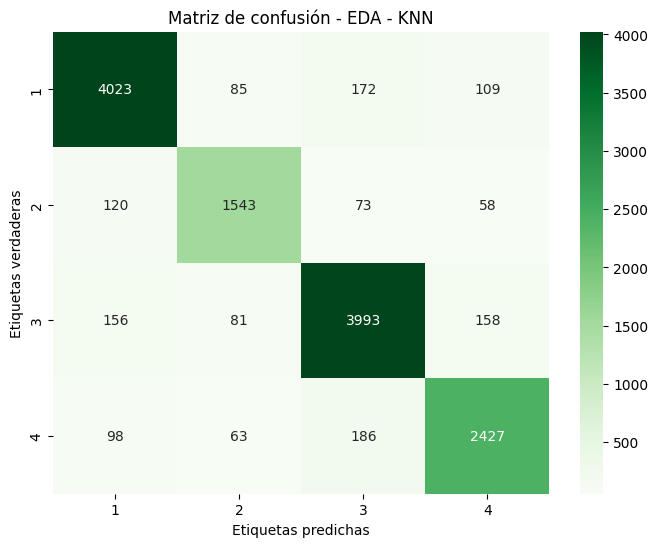

Training by signal:  75%|███████▌  | 3/4 [3:12:49<1:02:27, 3747.28s/it]

              precision    recall  f1-score   support

           1       0.91      0.92      0.92      4389
           2       0.87      0.86      0.87      1794
           3       0.90      0.91      0.91      4388
           4       0.88      0.87      0.88      2774

    accuracy                           0.90     13345
   macro avg       0.89      0.89      0.89     13345
weighted avg       0.90      0.90      0.90     13345

Training DecisionTree model for RESP using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
RESP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.457924  RESP - DecisionTree
1  Precision  0.476501  RESP - DecisionTree
2     Recall  0.457924  RESP - DecisionTree
3   F1 Score  0.462612  RESP - DecisionTree
[RESP - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[RESP - DecisionTree] Accuracy: 0.4579
RESP - DecisionTree - Confusion Matrix
[[194

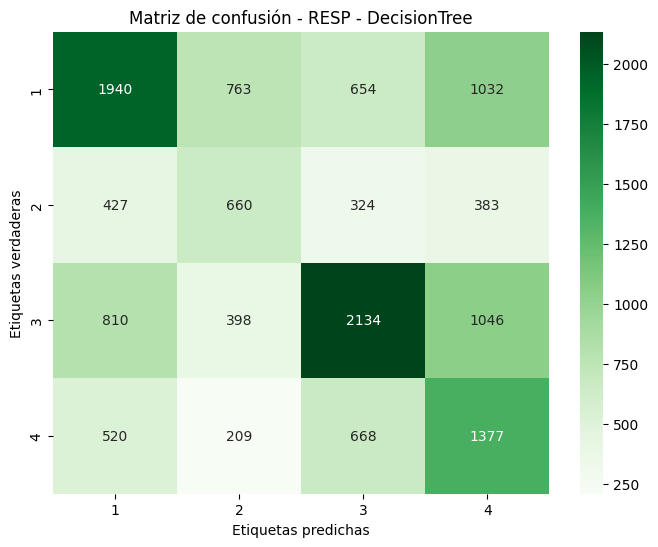

              precision    recall  f1-score   support

           1       0.52      0.44      0.48      4389
           2       0.33      0.37      0.35      1794
           3       0.56      0.49      0.52      4388
           4       0.36      0.50      0.42      2774

    accuracy                           0.46     13345
   macro avg       0.44      0.45      0.44     13345
weighted avg       0.48      0.46      0.46     13345

Training RandomForest model for RESP using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
RESP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.967853  RESP - RandomForest
1  Precision  0.967964  RESP - RandomForest
2     Recall  0.967853  RESP - RandomForest
3   F1 Score  0.967849  RESP - RandomForest
[RESP - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[RESP - RandomForest] Accuracy: 0.9679
RESP - RandomForest

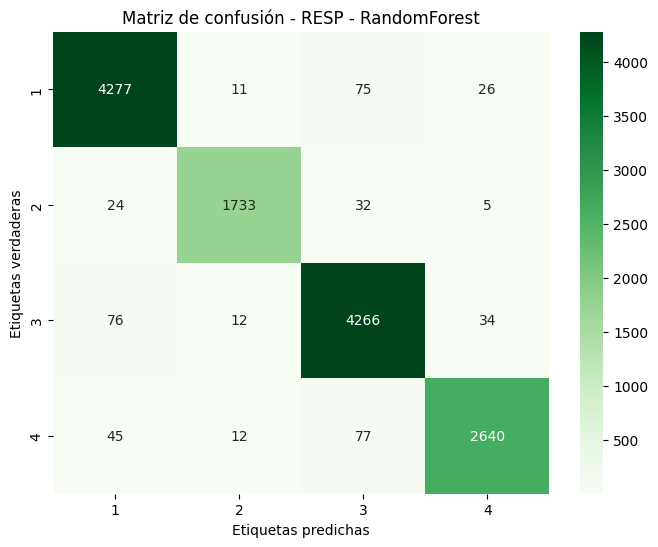

              precision    recall  f1-score   support

           1       0.97      0.97      0.97      4389
           2       0.98      0.97      0.97      1794
           3       0.96      0.97      0.97      4388
           4       0.98      0.95      0.96      2774

    accuracy                           0.97     13345
   macro avg       0.97      0.97      0.97     13345
weighted avg       0.97      0.97      0.97     13345

Training AdaBoost model for RESP using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
RESP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.649457  RESP - AdaBoost
1  Precision  0.650306  RESP - AdaBoost
2     Recall  0.649457  RESP - AdaBoost
3   F1 Score  0.648892  RESP - AdaBoost
[RESP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[RESP - AdaBoost] Accuracy: 0.6495
RESP - AdaBoost - Confusion Matrix
[[2820  393 

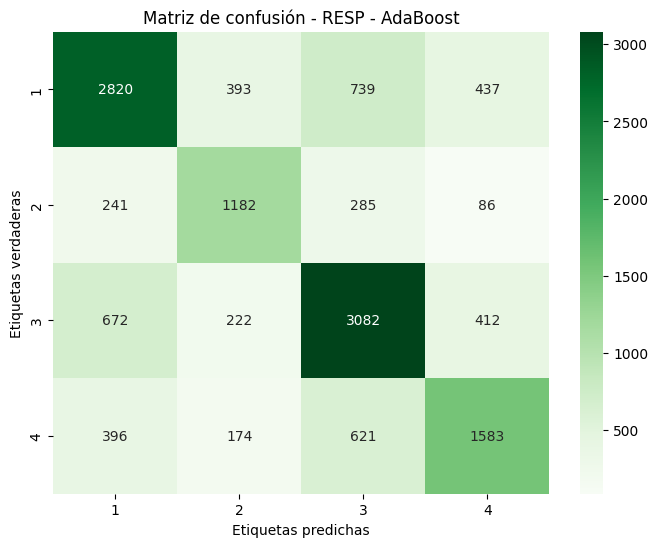

              precision    recall  f1-score   support

           1       0.68      0.64      0.66      4389
           2       0.60      0.66      0.63      1794
           3       0.65      0.70      0.68      4388
           4       0.63      0.57      0.60      2774

    accuracy                           0.65     13345
   macro avg       0.64      0.64      0.64     13345
weighted avg       0.65      0.65      0.65     13345

Training LDA model for RESP using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
RESP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.439940  RESP - LDA
1  Precision  0.499800  RESP - LDA
2     Recall  0.439940  RESP - LDA
3   F1 Score  0.365192  RESP - LDA
[RESP - LDA] Best Params: {'solver': 'svd'}
[RESP - LDA] Accuracy: 0.4399
RESP - LDA - Confusion Matrix
[[2930    0 1357  102]
 [1152    0  592   50]
 [1483    0 2813   92]
 [1611    0 1035  128]]


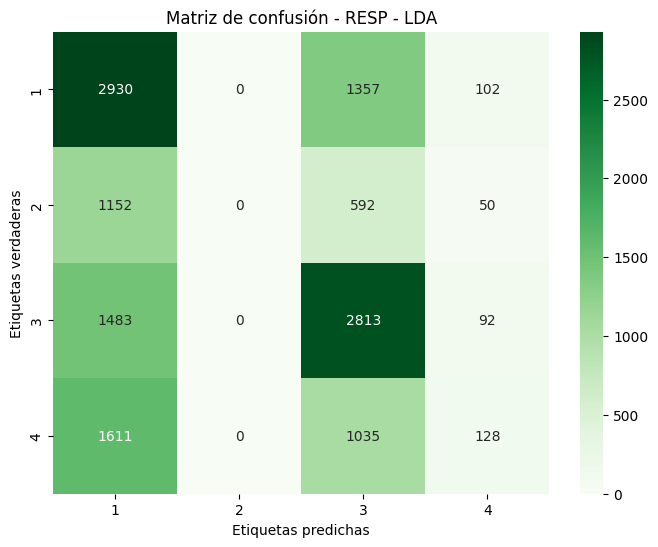

              precision    recall  f1-score   support

           1       0.41      0.67      0.51      4389
           2       0.00      0.00      0.00      1794
           3       0.49      0.64      0.55      4388
           4       0.34      0.05      0.08      2774

    accuracy                           0.44     13345
   macro avg       0.31      0.34      0.29     13345
weighted avg       0.37      0.44      0.37     13345

Training KNN model for RESP using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RESP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.964556  RESP - KNN
1  Precision  0.964593  RESP - KNN
2     Recall  0.964556  RESP - KNN
3   F1 Score  0.964551  RESP - KNN
[RESP - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[RESP - KNN] Accuracy: 0.9646
RESP - KNN - Confusion Matrix
[[4282   20   48   39]
 [  16 1729   23   26]
 [  83   32 4213   60]
 [  55   24   47 2648]]


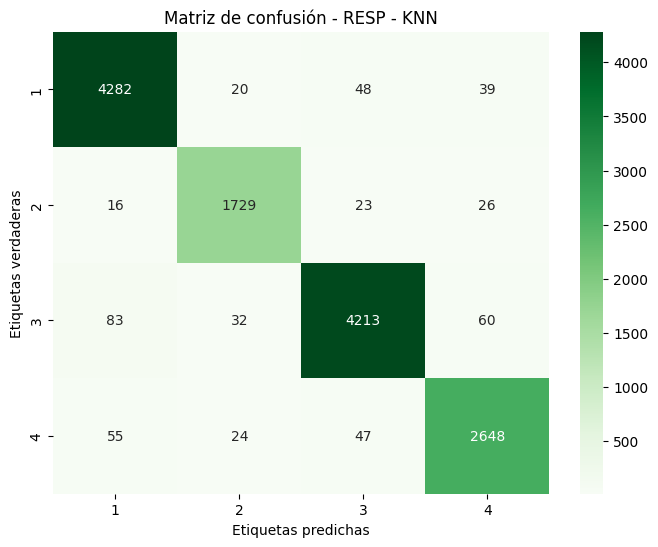

Training by signal: 100%|██████████| 4/4 [4:04:51<00:00, 3672.92s/it]  


              precision    recall  f1-score   support

           1       0.97      0.98      0.97      4389
           2       0.96      0.96      0.96      1794
           3       0.97      0.96      0.97      4388
           4       0.95      0.95      0.95      2774

    accuracy                           0.96     13345
   macro avg       0.96      0.96      0.96     13345
weighted avg       0.96      0.96      0.96     13345



Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.662121  ALL - DecisionTree
1  Precision  0.701403  ALL - DecisionTree
2     Recall  0.662121  ALL - DecisionTree
3   F1 Score  0.668136  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[ALL - DecisionTree] Accuracy: 0.6621
ALL - DecisionTree - Confusion Matrix
[[3629  500   64  196]
 [ 306  991  124  373]
 [ 171  524 2274 1419]
 [ 104  283  445 1942]]


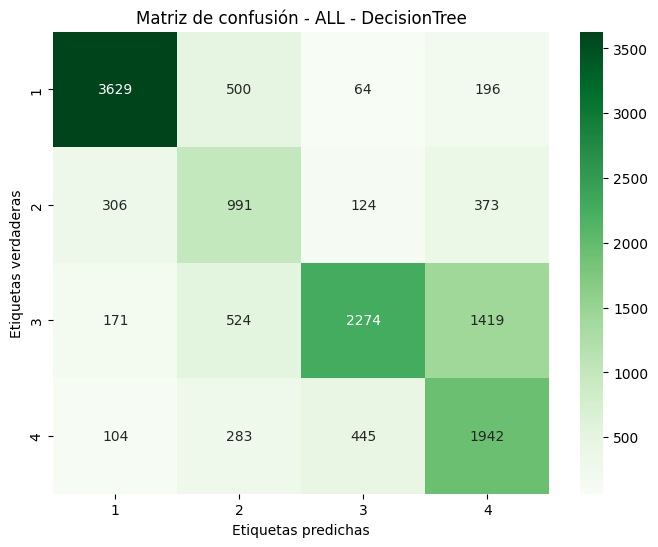

Training with ALL signals:  20%|██        | 1/5 [02:31<10:05, 151.40s/it]

              precision    recall  f1-score   support

           1       0.86      0.83      0.84      4389
           2       0.43      0.55      0.48      1794
           3       0.78      0.52      0.62      4388
           4       0.49      0.70      0.58      2774

    accuracy                           0.66     13345
   macro avg       0.64      0.65      0.63     13345
weighted avg       0.70      0.66      0.67     13345

Training RandomForest model for ALL signals using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
ALL - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.999026  ALL - RandomForest
1  Precision  0.999026  ALL - RandomForest
2     Recall  0.999026  ALL - RandomForest
3   F1 Score  0.999026  ALL - RandomForest
[ALL - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
[ALL - RandomForest] Accuracy: 0.9990
ALL - RandomForest -

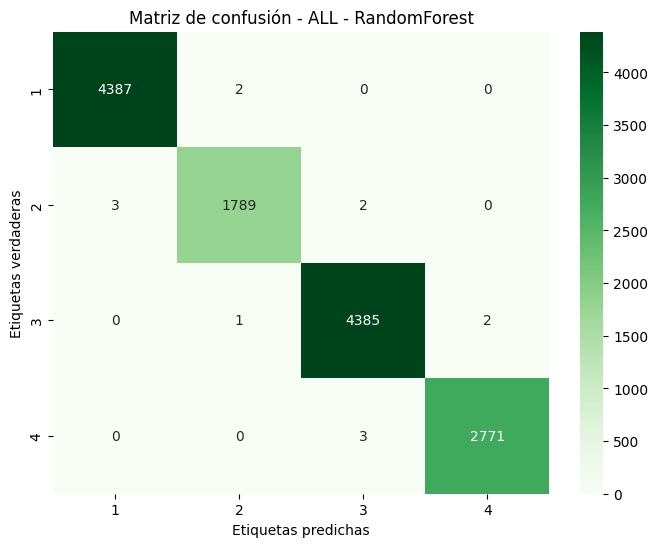

Training with ALL signals:  40%|████      | 2/5 [1:31:20<2:39:52, 3197.38s/it]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      1.00      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ALL signals using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ALL - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.830199  ALL - AdaBoost
1  Precision  0.832783  ALL - AdaBoost
2     Recall  0.830199  ALL - AdaBoost
3   F1 Score  0.830476  ALL - AdaBoost
[ALL - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[ALL - AdaBoost] Accuracy: 0.8302
ALL - AdaBoost - Confusion Matrix
[[4049  329    2

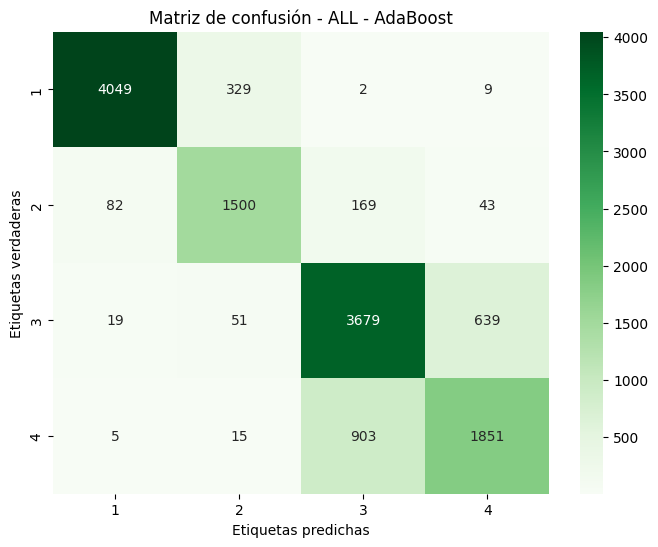

Training with ALL signals:  60%|██████    | 3/5 [2:21:08<1:43:23, 3101.54s/it]

              precision    recall  f1-score   support

           1       0.97      0.92      0.95      4389
           2       0.79      0.84      0.81      1794
           3       0.77      0.84      0.80      4388
           4       0.73      0.67      0.70      2774

    accuracy                           0.83     13345
   macro avg       0.82      0.82      0.82     13345
weighted avg       0.83      0.83      0.83     13345

Training LDA model for ALL signals using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ALL - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.629449  ALL - LDA
1  Precision  0.610578  ALL - LDA
2     Recall  0.629449  ALL - LDA
3   F1 Score  0.604154  ALL - LDA
[ALL - LDA] Best Params: {'solver': 'svd'}
[ALL - LDA] Accuracy: 0.6294
ALL - LDA - Confusion Matrix
[[3632   99  253  405]
 [ 732  256  425  381]
 [ 293   61 3307  727]
 [ 420   95 1054 1205]]


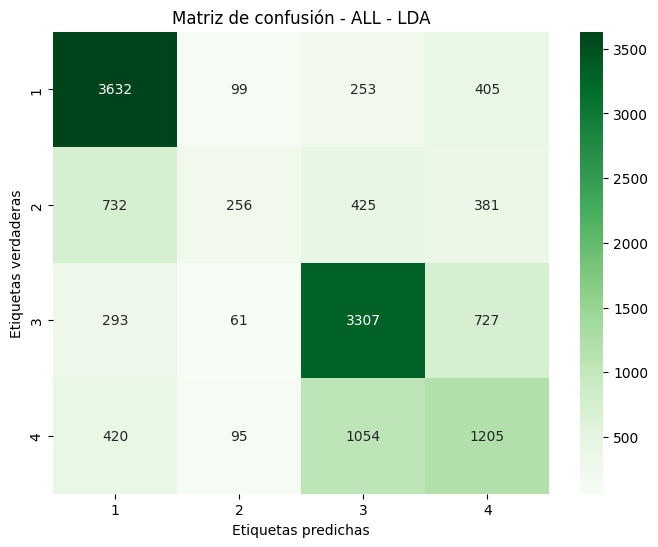

Training with ALL signals:  80%|████████  | 4/5 [2:21:12<31:18, 1878.72s/it]  

              precision    recall  f1-score   support

           1       0.72      0.83      0.77      4389
           2       0.50      0.14      0.22      1794
           3       0.66      0.75      0.70      4388
           4       0.44      0.43      0.44      2774

    accuracy                           0.63     13345
   macro avg       0.58      0.54      0.53     13345
weighted avg       0.61      0.63      0.60     13345

Training KNN model for ALL signals using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ALL - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.589809  ALL - KNN
1  Precision  0.586069  ALL - KNN
2     Recall  0.589809  ALL - KNN
3   F1 Score  0.587023  ALL - KNN
[ALL - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[ALL - KNN] Accuracy: 0.5898
ALL - KNN - Confusion Matrix
[[2995  309  687  398]
 [ 461  751  356  226]
 [ 783  344 2755  506]
 [ 564  202  638 1370]]


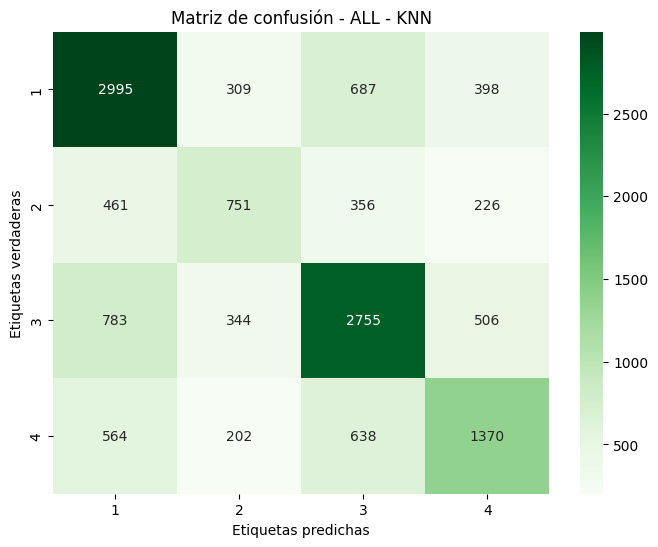

Training with ALL signals: 100%|██████████| 5/5 [2:21:23<00:00, 1696.77s/it]

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      4389
           2       0.47      0.42      0.44      1794
           3       0.62      0.63      0.62      4388
           4       0.55      0.49      0.52      2774

    accuracy                           0.59     13345
   macro avg       0.57      0.56      0.56     13345
weighted avg       0.59      0.59      0.59     13345


Final Comparison:
ECG - DecisionTree:
     Métrica     Valor               Etapa
0   Accuracy  0.422405  ECG - DecisionTree
1  Precision  0.478494  ECG - DecisionTree
2     Recall  0.422405  ECG - DecisionTree
3   F1 Score  0.332208  ECG - DecisionTree
ECG - RandomForest:
     Métrica     Valor               Etapa
0   Accuracy  0.868865  ECG - RandomForest
1  Precision  0.870533  ECG - RandomForest
2     Recall  0.868865  ECG - RandomForest
3   F1 Score  0.868797  ECG - RandomForest
ECG - AdaBoost:
     Métrica     Valor           Etapa
0   Accuracy  0.57444

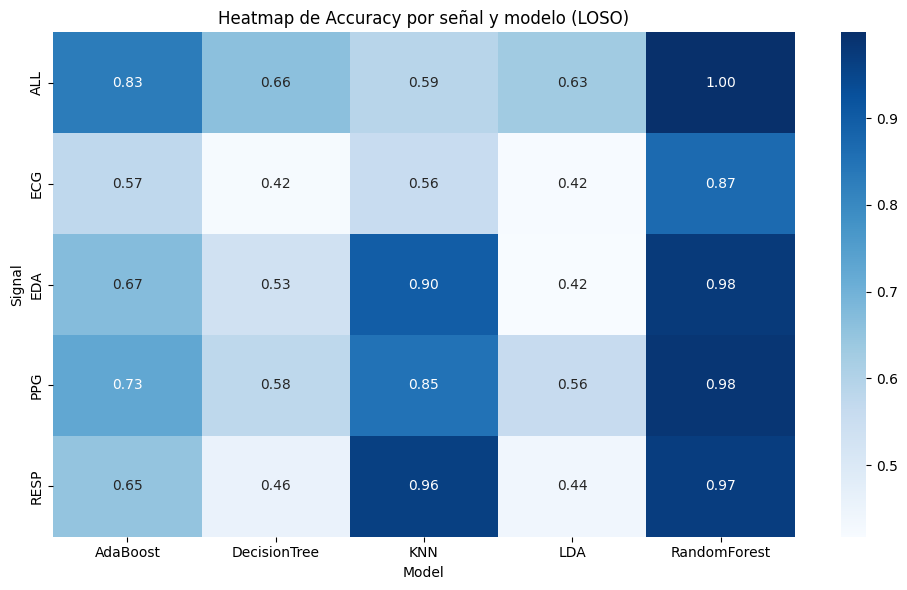

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_15152\2680508847.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xti

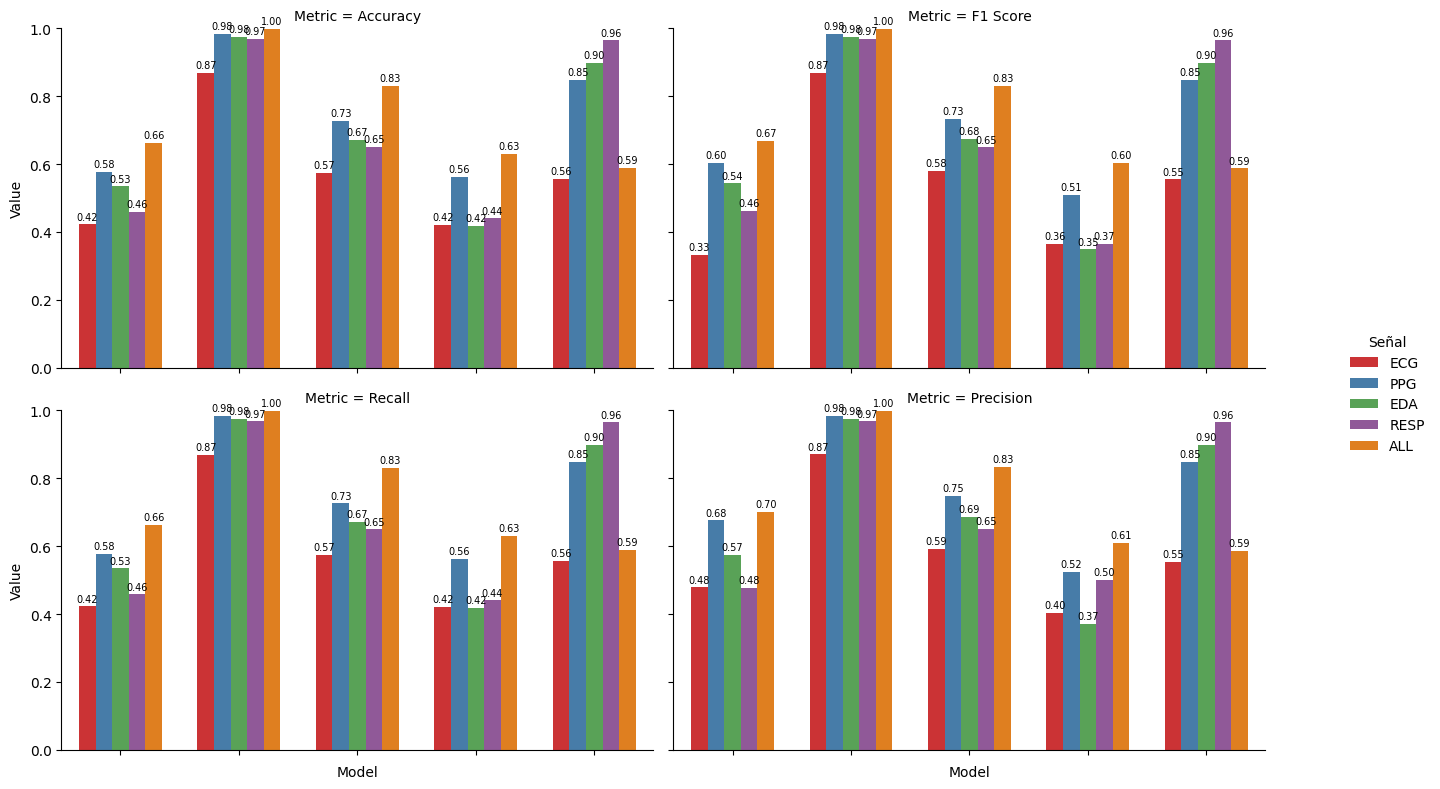

In [39]:
# Entrenamiento por cada tipo de señal
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features]
        y = df['label']
        subjects = df['subject']  # Se agrega el identificador de sujetos para LOSO

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal} using LOSO...')
            metrics = train_and_evaluate(X, y, model, param_grid, model_name, signal)
            
            # Convertir diccionario de métricas a DataFrame con mismo formato que antes
            results[(signal, model_name)] = metrics.copy()

# Entrenamiento con todas las señales combinadas
X_all = df.drop(columns=['label', 'subject'])  # También se excluye 'subject'
y_all = df['label']
subjects_all = df['subject']

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOSO...')
    metrics = train_and_evaluate(X_all, y_all, model, param_grid, model_name, "ALL")

    results[("ALL", model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (signal, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo (LOSO)')
plt.tight_layout()
plt.show()


data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (signal, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((signal, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)  # <-- aquí el width más pequeño

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

Training by signal combinations:   0%|          | 0/11 [00:00<?, ?it/s]

Training DecisionTree model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG') - DecisionTree Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.588985  ('ECG', 'PPG') - DecisionTree
1  Precision  0.670306  ('ECG', 'PPG') - DecisionTree
2     Recall  0.588985  ('ECG', 'PPG') - DecisionTree
3   F1 Score  0.612152  ('ECG', 'PPG') - DecisionTree
[('ECG', 'PPG') - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('ECG', 'PPG') - DecisionTree] Accuracy: 0.5890
('ECG', 'PPG') - DecisionTree - Confusion Matrix
[[3012  901   97  379]
 [ 389 1120  169  116]
 [ 147 1085 2685  471]
 [ 117 1123  491 1043]]


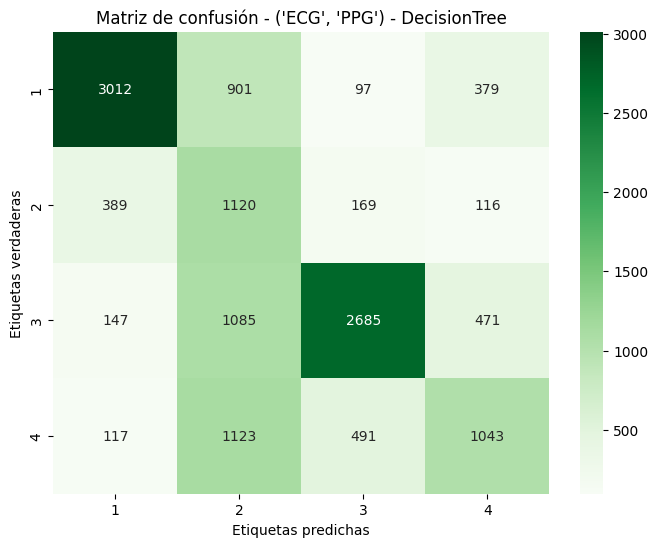

              precision    recall  f1-score   support

           1       0.82      0.69      0.75      4389
           2       0.26      0.62      0.37      1794
           3       0.78      0.61      0.69      4388
           4       0.52      0.38      0.44      2774

    accuracy                           0.59     13345
   macro avg       0.60      0.57      0.56     13345
weighted avg       0.67      0.59      0.61     13345

Training RandomForest model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG') - RandomForest Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.990259  ('ECG', 'PPG') - RandomForest
1  Precision  0.990265  ('ECG', 'PPG') - RandomForest
2     Recall  0.990259  ('ECG', 'PPG') - RandomForest
3   F1 Score  0.990246  ('ECG', 'PPG') - RandomForest
[('ECG', 'PPG') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2,

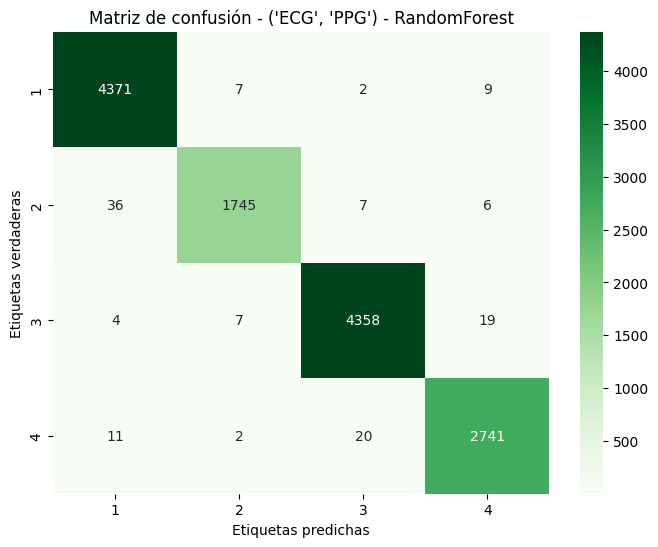

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      4389
           2       0.99      0.97      0.98      1794
           3       0.99      0.99      0.99      4388
           4       0.99      0.99      0.99      2774

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training AdaBoost model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG') - AdaBoost Metrics
     Métrica     Valor                      Etapa
0   Accuracy  0.774747  ('ECG', 'PPG') - AdaBoost
1  Precision  0.776981  ('ECG', 'PPG') - AdaBoost
2     Recall  0.774747  ('ECG', 'PPG') - AdaBoost
3   F1 Score  0.775731  ('ECG', 'PPG') - AdaBoost
[('ECG', 'PPG') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[(

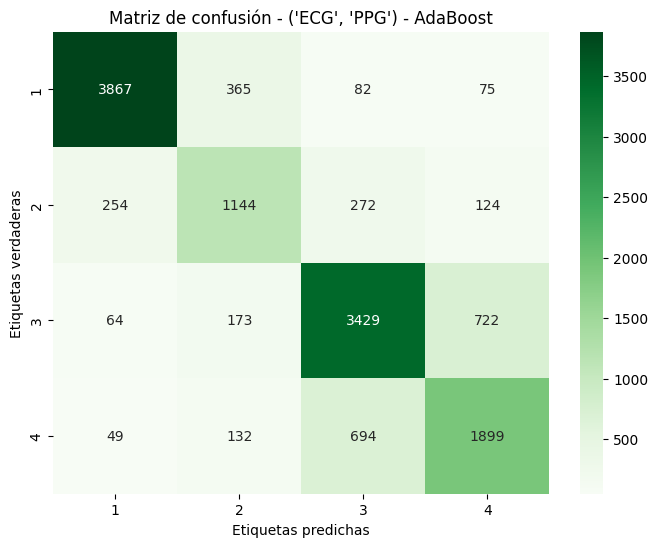

              precision    recall  f1-score   support

           1       0.91      0.88      0.90      4389
           2       0.63      0.64      0.63      1794
           3       0.77      0.78      0.77      4388
           4       0.67      0.68      0.68      2774

    accuracy                           0.77     13345
   macro avg       0.75      0.75      0.75     13345
weighted avg       0.78      0.77      0.78     13345

Training LDA model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG') - LDA Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.573248  ('ECG', 'PPG') - LDA
1  Precision  0.526458  ('ECG', 'PPG') - LDA
2     Recall  0.573248  ('ECG', 'PPG') - LDA
3   F1 Score  0.528031  ('ECG', 'PPG') - LDA
[('ECG', 'PPG') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG') - LDA] Accuracy: 0.5732
('ECG', 'PPG') - LDA - Confusion Matrix
[[3436   55  549  349]
 [ 757   51  692  294]
 [ 383   35 3327  64

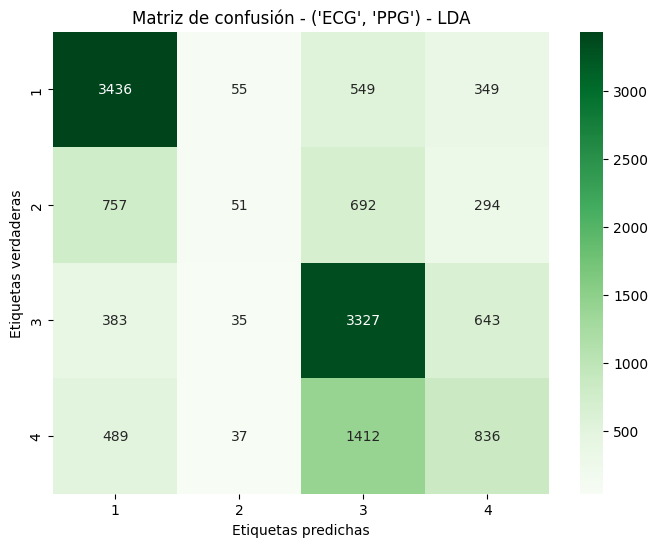

              precision    recall  f1-score   support

           1       0.68      0.78      0.73      4389
           2       0.29      0.03      0.05      1794
           3       0.56      0.76      0.64      4388
           4       0.39      0.30      0.34      2774

    accuracy                           0.57     13345
   macro avg       0.48      0.47      0.44     13345
weighted avg       0.53      0.57      0.53     13345

Training KNN model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG') - KNN Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.562383  ('ECG', 'PPG') - KNN
1  Precision  0.558856  ('ECG', 'PPG') - KNN
2     Recall  0.562383  ('ECG', 'PPG') - KNN
3   F1 Score  0.559740  ('ECG', 'PPG') - KNN
[('ECG', 'PPG') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'PPG') - KNN] Accuracy: 0.5624
('ECG', 'PPG') - KNN - Confusion Matrix
[[2837  337  760  455]
 [ 491  714  358  

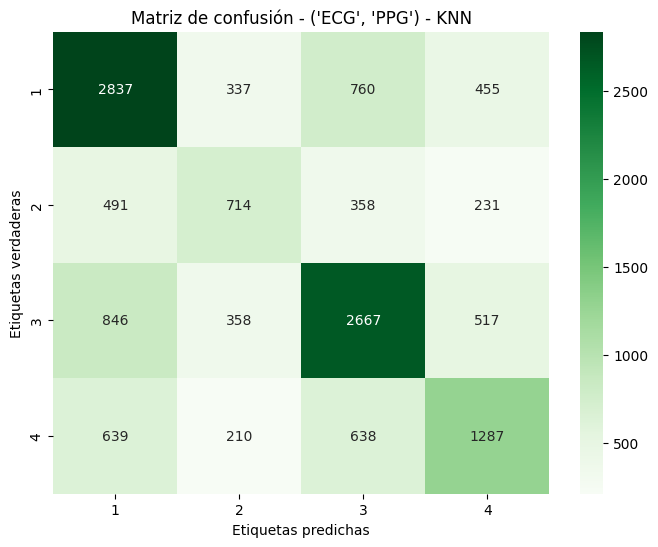

Training by signal combinations:   9%|▉         | 1/11 [1:46:10<17:41:40, 6370.09s/it]

              precision    recall  f1-score   support

           1       0.59      0.65      0.62      4389
           2       0.44      0.40      0.42      1794
           3       0.60      0.61      0.61      4388
           4       0.52      0.46      0.49      2774

    accuracy                           0.56     13345
   macro avg       0.54      0.53      0.53     13345
weighted avg       0.56      0.56      0.56     13345

Training DecisionTree model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'EDA') - DecisionTree Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.586587  ('ECG', 'EDA') - DecisionTree
1  Precision  0.635387  ('ECG', 'EDA') - DecisionTree
2     Recall  0.586587  ('ECG', 'EDA') - DecisionTree
3   F1 Score  0.597006  ('ECG', 'EDA') - DecisionTree
[('ECG', 'EDA') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('

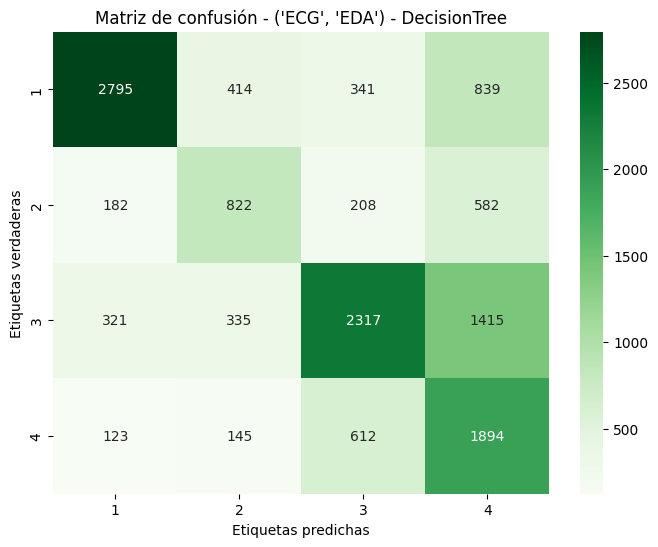

              precision    recall  f1-score   support

           1       0.82      0.64      0.72      4389
           2       0.48      0.46      0.47      1794
           3       0.67      0.53      0.59      4388
           4       0.40      0.68      0.50      2774

    accuracy                           0.59     13345
   macro avg       0.59      0.58      0.57     13345
weighted avg       0.64      0.59      0.60     13345

Training RandomForest model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'EDA') - RandomForest Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.991682  ('ECG', 'EDA') - RandomForest
1  Precision  0.991689  ('ECG', 'EDA') - RandomForest
2     Recall  0.991682  ('ECG', 'EDA') - RandomForest
3   F1 Score  0.991683  ('ECG', 'EDA') - RandomForest
[('ECG', 'EDA') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2,

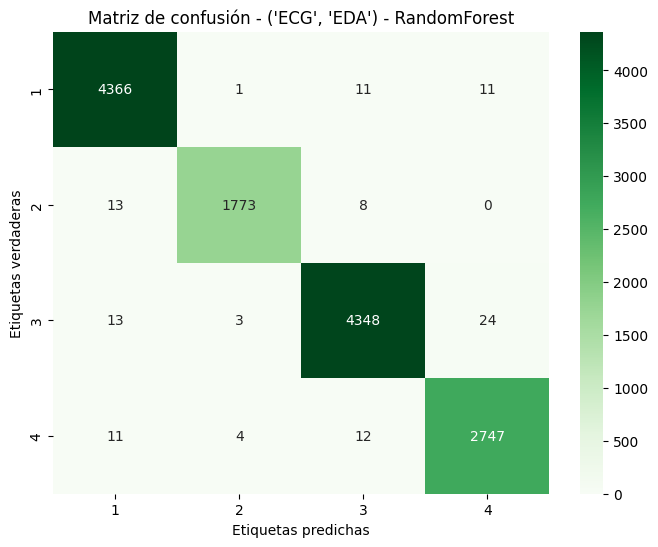

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      4389
           2       1.00      0.99      0.99      1794
           3       0.99      0.99      0.99      4388
           4       0.99      0.99      0.99      2774

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training AdaBoost model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'EDA') - AdaBoost Metrics
     Métrica     Valor                      Etapa
0   Accuracy  0.755789  ('ECG', 'EDA') - AdaBoost
1  Precision  0.764421  ('ECG', 'EDA') - AdaBoost
2     Recall  0.755789  ('ECG', 'EDA') - AdaBoost
3   F1 Score  0.758228  ('ECG', 'EDA') - AdaBoost
[('ECG', 'EDA') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('E

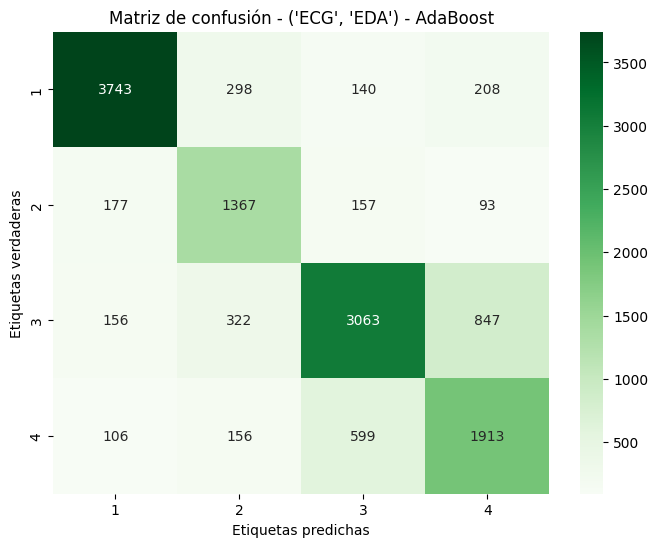

              precision    recall  f1-score   support

           1       0.90      0.85      0.87      4389
           2       0.64      0.76      0.69      1794
           3       0.77      0.70      0.73      4388
           4       0.62      0.69      0.66      2774

    accuracy                           0.76     13345
   macro avg       0.73      0.75      0.74     13345
weighted avg       0.76      0.76      0.76     13345

Training LDA model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'EDA') - LDA Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.483102  ('ECG', 'EDA') - LDA
1  Precision  0.457868  ('ECG', 'EDA') - LDA
2     Recall  0.483102  ('ECG', 'EDA') - LDA
3   F1 Score  0.428094  ('ECG', 'EDA') - LDA
[('ECG', 'EDA') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'EDA') - LDA] Accuracy: 0.4831
('ECG', 'EDA') - LDA - Confusion Matrix
[[3412   10  675  292]
 [ 919   13  758  104]
 [1458    6 2480  44

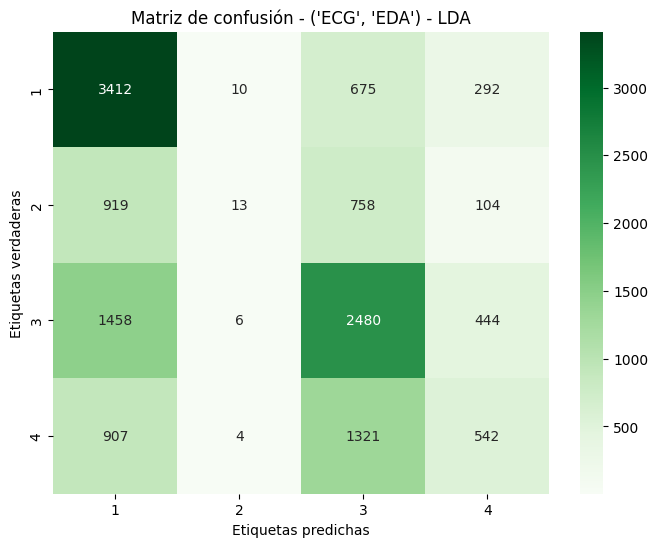

              precision    recall  f1-score   support

           1       0.51      0.78      0.62      4389
           2       0.39      0.01      0.01      1794
           3       0.47      0.57      0.52      4388
           4       0.39      0.20      0.26      2774

    accuracy                           0.48     13345
   macro avg       0.44      0.39      0.35     13345
weighted avg       0.46      0.48      0.43     13345

Training KNN model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'EDA') - KNN Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.583589  ('ECG', 'EDA') - KNN
1  Precision  0.579558  ('ECG', 'EDA') - KNN
2     Recall  0.583589  ('ECG', 'EDA') - KNN
3   F1 Score  0.580668  ('ECG', 'EDA') - KNN
[('ECG', 'EDA') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'EDA') - KNN] Accuracy: 0.5836
('ECG', 'EDA') - KNN - Confusion Matrix
[[2964  311  708  406]
 [ 459  733  368  

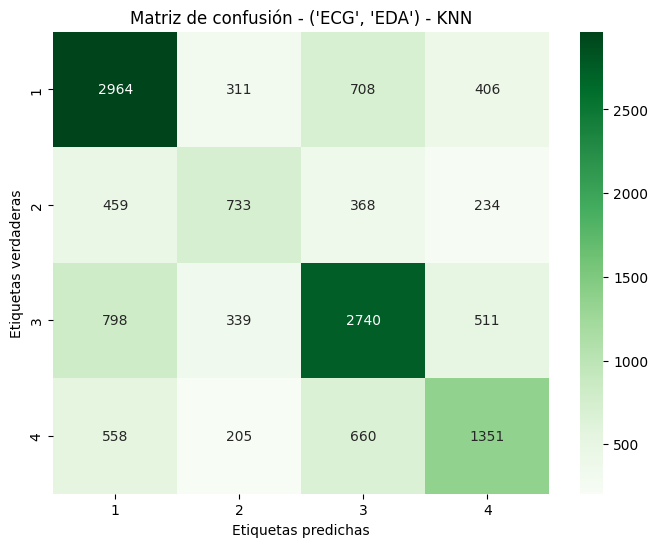

Training by signal combinations:  18%|█▊        | 2/11 [3:20:09<14:51:02, 5940.25s/it]

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      4389
           2       0.46      0.41      0.43      1794
           3       0.61      0.62      0.62      4388
           4       0.54      0.49      0.51      2774

    accuracy                           0.58     13345
   macro avg       0.56      0.55      0.55     13345
weighted avg       0.58      0.58      0.58     13345

Training DecisionTree model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'RESP') - DecisionTree Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.536980  ('ECG', 'RESP') - DecisionTree
1  Precision  0.540172  ('ECG', 'RESP') - DecisionTree
2     Recall  0.536980  ('ECG', 'RESP') - DecisionTree
3   F1 Score  0.530303  ('ECG', 'RESP') - DecisionTree
[('ECG', 'RESP') - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_spl

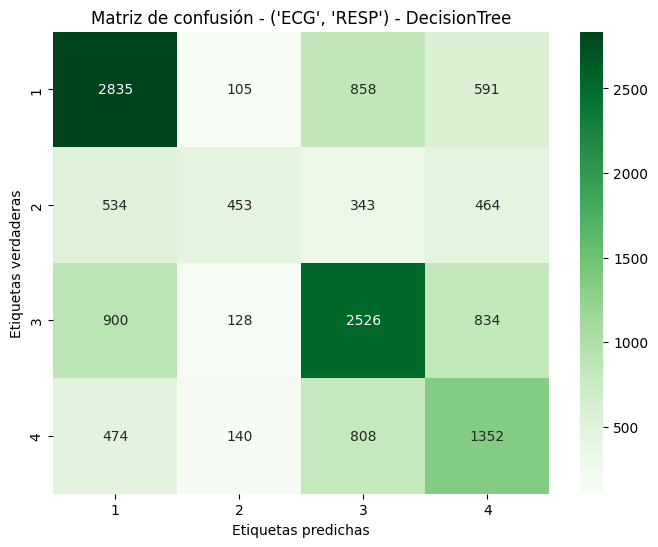

              precision    recall  f1-score   support

           1       0.60      0.65      0.62      4389
           2       0.55      0.25      0.35      1794
           3       0.56      0.58      0.57      4388
           4       0.42      0.49      0.45      2774

    accuracy                           0.54     13345
   macro avg       0.53      0.49      0.50     13345
weighted avg       0.54      0.54      0.53     13345

Training RandomForest model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'RESP') - RandomForest Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.989959  ('ECG', 'RESP') - RandomForest
1  Precision  0.990071  ('ECG', 'RESP') - RandomForest
2     Recall  0.989959  ('ECG', 'RESP') - RandomForest
3   F1 Score  0.989966  ('ECG', 'RESP') - RandomForest
[('ECG', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_sp

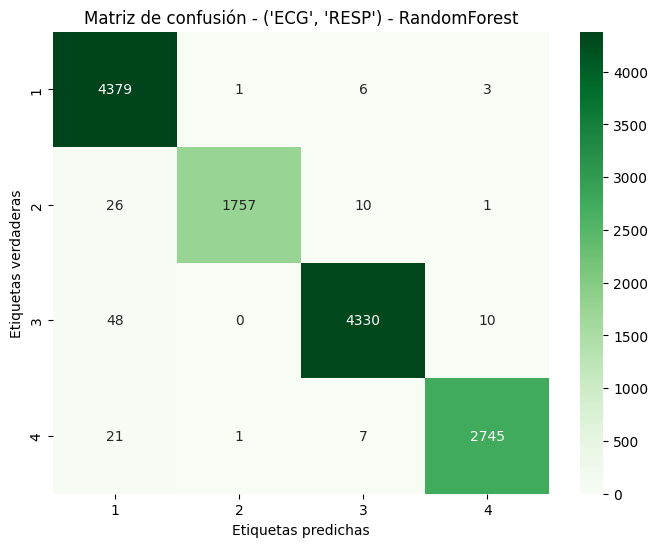

              precision    recall  f1-score   support

           1       0.98      1.00      0.99      4389
           2       1.00      0.98      0.99      1794
           3       0.99      0.99      0.99      4388
           4       0.99      0.99      0.99      2774

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training AdaBoost model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'RESP') - AdaBoost Metrics
     Métrica     Valor                       Etapa
0   Accuracy  0.762458  ('ECG', 'RESP') - AdaBoost
1  Precision  0.763191  ('ECG', 'RESP') - AdaBoost
2     Recall  0.762458  ('ECG', 'RESP') - AdaBoost
3   F1 Score  0.762439  ('ECG', 'RESP') - AdaBoost
[('ECG', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators':

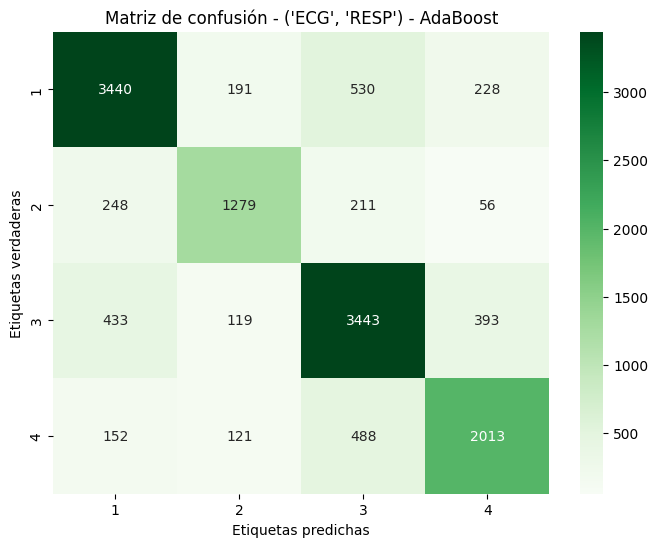

              precision    recall  f1-score   support

           1       0.81      0.78      0.79      4389
           2       0.75      0.71      0.73      1794
           3       0.74      0.78      0.76      4388
           4       0.75      0.73      0.74      2774

    accuracy                           0.76     13345
   macro avg       0.76      0.75      0.76     13345
weighted avg       0.76      0.76      0.76     13345

Training LDA model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'RESP') - LDA Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.477557  ('ECG', 'RESP') - LDA
1  Precision  0.444864  ('ECG', 'RESP') - LDA
2     Recall  0.477557  ('ECG', 'RESP') - LDA
3   F1 Score  0.424103  ('ECG', 'RESP') - LDA
[('ECG', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'RESP') - LDA] Accuracy: 0.4776
('ECG', 'RESP') - LDA - Confusion Matrix
[[3113    8  986  282]
 [1103   10  536  145]
 [1292   1

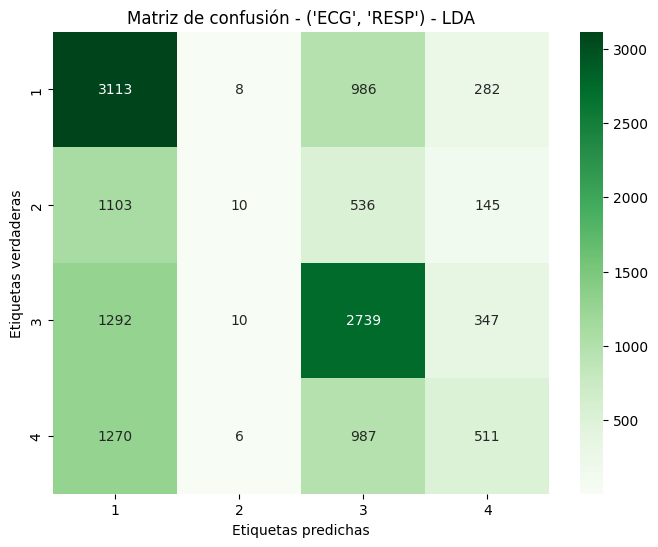

              precision    recall  f1-score   support

           1       0.46      0.71      0.56      4389
           2       0.29      0.01      0.01      1794
           3       0.52      0.62      0.57      4388
           4       0.40      0.18      0.25      2774

    accuracy                           0.48     13345
   macro avg       0.42      0.38      0.35     13345
weighted avg       0.44      0.48      0.42     13345

Training KNN model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'RESP') - KNN Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.559910  ('ECG', 'RESP') - KNN
1  Precision  0.556165  ('ECG', 'RESP') - KNN
2     Recall  0.559910  ('ECG', 'RESP') - KNN
3   F1 Score  0.557183  ('ECG', 'RESP') - KNN
[('ECG', 'RESP') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'RESP') - KNN] Accuracy: 0.5599
('ECG', 'RESP') - KNN - Confusion Matrix
[[2826  332  771  460]
 [ 487  

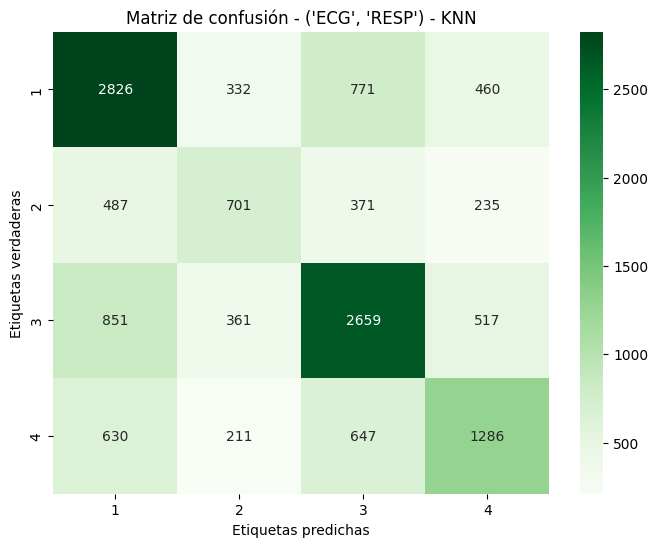

Training by signal combinations:  27%|██▋       | 3/11 [5:33:54<15:18:57, 6892.20s/it]

              precision    recall  f1-score   support

           1       0.59      0.64      0.62      4389
           2       0.44      0.39      0.41      1794
           3       0.60      0.61      0.60      4388
           4       0.51      0.46      0.49      2774

    accuracy                           0.56     13345
   macro avg       0.53      0.53      0.53     13345
weighted avg       0.56      0.56      0.56     13345

Training DecisionTree model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('PPG', 'EDA') - DecisionTree Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.641289  ('PPG', 'EDA') - DecisionTree
1  Precision  0.698084  ('PPG', 'EDA') - DecisionTree
2     Recall  0.641289  ('PPG', 'EDA') - DecisionTree
3   F1 Score  0.649495  ('PPG', 'EDA') - DecisionTree
[('PPG', 'EDA') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('

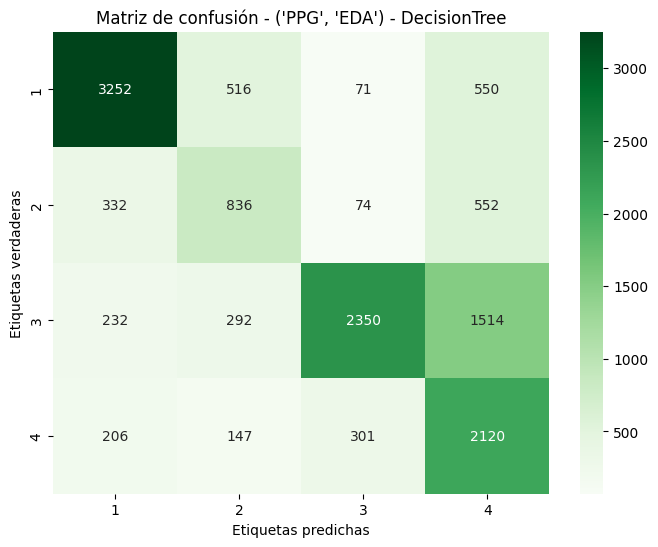

              precision    recall  f1-score   support

           1       0.81      0.74      0.77      4389
           2       0.47      0.47      0.47      1794
           3       0.84      0.54      0.65      4388
           4       0.45      0.76      0.56      2774

    accuracy                           0.64     13345
   macro avg       0.64      0.63      0.61     13345
weighted avg       0.70      0.64      0.65     13345

Training RandomForest model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('PPG', 'EDA') - RandomForest Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.998127  ('PPG', 'EDA') - RandomForest
1  Precision  0.998127  ('PPG', 'EDA') - RandomForest
2     Recall  0.998127  ('PPG', 'EDA') - RandomForest
3   F1 Score  0.998126  ('PPG', 'EDA') - RandomForest
[('PPG', 'EDA') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5,

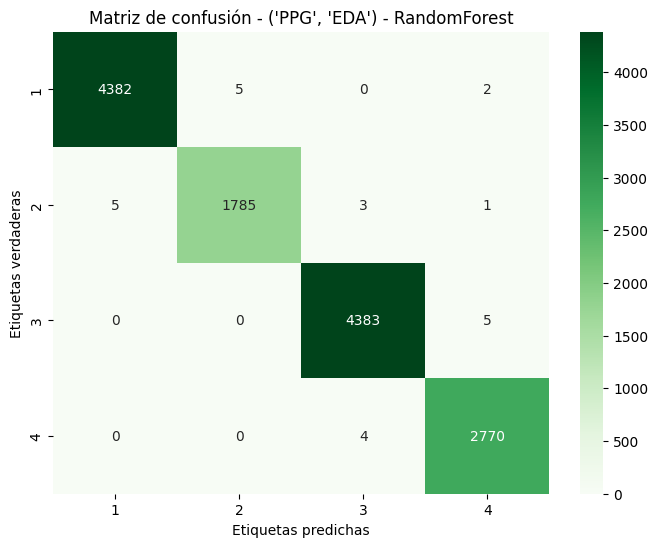

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      0.99      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('PPG', 'EDA') - AdaBoost Metrics
     Métrica     Valor                      Etapa
0   Accuracy  0.786062  ('PPG', 'EDA') - AdaBoost
1  Precision  0.802826  ('PPG', 'EDA') - AdaBoost
2     Recall  0.786062  ('PPG', 'EDA') - AdaBoost
3   F1 Score  0.790292  ('PPG', 'EDA') - AdaBoost
[('PPG', 'EDA') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.1, 'n_estimators': 300}
[(

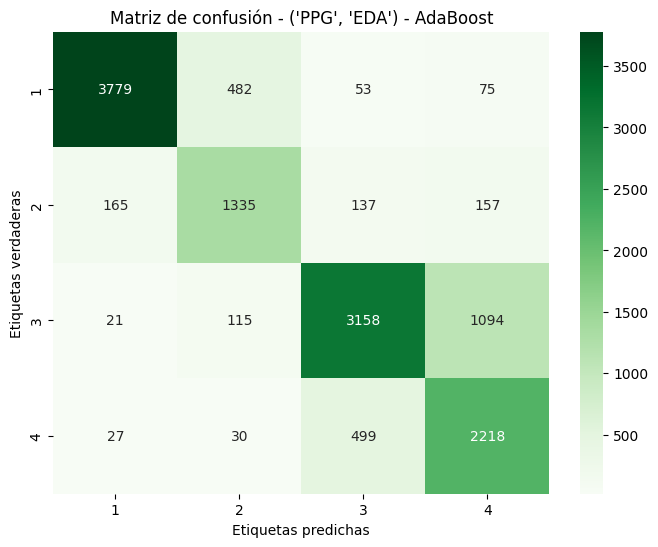

              precision    recall  f1-score   support

           1       0.95      0.86      0.90      4389
           2       0.68      0.74      0.71      1794
           3       0.82      0.72      0.77      4388
           4       0.63      0.80      0.70      2774

    accuracy                           0.79     13345
   macro avg       0.77      0.78      0.77     13345
weighted avg       0.80      0.79      0.79     13345

Training LDA model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('PPG', 'EDA') - LDA Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.586137  ('PPG', 'EDA') - LDA
1  Precision  0.554150  ('PPG', 'EDA') - LDA
2     Recall  0.586137  ('PPG', 'EDA') - LDA
3   F1 Score  0.541348  ('PPG', 'EDA') - LDA
[('PPG', 'EDA') - LDA] Best Params: {'solver': 'svd'}
[('PPG', 'EDA') - LDA] Accuracy: 0.5861
('PPG', 'EDA') - LDA - Confusion Matrix
[[3552   56  485  296]
 [ 710   97  708  279]
 [ 439   29 3368  55

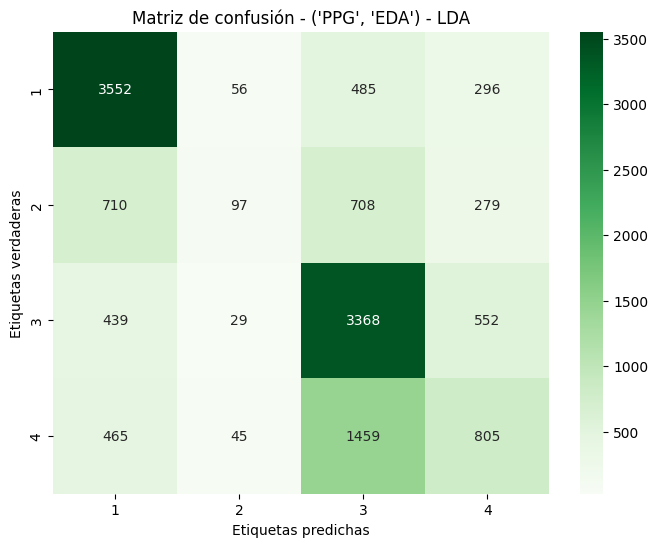

              precision    recall  f1-score   support

           1       0.69      0.81      0.74      4389
           2       0.43      0.05      0.10      1794
           3       0.56      0.77      0.65      4388
           4       0.42      0.29      0.34      2774

    accuracy                           0.59     13345
   macro avg       0.52      0.48      0.46     13345
weighted avg       0.55      0.59      0.54     13345

Training KNN model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('PPG', 'EDA') - KNN Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.972724  ('PPG', 'EDA') - KNN
1  Precision  0.972689  ('PPG', 'EDA') - KNN
2     Recall  0.972724  ('PPG', 'EDA') - KNN
3   F1 Score  0.972701  ('PPG', 'EDA') - KNN
[('PPG', 'EDA') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('PPG', 'EDA') - KNN] Accuracy: 0.9727
('PPG', 'EDA') - KNN - Confusion Matrix
[[4321   38   13   17]
 [  46 1697   19  

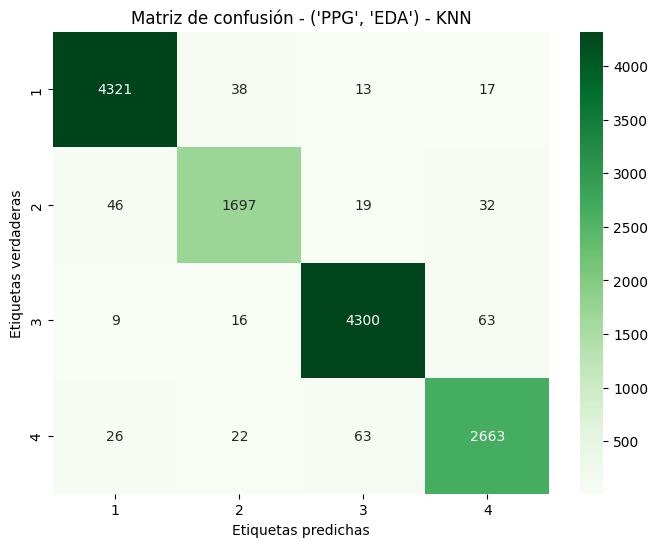

Training by signal combinations:  36%|███▋      | 4/11 [7:09:32<12:30:55, 6436.45s/it]

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      4389
           2       0.96      0.95      0.95      1794
           3       0.98      0.98      0.98      4388
           4       0.96      0.96      0.96      2774

    accuracy                           0.97     13345
   macro avg       0.97      0.97      0.97     13345
weighted avg       0.97      0.97      0.97     13345

Training DecisionTree model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('PPG', 'RESP') - DecisionTree Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.612514  ('PPG', 'RESP') - DecisionTree
1  Precision  0.646169  ('PPG', 'RESP') - DecisionTree
2     Recall  0.612514  ('PPG', 'RESP') - DecisionTree
3   F1 Score  0.622116  ('PPG', 'RESP') - DecisionTree
[('PPG', 'RESP') - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_spl

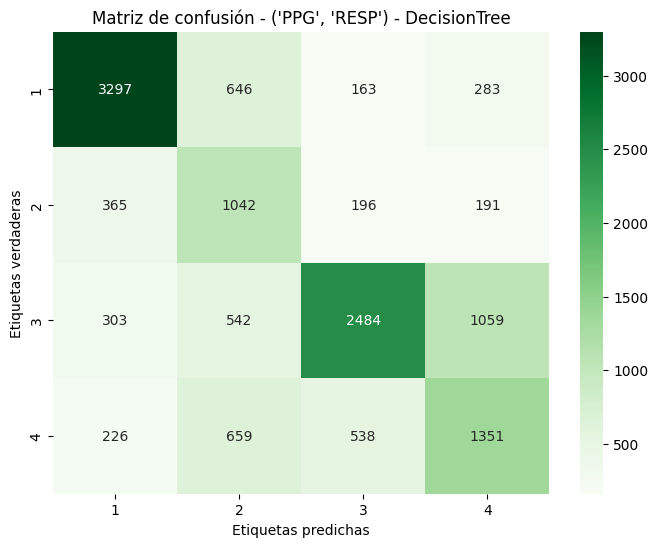

              precision    recall  f1-score   support

           1       0.79      0.75      0.77      4389
           2       0.36      0.58      0.45      1794
           3       0.73      0.57      0.64      4388
           4       0.47      0.49      0.48      2774

    accuracy                           0.61     13345
   macro avg       0.59      0.60      0.58     13345
weighted avg       0.65      0.61      0.62     13345

Training RandomForest model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('PPG', 'RESP') - RandomForest Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.997302  ('PPG', 'RESP') - RandomForest
1  Precision  0.997304  ('PPG', 'RESP') - RandomForest
2     Recall  0.997302  ('PPG', 'RESP') - RandomForest
3   F1 Score  0.997301  ('PPG', 'RESP') - RandomForest
[('PPG', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_sp

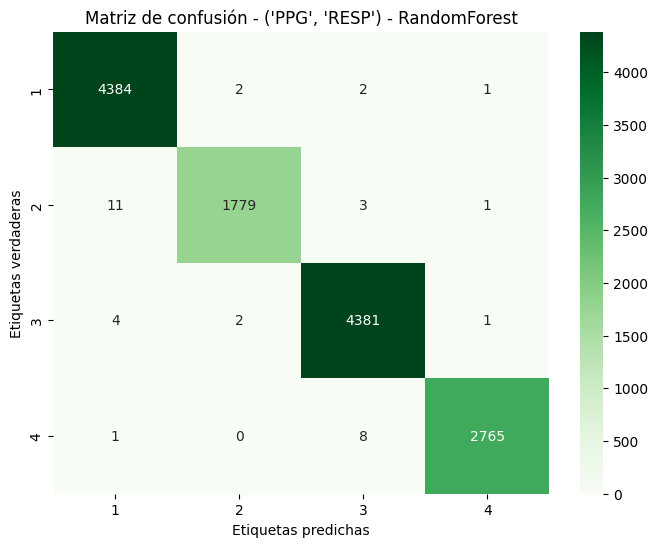

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      0.99      0.99      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('PPG', 'RESP') - AdaBoost Metrics
     Métrica     Valor                       Etapa
0   Accuracy  0.820082  ('PPG', 'RESP') - AdaBoost
1  Precision  0.825798  ('PPG', 'RESP') - AdaBoost
2     Recall  0.820082  ('PPG', 'RESP') - AdaBoost
3   F1 Score  0.821955  ('PPG', 'RESP') - AdaBoost
[('PPG', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators':

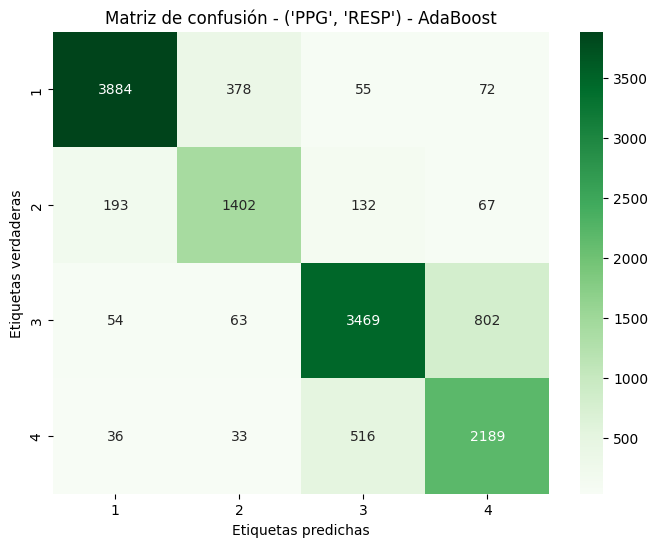

              precision    recall  f1-score   support

           1       0.93      0.88      0.91      4389
           2       0.75      0.78      0.76      1794
           3       0.83      0.79      0.81      4388
           4       0.70      0.79      0.74      2774

    accuracy                           0.82     13345
   macro avg       0.80      0.81      0.81     13345
weighted avg       0.83      0.82      0.82     13345

Training LDA model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('PPG', 'RESP') - LDA Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.593631  ('PPG', 'RESP') - LDA
1  Precision  0.560919  ('PPG', 'RESP') - LDA
2     Recall  0.593631  ('PPG', 'RESP') - LDA
3   F1 Score  0.557622  ('PPG', 'RESP') - LDA
[('PPG', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('PPG', 'RESP') - LDA] Accuracy: 0.5936
('PPG', 'RESP') - LDA - Confusion Matrix
[[3489   79  237  584]
 [ 771   90  443  490]
 [ 319   3

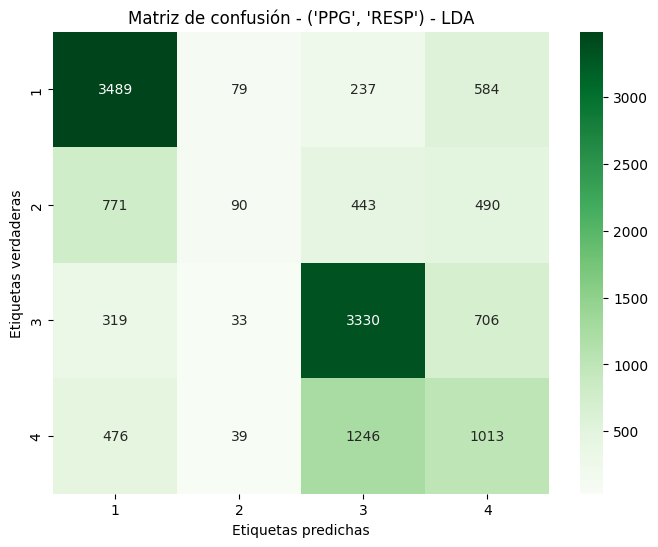

              precision    recall  f1-score   support

           1       0.69      0.79      0.74      4389
           2       0.37      0.05      0.09      1794
           3       0.63      0.76      0.69      4388
           4       0.36      0.37      0.36      2774

    accuracy                           0.59     13345
   macro avg       0.51      0.49      0.47     13345
weighted avg       0.56      0.59      0.56     13345

Training KNN model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('PPG', 'RESP') - KNN Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.982615  ('PPG', 'RESP') - KNN
1  Precision  0.982634  ('PPG', 'RESP') - KNN
2     Recall  0.982615  ('PPG', 'RESP') - KNN
3   F1 Score  0.982621  ('PPG', 'RESP') - KNN
[('PPG', 'RESP') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('PPG', 'RESP') - KNN] Accuracy: 0.9826
('PPG', 'RESP') - KNN - Confusion Matrix
[[4334   25   10   20]
 [  23 1

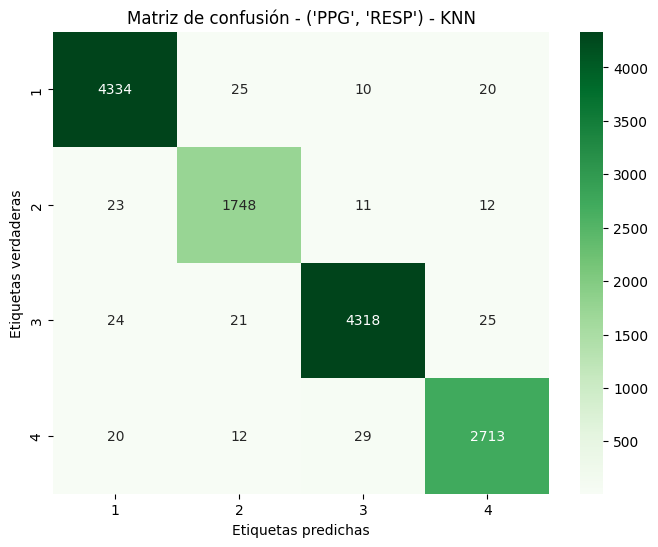

Training by signal combinations:  45%|████▌     | 5/11 [8:35:54<9:58:25, 5984.28s/it] 

              precision    recall  f1-score   support

           1       0.98      0.99      0.99      4389
           2       0.97      0.97      0.97      1794
           3       0.99      0.98      0.99      4388
           4       0.98      0.98      0.98      2774

    accuracy                           0.98     13345
   macro avg       0.98      0.98      0.98     13345
weighted avg       0.98      0.98      0.98     13345

Training DecisionTree model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.573923  ('EDA', 'RESP') - DecisionTree
1  Precision  0.603988  ('EDA', 'RESP') - DecisionTree
2     Recall  0.573923  ('EDA', 'RESP') - DecisionTree
3   F1 Score  0.580648  ('EDA', 'RESP') - DecisionTree
[('EDA', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split'

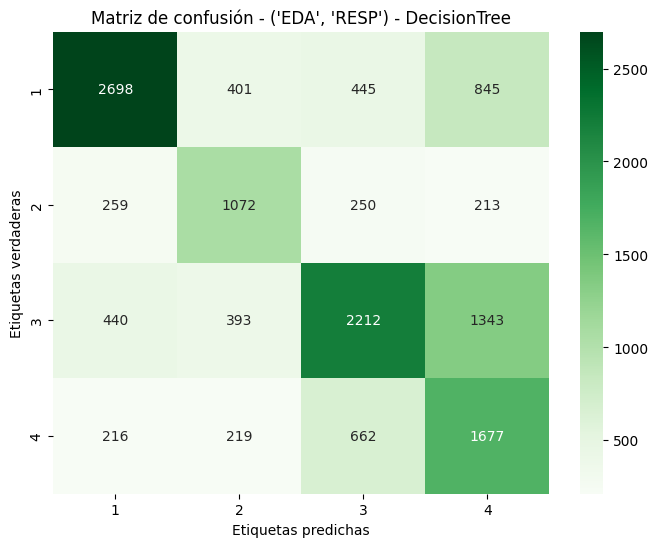

              precision    recall  f1-score   support

           1       0.75      0.61      0.67      4389
           2       0.51      0.60      0.55      1794
           3       0.62      0.50      0.56      4388
           4       0.41      0.60      0.49      2774

    accuracy                           0.57     13345
   macro avg       0.57      0.58      0.57     13345
weighted avg       0.60      0.57      0.58     13345

Training RandomForest model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('EDA', 'RESP') - RandomForest Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.997377  ('EDA', 'RESP') - RandomForest
1  Precision  0.997379  ('EDA', 'RESP') - RandomForest
2     Recall  0.997377  ('EDA', 'RESP') - RandomForest
3   F1 Score  0.997377  ('EDA', 'RESP') - RandomForest
[('EDA', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_sp

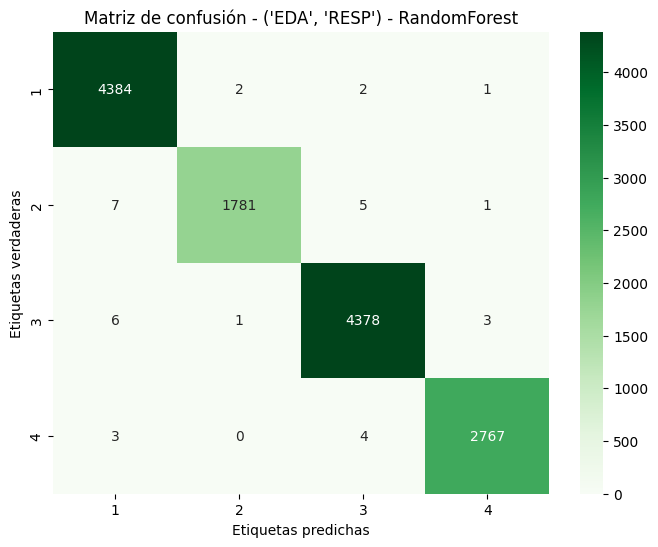

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      0.99      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                       Etapa
0   Accuracy  0.750918  ('EDA', 'RESP') - AdaBoost
1  Precision  0.755062  ('EDA', 'RESP') - AdaBoost
2     Recall  0.750918  ('EDA', 'RESP') - AdaBoost
3   F1 Score  0.751350  ('EDA', 'RESP') - AdaBoost
[('EDA', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators':

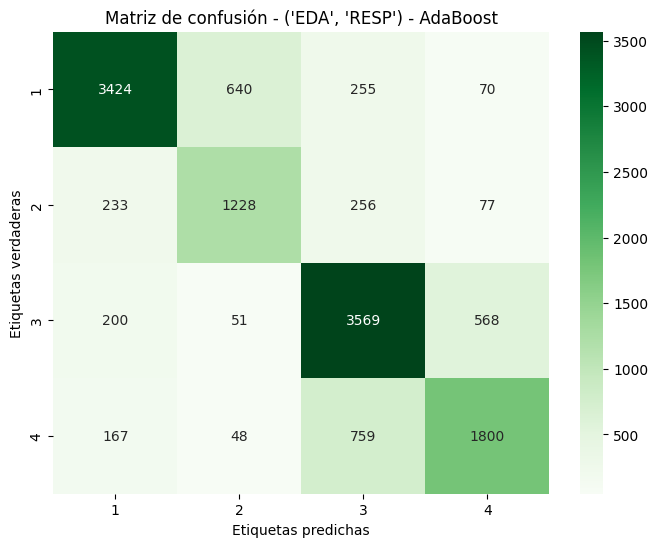

              precision    recall  f1-score   support

           1       0.85      0.78      0.81      4389
           2       0.62      0.68      0.65      1794
           3       0.74      0.81      0.77      4388
           4       0.72      0.65      0.68      2774

    accuracy                           0.75     13345
   macro avg       0.73      0.73      0.73     13345
weighted avg       0.76      0.75      0.75     13345

Training LDA model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('EDA', 'RESP') - LDA Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.502885  ('EDA', 'RESP') - LDA
1  Precision  0.496892  ('EDA', 'RESP') - LDA
2     Recall  0.502885  ('EDA', 'RESP') - LDA
3   F1 Score  0.456152  ('EDA', 'RESP') - LDA
[('EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('EDA', 'RESP') - LDA] Accuracy: 0.5029
('EDA', 'RESP') - LDA - Confusion Matrix
[[3126    7  895  361]
 [ 930   33  602  229]
 [1134    

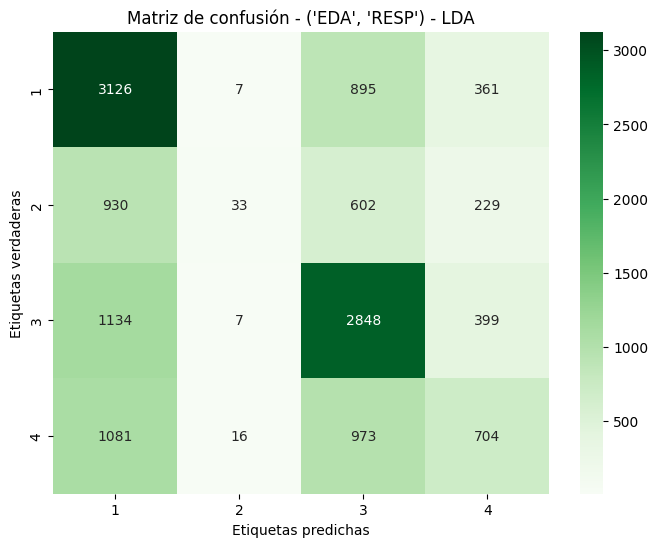

              precision    recall  f1-score   support

           1       0.50      0.71      0.59      4389
           2       0.52      0.02      0.04      1794
           3       0.54      0.65      0.59      4388
           4       0.42      0.25      0.32      2774

    accuracy                           0.50     13345
   macro avg       0.49      0.41      0.38     13345
weighted avg       0.50      0.50      0.46     13345

Training KNN model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('EDA', 'RESP') - KNN Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.974372  ('EDA', 'RESP') - KNN
1  Precision  0.974361  ('EDA', 'RESP') - KNN
2     Recall  0.974372  ('EDA', 'RESP') - KNN
3   F1 Score  0.974360  ('EDA', 'RESP') - KNN
[('EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('EDA', 'RESP') - KNN] Accuracy: 0.9744
('EDA', 'RESP') - KNN - Confusion Matrix
[[4323   23   18   25]
 [  32 1

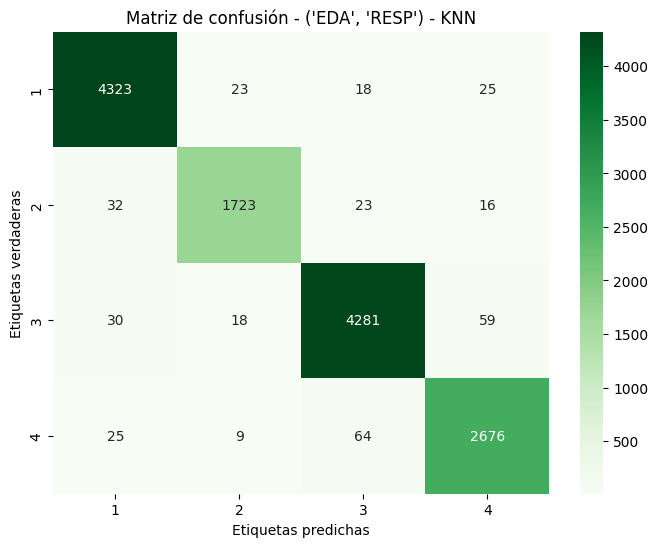

Training by signal combinations:  55%|█████▍    | 6/11 [9:56:21<7:45:54, 5590.84s/it]

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      4389
           2       0.97      0.96      0.97      1794
           3       0.98      0.98      0.98      4388
           4       0.96      0.96      0.96      2774

    accuracy                           0.97     13345
   macro avg       0.97      0.97      0.97     13345
weighted avg       0.97      0.97      0.97     13345

Training DecisionTree model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG', 'EDA') - DecisionTree Metrics
     Métrica     Valor                                 Etapa
0   Accuracy  0.666842  ('ECG', 'PPG', 'EDA') - DecisionTree
1  Precision  0.700028  ('ECG', 'PPG', 'EDA') - DecisionTree
2     Recall  0.666842  ('ECG', 'PPG', 'EDA') - DecisionTree
3   F1 Score  0.669417  ('ECG', 'PPG', 'EDA') - DecisionTree
[('ECG', 'PPG', 'EDA') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth

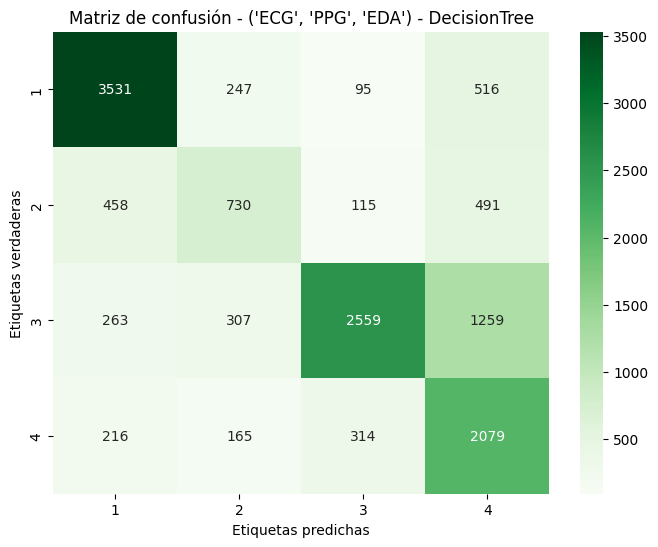

              precision    recall  f1-score   support

           1       0.79      0.80      0.80      4389
           2       0.50      0.41      0.45      1794
           3       0.83      0.58      0.69      4388
           4       0.48      0.75      0.58      2774

    accuracy                           0.67     13345
   macro avg       0.65      0.64      0.63     13345
weighted avg       0.70      0.67      0.67     13345

Training RandomForest model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG', 'EDA') - RandomForest Metrics
     Métrica     Valor                                 Etapa
0   Accuracy  0.998127  ('ECG', 'PPG', 'EDA') - RandomForest
1  Precision  0.998128  ('ECG', 'PPG', 'EDA') - RandomForest
2     Recall  0.998127  ('ECG', 'PPG', 'EDA') - RandomForest
3   F1 Score  0.998126  ('ECG', 'PPG', 'EDA') - RandomForest
[('ECG', 'PPG', 'EDA') - RandomForest] Best Params: {'max_depth': 20, 'max_features'

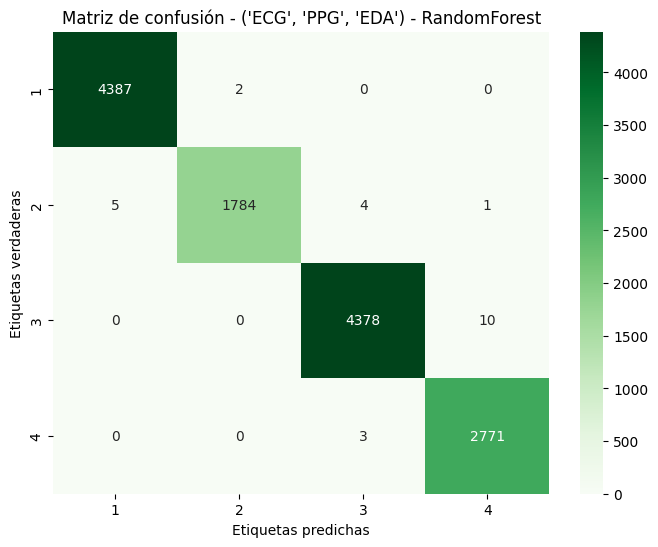

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      0.99      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG', 'EDA') - AdaBoost Metrics
     Métrica     Valor                             Etapa
0   Accuracy  0.811540  ('ECG', 'PPG', 'EDA') - AdaBoost
1  Precision  0.813371  ('ECG', 'PPG', 'EDA') - AdaBoost
2     Recall  0.811540  ('ECG', 'PPG', 'EDA') - AdaBoost
3   F1 Score  0.812254  ('ECG', 'PPG', 'EDA') - AdaBoost
[('ECG', 'PPG', 'EDA') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max

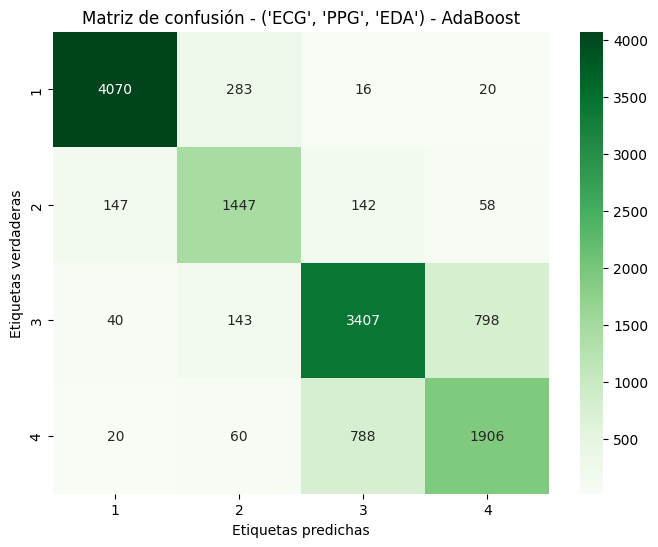

              precision    recall  f1-score   support

           1       0.95      0.93      0.94      4389
           2       0.75      0.81      0.78      1794
           3       0.78      0.78      0.78      4388
           4       0.69      0.69      0.69      2774

    accuracy                           0.81     13345
   macro avg       0.79      0.80      0.80     13345
weighted avg       0.81      0.81      0.81     13345

Training LDA model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG', 'EDA') - LDA Metrics
     Métrica     Valor                        Etapa
0   Accuracy  0.595354  ('ECG', 'PPG', 'EDA') - LDA
1  Precision  0.568066  ('ECG', 'PPG', 'EDA') - LDA
2     Recall  0.595354  ('ECG', 'PPG', 'EDA') - LDA
3   F1 Score  0.560287  ('ECG', 'PPG', 'EDA') - LDA
[('ECG', 'PPG', 'EDA') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG', 'EDA') - LDA] Accuracy: 0.5954
('ECG', 'PPG', 'EDA') - LDA - Confusion Mat

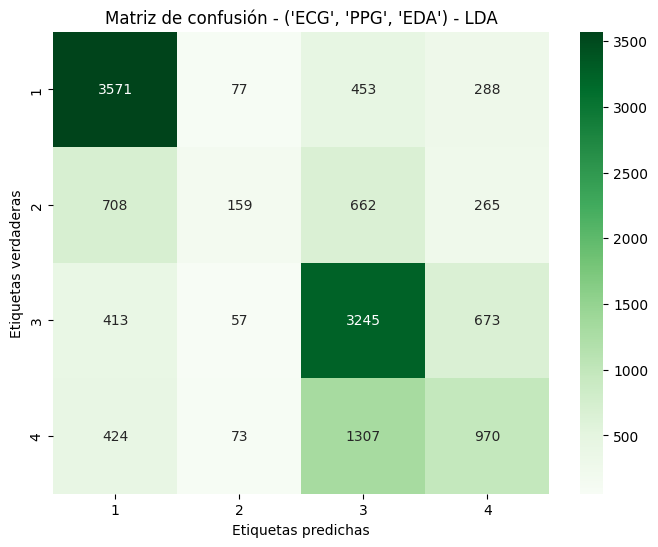

              precision    recall  f1-score   support

           1       0.70      0.81      0.75      4389
           2       0.43      0.09      0.15      1794
           3       0.57      0.74      0.65      4388
           4       0.44      0.35      0.39      2774

    accuracy                           0.60     13345
   macro avg       0.54      0.50      0.48     13345
weighted avg       0.57      0.60      0.56     13345

Training KNN model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG', 'EDA') - KNN Metrics
     Métrica     Valor                        Etapa
0   Accuracy  0.586737  ('ECG', 'PPG', 'EDA') - KNN
1  Precision  0.582813  ('ECG', 'PPG', 'EDA') - KNN
2     Recall  0.586737  ('ECG', 'PPG', 'EDA') - KNN
3   F1 Score  0.583828  ('ECG', 'PPG', 'EDA') - KNN
[('ECG', 'PPG', 'EDA') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'PPG', 'EDA') - KNN] Accuracy: 0.5867
('ECG', 'PPG', 'ED

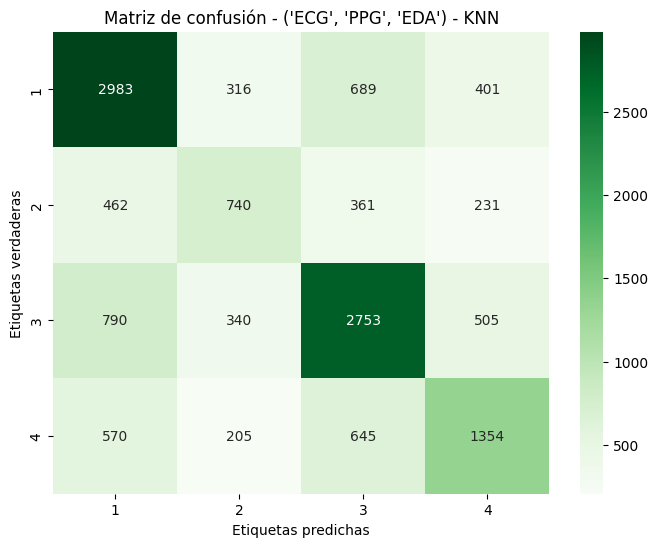

Training by signal combinations:  64%|██████▎   | 7/11 [12:02:30<6:55:49, 6237.44s/it]

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      4389
           2       0.46      0.41      0.44      1794
           3       0.62      0.63      0.62      4388
           4       0.54      0.49      0.51      2774

    accuracy                           0.59     13345
   macro avg       0.56      0.55      0.56     13345
weighted avg       0.58      0.59      0.58     13345

Training DecisionTree model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.629149  ('ECG', 'PPG', 'RESP') - DecisionTree
1  Precision  0.678811  ('ECG', 'PPG', 'RESP') - DecisionTree
2     Recall  0.629149  ('ECG', 'PPG', 'RESP') - DecisionTree
3   F1 Score  0.643898  ('ECG', 'PPG', 'RESP') - DecisionTree
[('ECG', 'PPG', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'm

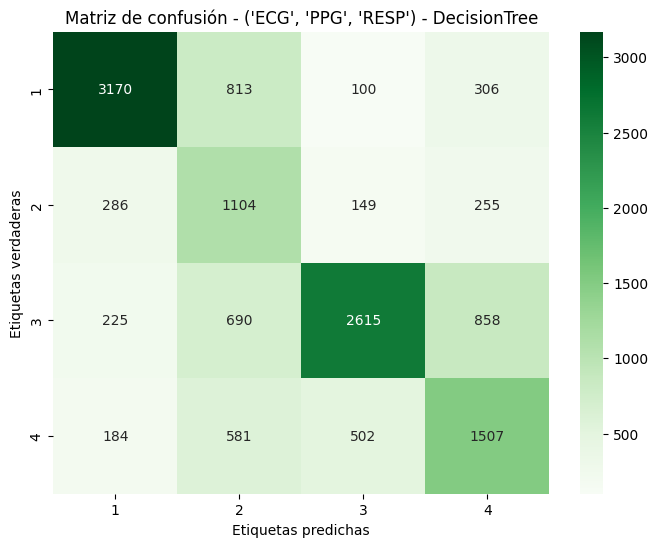

              precision    recall  f1-score   support

           1       0.82      0.72      0.77      4389
           2       0.35      0.62      0.44      1794
           3       0.78      0.60      0.67      4388
           4       0.52      0.54      0.53      2774

    accuracy                           0.63     13345
   macro avg       0.61      0.62      0.60     13345
weighted avg       0.68      0.63      0.64     13345

Training RandomForest model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG', 'RESP') - RandomForest Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.997152  ('ECG', 'PPG', 'RESP') - RandomForest
1  Precision  0.997153  ('ECG', 'PPG', 'RESP') - RandomForest
2     Recall  0.997152  ('ECG', 'PPG', 'RESP') - RandomForest
3   F1 Score  0.997150  ('ECG', 'PPG', 'RESP') - RandomForest
[('ECG', 'PPG', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_f

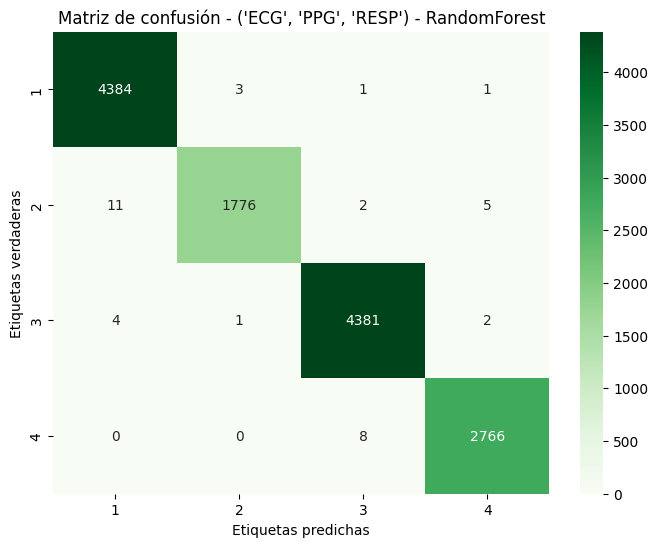

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      0.99      0.99      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG', 'RESP') - AdaBoost Metrics
     Métrica     Valor                              Etapa
0   Accuracy  0.828400  ('ECG', 'PPG', 'RESP') - AdaBoost
1  Precision  0.832348  ('ECG', 'PPG', 'RESP') - AdaBoost
2     Recall  0.828400  ('ECG', 'PPG', 'RESP') - AdaBoost
3   F1 Score  0.829874  ('ECG', 'PPG', 'RESP') - AdaBoost
[('ECG', 'PPG', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanc

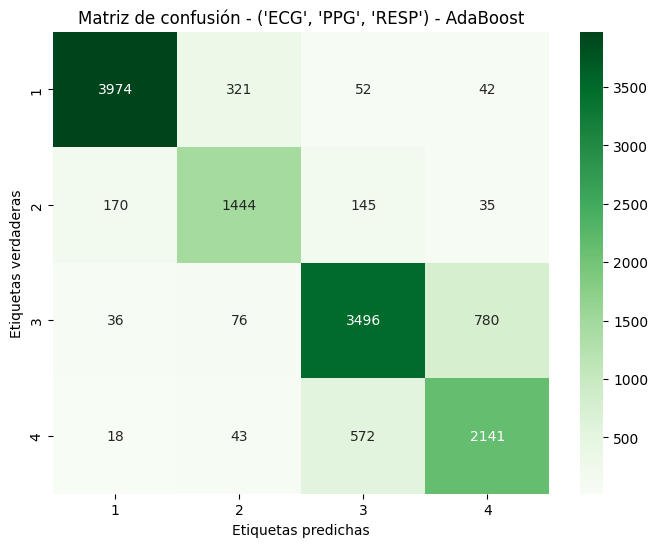

              precision    recall  f1-score   support

           1       0.95      0.91      0.93      4389
           2       0.77      0.80      0.79      1794
           3       0.82      0.80      0.81      4388
           4       0.71      0.77      0.74      2774

    accuracy                           0.83     13345
   macro avg       0.81      0.82      0.82     13345
weighted avg       0.83      0.83      0.83     13345

Training LDA model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG', 'RESP') - LDA Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.605245  ('ECG', 'PPG', 'RESP') - LDA
1  Precision  0.575750  ('ECG', 'PPG', 'RESP') - LDA
2     Recall  0.605245  ('ECG', 'PPG', 'RESP') - LDA
3   F1 Score  0.575536  ('ECG', 'PPG', 'RESP') - LDA
[('ECG', 'PPG', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG', 'RESP') - LDA] Accuracy: 0.6052
('ECG', 'PPG', 'RESP') - LDA - Con

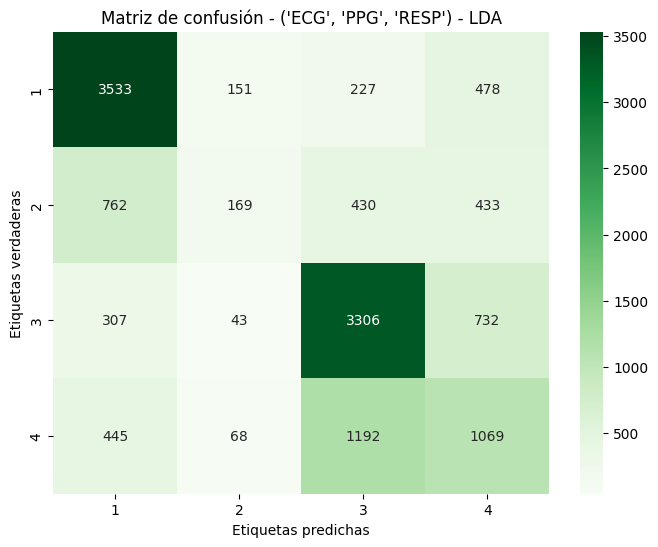

              precision    recall  f1-score   support

           1       0.70      0.80      0.75      4389
           2       0.39      0.09      0.15      1794
           3       0.64      0.75      0.69      4388
           4       0.39      0.39      0.39      2774

    accuracy                           0.61     13345
   macro avg       0.53      0.51      0.50     13345
weighted avg       0.58      0.61      0.58     13345

Training KNN model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG', 'RESP') - KNN Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.565081  ('ECG', 'PPG', 'RESP') - KNN
1  Precision  0.561556  ('ECG', 'PPG', 'RESP') - KNN
2     Recall  0.565081  ('ECG', 'PPG', 'RESP') - KNN
3   F1 Score  0.562416  ('ECG', 'PPG', 'RESP') - KNN
[('ECG', 'PPG', 'RESP') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'PPG', 'RESP') - KNN] Accuracy: 0.5651
('ECG', '

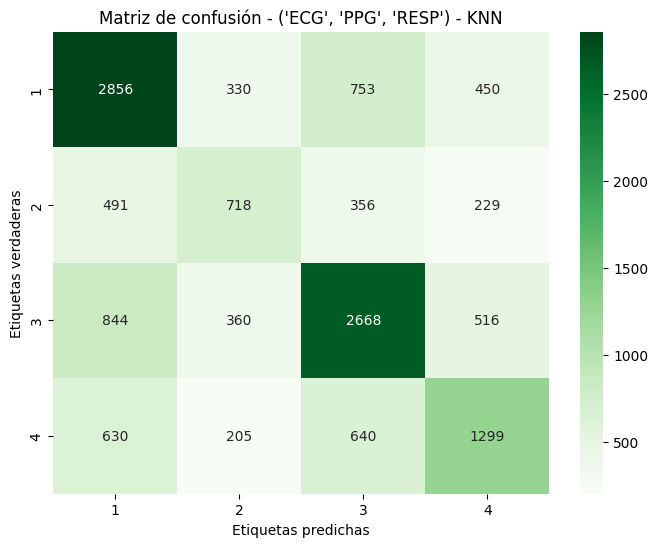

Training by signal combinations:  73%|███████▎  | 8/11 [14:07:01<5:31:30, 6630.10s/it]

              precision    recall  f1-score   support

           1       0.59      0.65      0.62      4389
           2       0.45      0.40      0.42      1794
           3       0.60      0.61      0.61      4388
           4       0.52      0.47      0.49      2774

    accuracy                           0.57     13345
   macro avg       0.54      0.53      0.54     13345
weighted avg       0.56      0.57      0.56     13345

Training DecisionTree model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.614612  ('ECG', 'EDA', 'RESP') - DecisionTree
1  Precision  0.631464  ('ECG', 'EDA', 'RESP') - DecisionTree
2     Recall  0.614612  ('ECG', 'EDA', 'RESP') - DecisionTree
3   F1 Score  0.617542  ('ECG', 'EDA', 'RESP') - DecisionTree
[('ECG', 'EDA', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'm

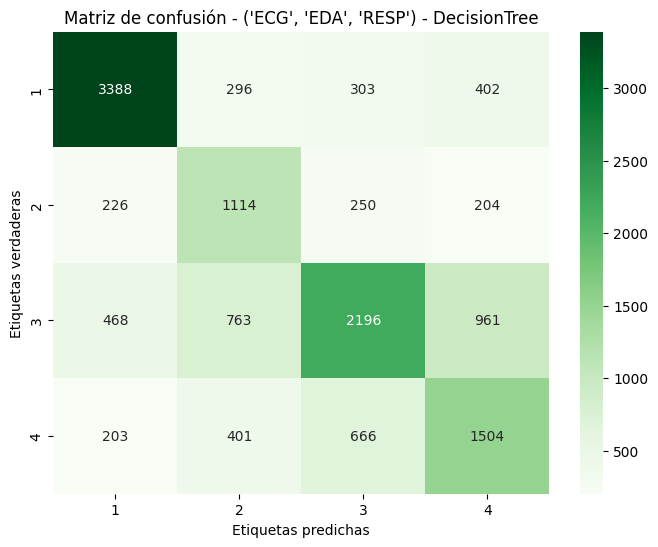

              precision    recall  f1-score   support

           1       0.79      0.77      0.78      4389
           2       0.43      0.62      0.51      1794
           3       0.64      0.50      0.56      4388
           4       0.49      0.54      0.51      2774

    accuracy                           0.61     13345
   macro avg       0.59      0.61      0.59     13345
weighted avg       0.63      0.61      0.62     13345

Training RandomForest model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'EDA', 'RESP') - RandomForest Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.998501  ('ECG', 'EDA', 'RESP') - RandomForest
1  Precision  0.998502  ('ECG', 'EDA', 'RESP') - RandomForest
2     Recall  0.998501  ('ECG', 'EDA', 'RESP') - RandomForest
3   F1 Score  0.998501  ('ECG', 'EDA', 'RESP') - RandomForest
[('ECG', 'EDA', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_f

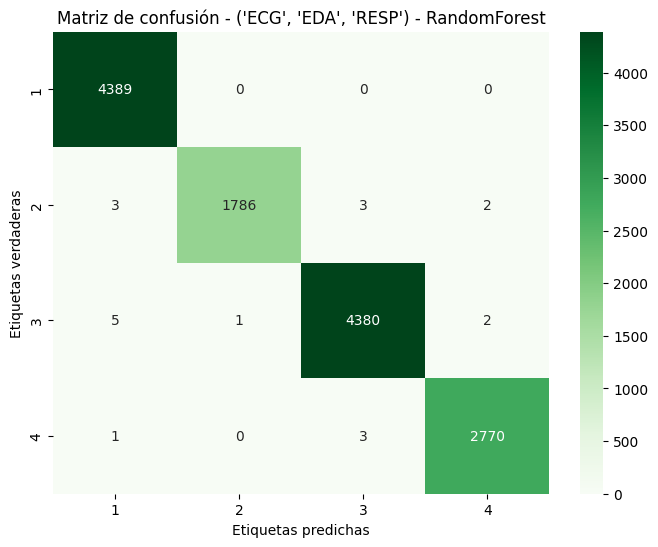

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      1.00      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                              Etapa
0   Accuracy  0.811465  ('ECG', 'EDA', 'RESP') - AdaBoost
1  Precision  0.816758  ('ECG', 'EDA', 'RESP') - AdaBoost
2     Recall  0.811465  ('ECG', 'EDA', 'RESP') - AdaBoost
3   F1 Score  0.813311  ('ECG', 'EDA', 'RESP') - AdaBoost
[('ECG', 'EDA', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanc

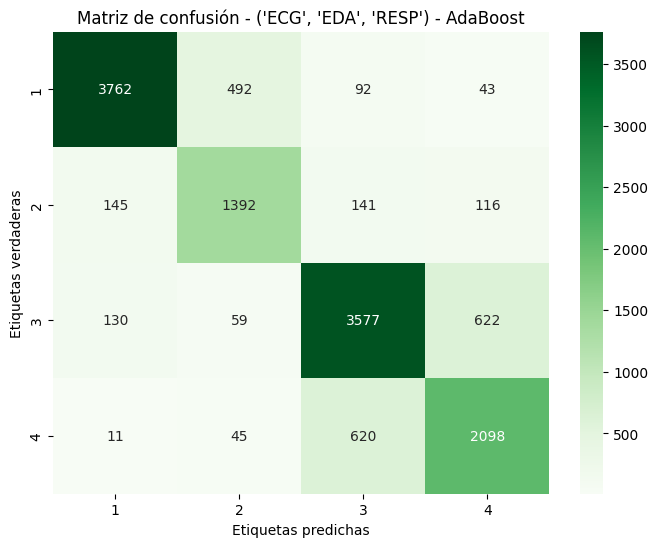

              precision    recall  f1-score   support

           1       0.93      0.86      0.89      4389
           2       0.70      0.78      0.74      1794
           3       0.81      0.82      0.81      4388
           4       0.73      0.76      0.74      2774

    accuracy                           0.81     13345
   macro avg       0.79      0.80      0.80     13345
weighted avg       0.82      0.81      0.81     13345

Training LDA model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'EDA', 'RESP') - LDA Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.531660  ('ECG', 'EDA', 'RESP') - LDA
1  Precision  0.509843  ('ECG', 'EDA', 'RESP') - LDA
2     Recall  0.531660  ('ECG', 'EDA', 'RESP') - LDA
3   F1 Score  0.490538  ('ECG', 'EDA', 'RESP') - LDA
[('ECG', 'EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'EDA', 'RESP') - LDA] Accuracy: 0.5317
('ECG', 'EDA', 'RESP') - LDA - Con

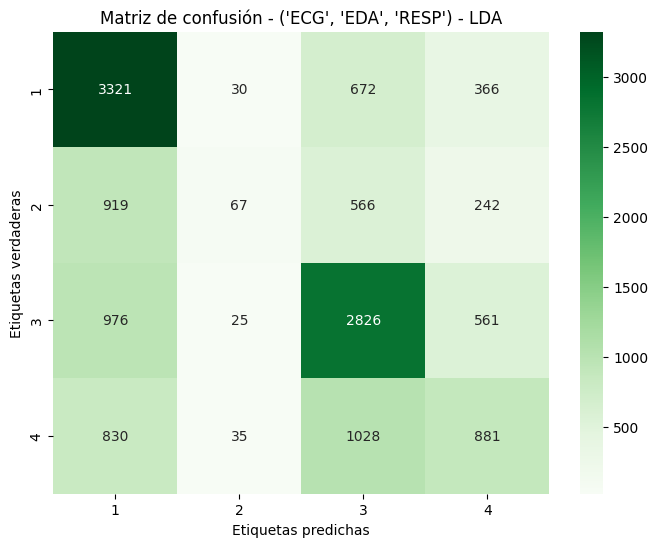

              precision    recall  f1-score   support

           1       0.55      0.76      0.64      4389
           2       0.43      0.04      0.07      1794
           3       0.55      0.64      0.60      4388
           4       0.43      0.32      0.37      2774

    accuracy                           0.53     13345
   macro avg       0.49      0.44      0.42     13345
weighted avg       0.51      0.53      0.49     13345

Training KNN model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'EDA', 'RESP') - KNN Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.586212  ('ECG', 'EDA', 'RESP') - KNN
1  Precision  0.582349  ('ECG', 'EDA', 'RESP') - KNN
2     Recall  0.586212  ('ECG', 'EDA', 'RESP') - KNN
3   F1 Score  0.583383  ('ECG', 'EDA', 'RESP') - KNN
[('ECG', 'EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'EDA', 'RESP') - KNN] Accuracy: 0.5862
('ECG', '

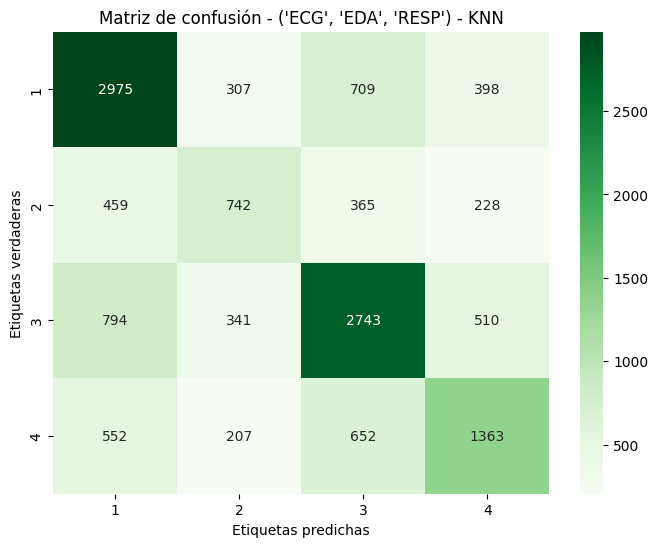

Training by signal combinations:  82%|████████▏ | 9/11 [16:00:31<3:42:52, 6686.42s/it]

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      4389
           2       0.46      0.41      0.44      1794
           3       0.61      0.63      0.62      4388
           4       0.55      0.49      0.52      2774

    accuracy                           0.59     13345
   macro avg       0.56      0.55      0.56     13345
weighted avg       0.58      0.59      0.58     13345

Training DecisionTree model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('PPG', 'EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.649532  ('PPG', 'EDA', 'RESP') - DecisionTree
1  Precision  0.700319  ('PPG', 'EDA', 'RESP') - DecisionTree
2     Recall  0.649532  ('PPG', 'EDA', 'RESP') - DecisionTree
3   F1 Score  0.656334  ('PPG', 'EDA', 'RESP') - DecisionTree
[('PPG', 'EDA', 'RESP') - DecisionTree] Best Params: {'criterion': 'entropy',

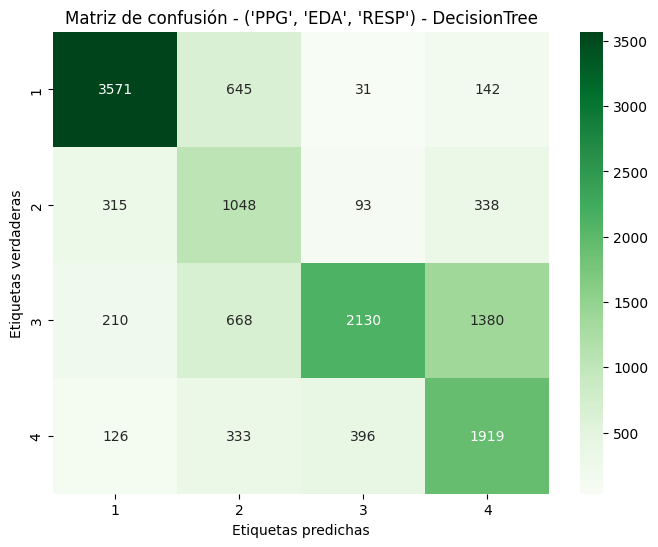

              precision    recall  f1-score   support

           1       0.85      0.81      0.83      4389
           2       0.39      0.58      0.47      1794
           3       0.80      0.49      0.61      4388
           4       0.51      0.69      0.59      2774

    accuracy                           0.65     13345
   macro avg       0.64      0.64      0.62     13345
weighted avg       0.70      0.65      0.66     13345

Training RandomForest model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('PPG', 'EDA', 'RESP') - RandomForest Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.999101  ('PPG', 'EDA', 'RESP') - RandomForest
1  Precision  0.999101  ('PPG', 'EDA', 'RESP') - RandomForest
2     Recall  0.999101  ('PPG', 'EDA', 'RESP') - RandomForest
3   F1 Score  0.999101  ('PPG', 'EDA', 'RESP') - RandomForest
[('PPG', 'EDA', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_f

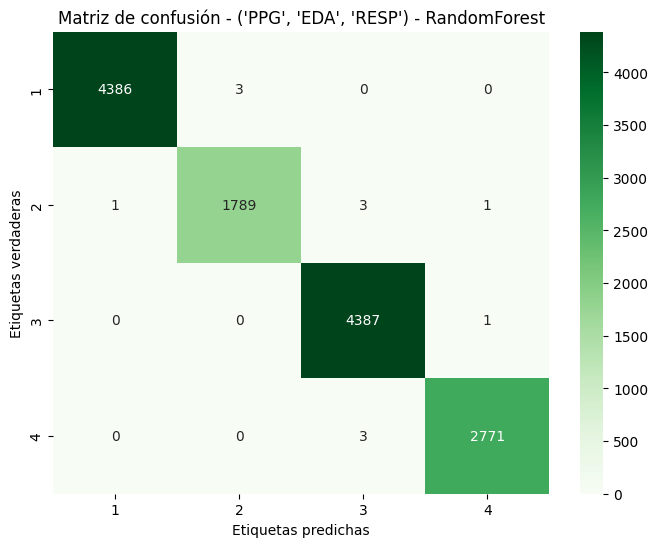

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      1.00      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('PPG', 'EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                              Etapa
0   Accuracy  0.826227  ('PPG', 'EDA', 'RESP') - AdaBoost
1  Precision  0.834079  ('PPG', 'EDA', 'RESP') - AdaBoost
2     Recall  0.826227  ('PPG', 'EDA', 'RESP') - AdaBoost
3   F1 Score  0.828747  ('PPG', 'EDA', 'RESP') - AdaBoost
[('PPG', 'EDA', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanc

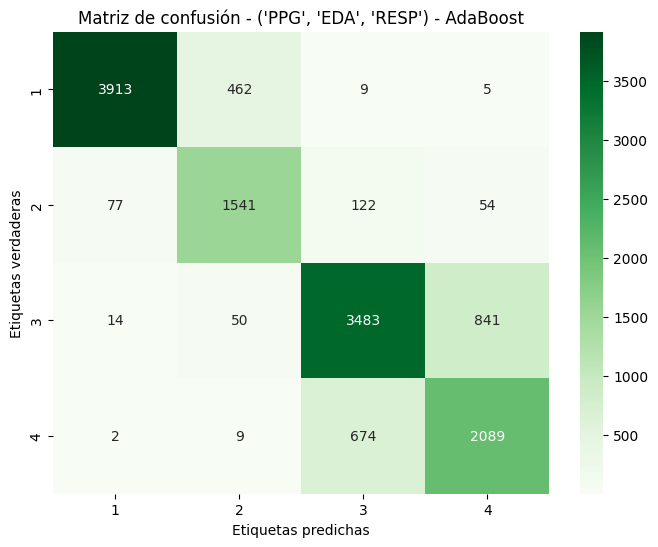

              precision    recall  f1-score   support

           1       0.98      0.89      0.93      4389
           2       0.75      0.86      0.80      1794
           3       0.81      0.79      0.80      4388
           4       0.70      0.75      0.72      2774

    accuracy                           0.83     13345
   macro avg       0.81      0.82      0.81     13345
weighted avg       0.83      0.83      0.83     13345

Training LDA model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('PPG', 'EDA', 'RESP') - LDA Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.617685  ('PPG', 'EDA', 'RESP') - LDA
1  Precision  0.595606  ('PPG', 'EDA', 'RESP') - LDA
2     Recall  0.617685  ('PPG', 'EDA', 'RESP') - LDA
3   F1 Score  0.587590  ('PPG', 'EDA', 'RESP') - LDA
[('PPG', 'EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('PPG', 'EDA', 'RESP') - LDA] Accuracy: 0.6177
('PPG', 'EDA', 'RESP') - LDA - Con

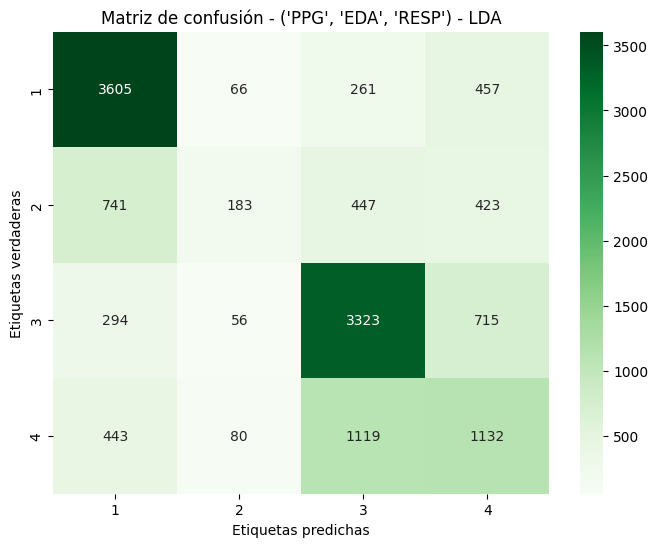

              precision    recall  f1-score   support

           1       0.71      0.82      0.76      4389
           2       0.48      0.10      0.17      1794
           3       0.65      0.76      0.70      4388
           4       0.42      0.41      0.41      2774

    accuracy                           0.62     13345
   macro avg       0.56      0.52      0.51     13345
weighted avg       0.60      0.62      0.59     13345

Training KNN model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('PPG', 'EDA', 'RESP') - KNN Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.990408  ('PPG', 'EDA', 'RESP') - KNN
1  Precision  0.990407  ('PPG', 'EDA', 'RESP') - KNN
2     Recall  0.990408  ('PPG', 'EDA', 'RESP') - KNN
3   F1 Score  0.990408  ('PPG', 'EDA', 'RESP') - KNN
[('PPG', 'EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('PPG', 'EDA', 'RESP') - KNN] Accuracy: 0.9904
('PPG', '

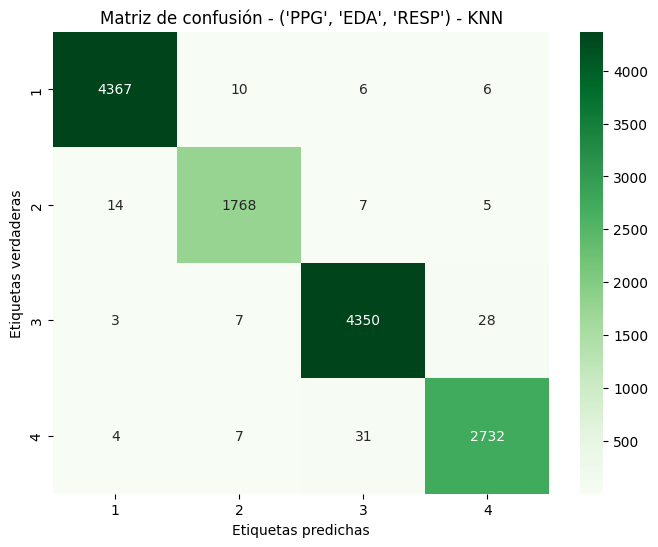

Training by signal combinations:  91%|█████████ | 10/11 [17:55:09<1:52:25, 6745.36s/it]

              precision    recall  f1-score   support

           1       1.00      0.99      1.00      4389
           2       0.99      0.99      0.99      1794
           3       0.99      0.99      0.99      4388
           4       0.99      0.98      0.99      2774

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training DecisionTree model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                         Etapa
0   Accuracy  0.662121  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
1  Precision  0.701403  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
2     Recall  0.662121  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
3   F1 Score  0.668136  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
[('ECG', 'PPG', 'EDA', 'RESP

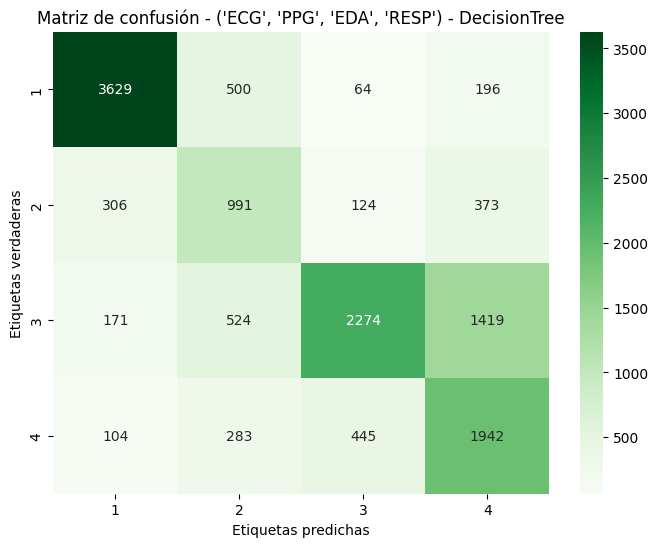

              precision    recall  f1-score   support

           1       0.86      0.83      0.84      4389
           2       0.43      0.55      0.48      1794
           3       0.78      0.52      0.62      4388
           4       0.49      0.70      0.58      2774

    accuracy                           0.66     13345
   macro avg       0.64      0.65      0.63     13345
weighted avg       0.70      0.66      0.67     13345

Training RandomForest model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG', 'EDA', 'RESP') - RandomForest Metrics
     Métrica     Valor                                         Etapa
0   Accuracy  0.999026  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
1  Precision  0.999026  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
2     Recall  0.999026  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
3   F1 Score  0.999026  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
[('ECG', 'PPG', 'EDA', 'RESP

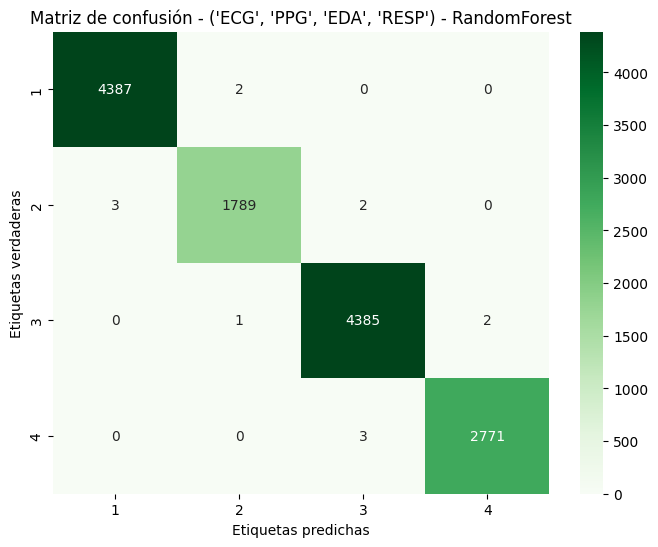

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      1.00      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                                     Etapa
0   Accuracy  0.830199  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
1  Precision  0.832783  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
2     Recall  0.830199  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
3   F1 Score  0.830476  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
[('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost] Best Params: {

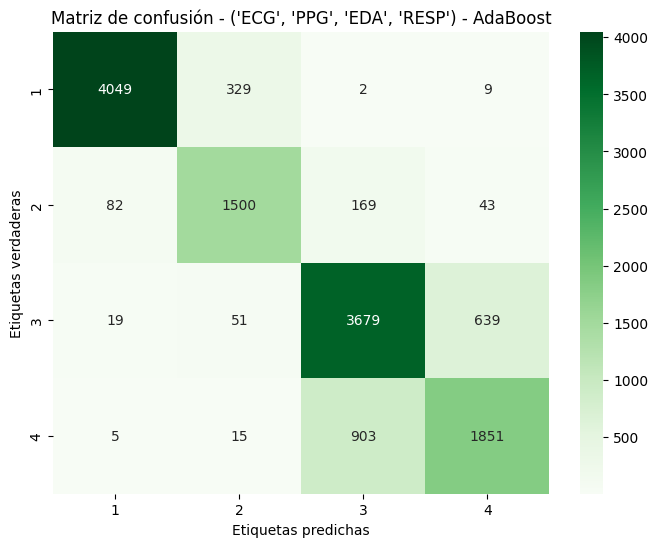

              precision    recall  f1-score   support

           1       0.97      0.92      0.95      4389
           2       0.79      0.84      0.81      1794
           3       0.77      0.84      0.80      4388
           4       0.73      0.67      0.70      2774

    accuracy                           0.83     13345
   macro avg       0.82      0.82      0.82     13345
weighted avg       0.83      0.83      0.83     13345

Training LDA model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG', 'EDA', 'RESP') - LDA Metrics
     Métrica     Valor                                Etapa
0   Accuracy  0.629449  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
1  Precision  0.610578  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
2     Recall  0.629449  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
3   F1 Score  0.604154  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
[('ECG', 'PPG', 'EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG', 'EDA', 'RE

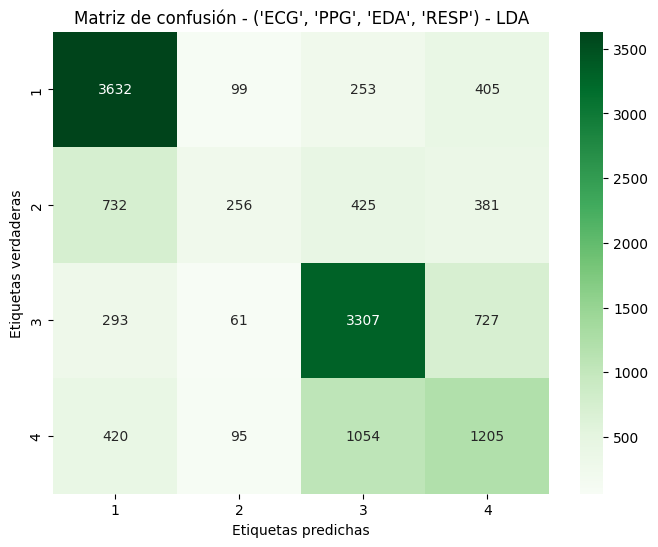

              precision    recall  f1-score   support

           1       0.72      0.83      0.77      4389
           2       0.50      0.14      0.22      1794
           3       0.66      0.75      0.70      4388
           4       0.44      0.43      0.44      2774

    accuracy                           0.63     13345
   macro avg       0.58      0.54      0.53     13345
weighted avg       0.61      0.63      0.60     13345

Training KNN model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG', 'EDA', 'RESP') - KNN Metrics
     Métrica     Valor                                Etapa
0   Accuracy  0.589809  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
1  Precision  0.586069  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
2     Recall  0.589809  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
3   F1 Score  0.587023  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
[('ECG', 'PPG', 'EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[

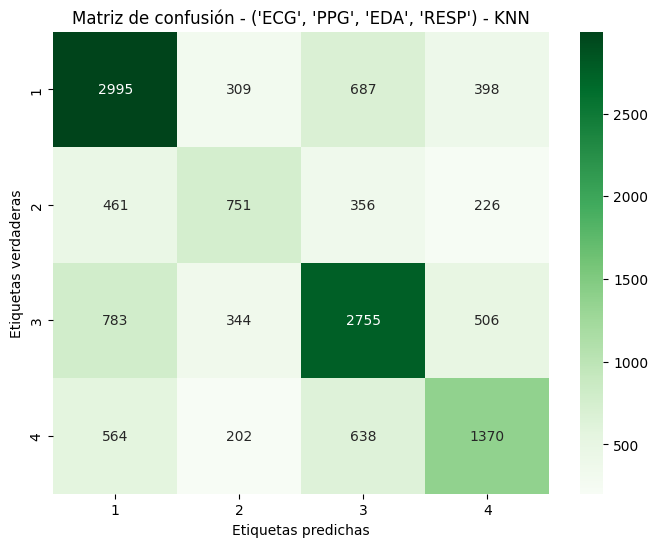

Training by signal combinations: 100%|██████████| 11/11 [20:14:17<00:00, 6623.37s/it]  

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      4389
           2       0.47      0.42      0.44      1794
           3       0.62      0.63      0.62      4388
           4       0.55      0.49      0.52      2774

    accuracy                           0.59     13345
   macro avg       0.57      0.56      0.56     13345
weighted avg       0.59      0.59      0.59     13345


Final Comparison:
('ECG', 'PPG') - DecisionTree:
     Métrica     Valor                          Etapa
0   Accuracy  0.588985  ('ECG', 'PPG') - DecisionTree
1  Precision  0.670306  ('ECG', 'PPG') - DecisionTree
2     Recall  0.588985  ('ECG', 'PPG') - DecisionTree
3   F1 Score  0.612152  ('ECG', 'PPG') - DecisionTree
('ECG', 'PPG') - RandomForest:
     Métrica     Valor                          Etapa
0   Accuracy  0.990259  ('ECG', 'PPG') - RandomForest
1  Precision  0.990265  ('ECG', 'PPG') - RandomForest
2     Recall  0.990259  ('ECG', 'PPG') - RandomFores

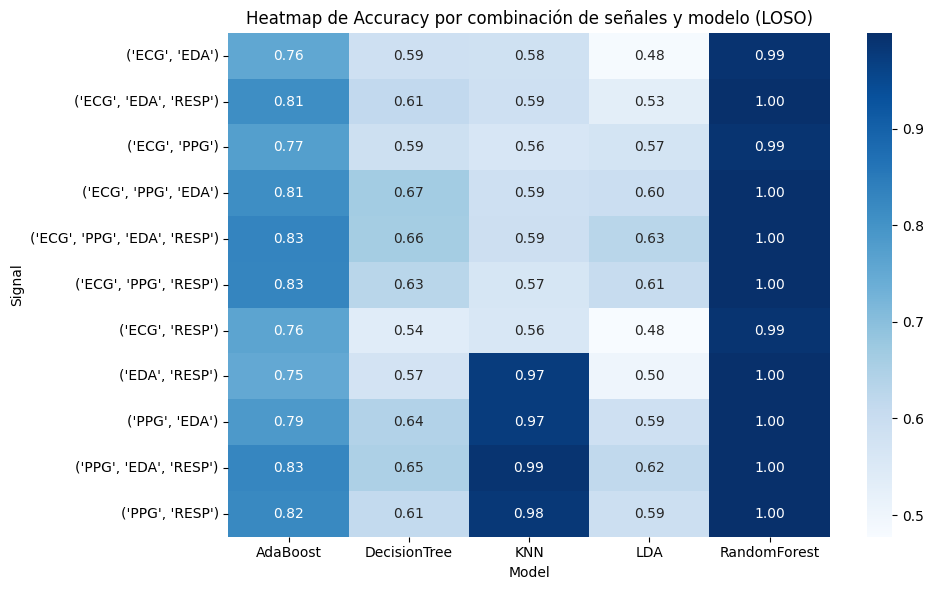

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
C:\Users\Gustavo\AppData\Local\Temp\ipyk

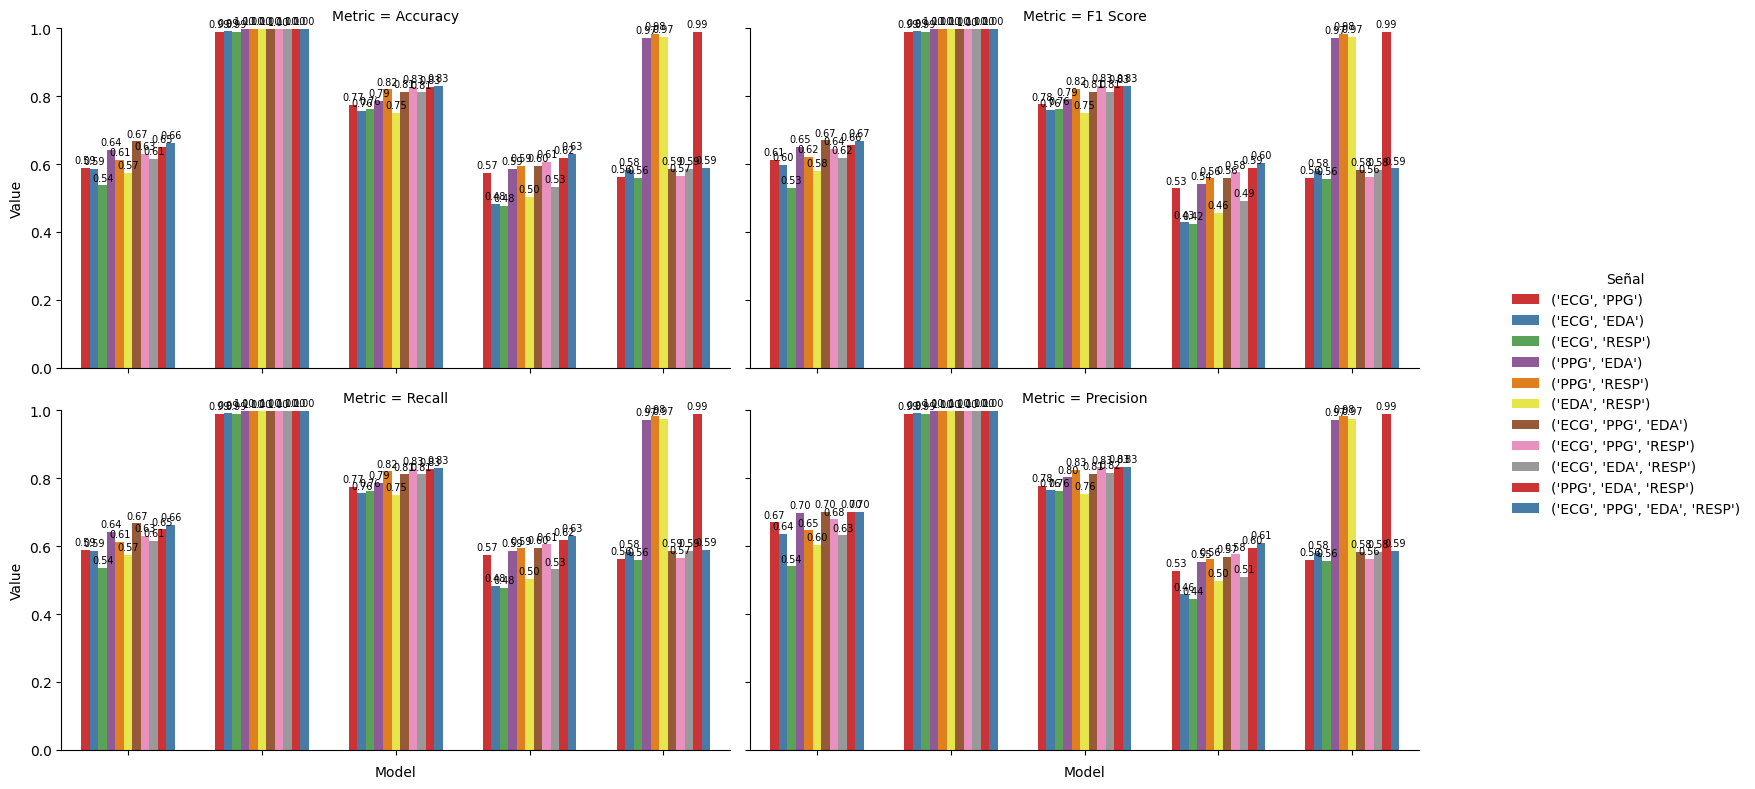

In [85]:
for combo in tqdm(combinations, desc="Training by signal combinations"):
    features = sum([SIGNAL_CATEGORIES[signal] for signal in combo], [])
    if all(f in df.columns for f in features):# Verificar que todas las columnas existen
        X = df[features]
        y = df['label']
        subjects = df['subject'] # Se agrega el identificador de sujetos para LOSO

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {combo} using LOSO...')
            metrics = train_and_evaluate(X, y, model, param_grid, model_name, combo)
        
            # Convertir diccionario de métricas a DataFrame con mismo formato que antes
            results[(combo, model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (combo, model_name), acc in results.items():
    print(f'{combo} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (combo, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']

    row = {
    'Signal': combo,
    'Model': model,
    'Accuracy': metric_values.get('Accuracy', None),
    'F1': metric_values.get('F1 Score', None),
    'Precision': metric_values.get('Precision', None),
    'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por combinación de señales y modelo (LOSO)')
plt.tight_layout()
plt.show()

data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (combo, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((combo, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [40]:
print(wa)

NameError: name 'wa' is not defined

Training by signal:   0%|          | 0/4 [00:00<?, ?it/s]

Training DecisionTree model for ECG...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
ECG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.426637  ECG - DecisionTree
1  Precision  0.524099  ECG - DecisionTree
2     Recall  0.426637  ECG - DecisionTree
3   F1 Score  0.356113  ECG - DecisionTree
[ECG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_split': 2}
[ECG - DecisionTree] Accuracy: 0.4266
ECG - DecisionTree - Confusion Matrix
[[6270   15  231   67]
 [2297  230  114   51]
 [4466  228 1473  415]
 [3266   78  249  567]]


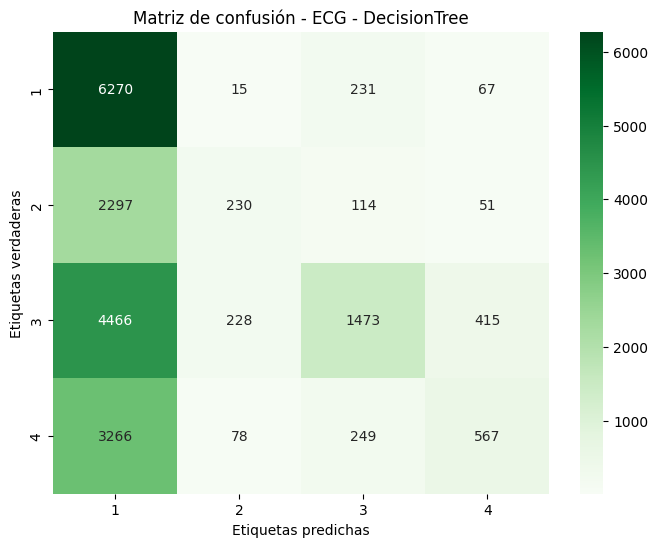

              precision    recall  f1-score   support

           1       0.38      0.95      0.55      6583
           2       0.42      0.09      0.14      2692
           3       0.71      0.22      0.34      6582
           4       0.52      0.14      0.22      4160

    accuracy                           0.43     20017
   macro avg       0.51      0.35      0.31     20017
weighted avg       0.52      0.43      0.36     20017

Training RandomForest model for ECG...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
ECG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.942499  ECG - RandomForest
1  Precision  0.943431  ECG - RandomForest
2     Recall  0.942499  ECG - RandomForest
3   F1 Score  0.942231  ECG - RandomForest
[ECG - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[ECG - RandomForest] Accuracy: 0.9425
ECG - RandomForest - Confusion Matrix
[[6393   21  114   55]
 [ 203 2322  127   40]
 

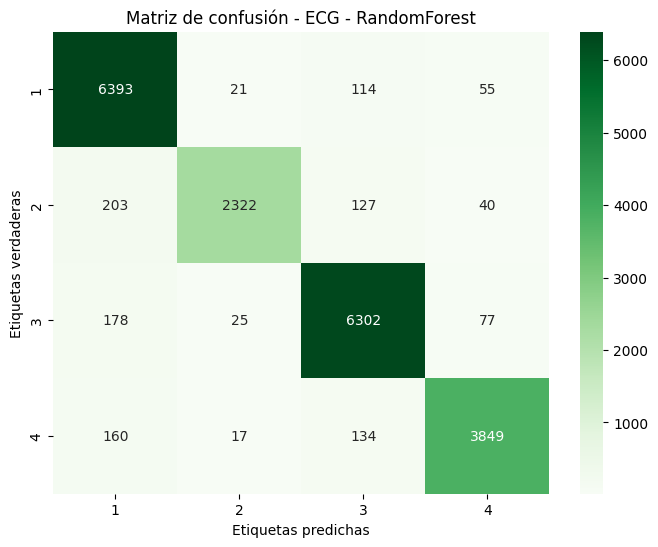

              precision    recall  f1-score   support

           1       0.92      0.97      0.95      6583
           2       0.97      0.86      0.91      2692
           3       0.94      0.96      0.95      6582
           4       0.96      0.93      0.94      4160

    accuracy                           0.94     20017
   macro avg       0.95      0.93      0.94     20017
weighted avg       0.94      0.94      0.94     20017

Training AdaBoost model for ECG...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ECG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.586152  ECG - AdaBoost
1  Precision  0.581555  ECG - AdaBoost
2     Recall  0.586152  ECG - AdaBoost
3   F1 Score  0.580388  ECG - AdaBoost
[ECG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[ECG - AdaBoost] Accuracy: 0.5862
ECG - AdaBoost - Confusion Matrix
[[4478  615  995  495]
 [ 947  885  631  229]
 [1388  285 

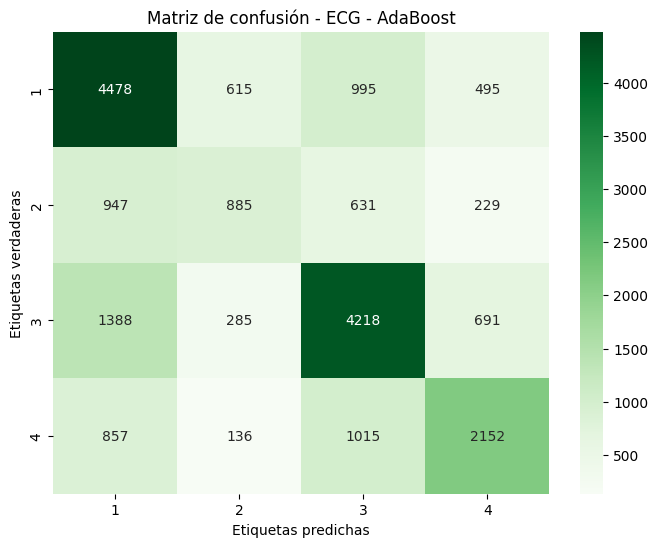

              precision    recall  f1-score   support

           1       0.58      0.68      0.63      6583
           2       0.46      0.33      0.38      2692
           3       0.61      0.64      0.63      6582
           4       0.60      0.52      0.56      4160

    accuracy                           0.59     20017
   macro avg       0.57      0.54      0.55     20017
weighted avg       0.58      0.59      0.58     20017

Training LDA model for ECG...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ECG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.415197  ECG - LDA
1  Precision  0.417248  ECG - LDA
2     Recall  0.415197  ECG - LDA
3   F1 Score  0.358256  ECG - LDA
[ECG - LDA] Best Params: {'solver': 'svd'}
[ECG - LDA] Accuracy: 0.4152
ECG - LDA - Confusion Matrix
[[4671    8 1578  326]
 [1610   11  925  146]
 [2983    3 3145  451]
 [2123    0 1553  484]]


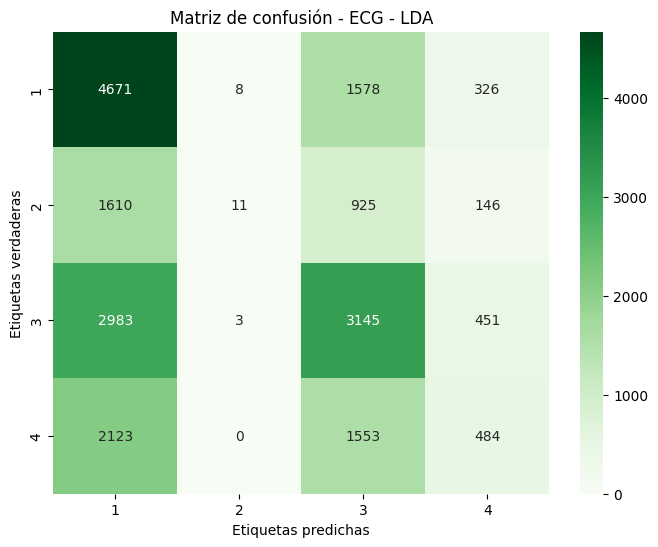

              precision    recall  f1-score   support

           1       0.41      0.71      0.52      6583
           2       0.50      0.00      0.01      2692
           3       0.44      0.48      0.46      6582
           4       0.34      0.12      0.17      4160

    accuracy                           0.42     20017
   macro avg       0.42      0.33      0.29     20017
weighted avg       0.42      0.42      0.36     20017

Training KNN model for ECG...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ECG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.657541  ECG - KNN
1  Precision  0.655851  ECG - KNN
2     Recall  0.657541  ECG - KNN
3   F1 Score  0.655284  ECG - KNN
[ECG - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[ECG - KNN] Accuracy: 0.6575
ECG - KNN - Confusion Matrix
[[4809  326  942  506]
 [ 567 1394  507  224]
 [1073  323 4556  630]
 [ 774  224  759 2403]]


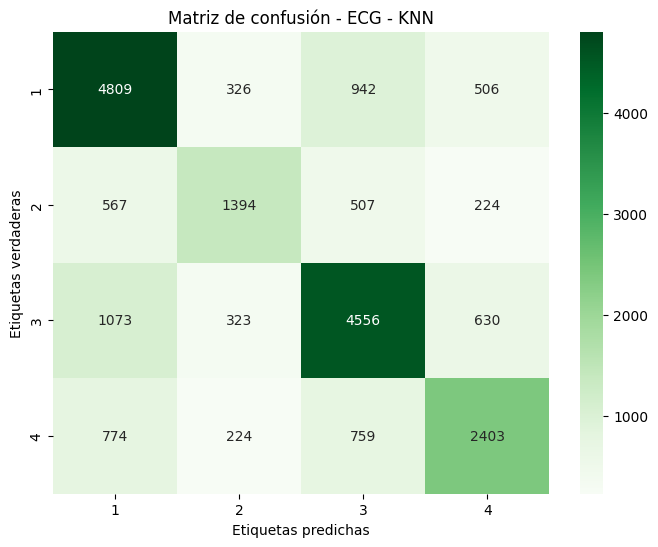

Training by signal:  25%|██▌       | 1/4 [44:06<2:12:20, 2646.71s/it]

              precision    recall  f1-score   support

           1       0.67      0.73      0.70      6583
           2       0.61      0.52      0.56      2692
           3       0.67      0.69      0.68      6582
           4       0.64      0.58      0.61      4160

    accuracy                           0.66     20017
   macro avg       0.65      0.63      0.64     20017
weighted avg       0.66      0.66      0.66     20017

Training DecisionTree model for PPG...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
PPG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.589749  PPG - DecisionTree
1  Precision  0.657386  PPG - DecisionTree
2     Recall  0.589749  PPG - DecisionTree
3   F1 Score  0.611145  PPG - DecisionTree
[PPG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[PPG - DecisionTree] Accuracy: 0.5897
PPG - DecisionTree - Confusion Matrix
[[4480 1182  122  799]
 [ 6

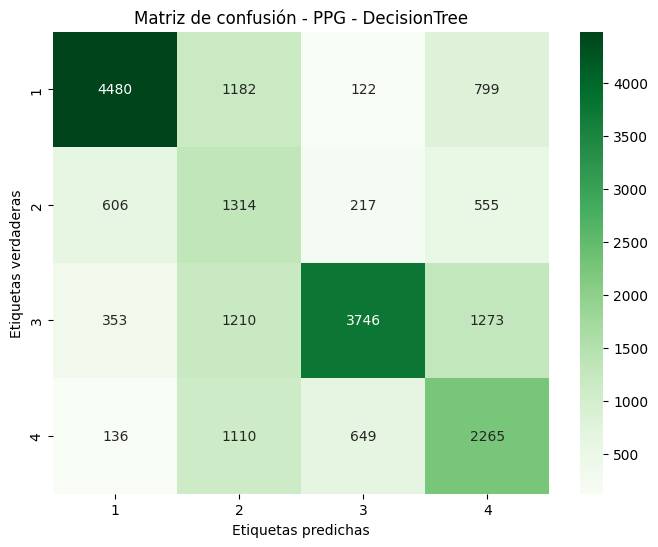

              precision    recall  f1-score   support

           1       0.80      0.68      0.74      6583
           2       0.27      0.49      0.35      2692
           3       0.79      0.57      0.66      6582
           4       0.46      0.54      0.50      4160

    accuracy                           0.59     20017
   macro avg       0.58      0.57      0.56     20017
weighted avg       0.66      0.59      0.61     20017

Training RandomForest model for PPG...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
PPG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.995204  PPG - RandomForest
1  Precision  0.995213  PPG - RandomForest
2     Recall  0.995204  PPG - RandomForest
3   F1 Score  0.995199  PPG - RandomForest
[PPG - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[PPG - RandomForest] Accuracy: 0.9952
PPG - RandomForest - Confusion Matrix
[[6574    2    2    5]
 [  27 2652    9    4]
 

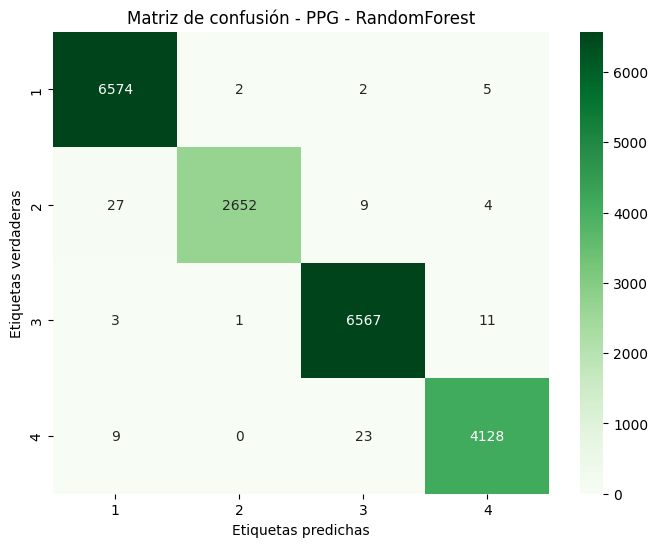

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      6583
           2       1.00      0.99      0.99      2692
           3       0.99      1.00      1.00      6582
           4       1.00      0.99      0.99      4160

    accuracy                           1.00     20017
   macro avg       1.00      0.99      0.99     20017
weighted avg       1.00      1.00      1.00     20017

Training AdaBoost model for PPG...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
PPG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.774192  PPG - AdaBoost
1  Precision  0.775871  PPG - AdaBoost
2     Recall  0.774192  PPG - AdaBoost
3   F1 Score  0.774591  PPG - AdaBoost
[PPG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[PPG - AdaBoost] Accuracy: 0.7742
PPG - AdaBoost - Confusion Matrix
[[5728  562  141  152]
 [ 520 1599  283  290]
 [ 153  213 

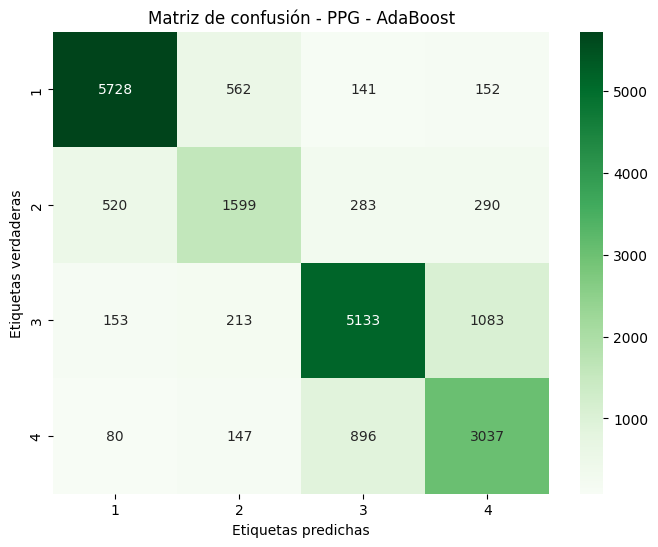

              precision    recall  f1-score   support

           1       0.88      0.87      0.88      6583
           2       0.63      0.59      0.61      2692
           3       0.80      0.78      0.79      6582
           4       0.67      0.73      0.70      4160

    accuracy                           0.77     20017
   macro avg       0.74      0.74      0.74     20017
weighted avg       0.78      0.77      0.77     20017

Training LDA model for PPG...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
PPG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.561573  PPG - LDA
1  Precision  0.519806  PPG - LDA
2     Recall  0.561573  PPG - LDA
3   F1 Score  0.508671  PPG - LDA
[PPG - LDA] Best Params: {'solver': 'svd'}
[PPG - LDA] Accuracy: 0.5616
PPG - LDA - Confusion Matrix
[[5087   28  773  695]
 [1208   29  919  536]
 [ 670    4 5105  803]
 [ 767   16 2357 1020]]


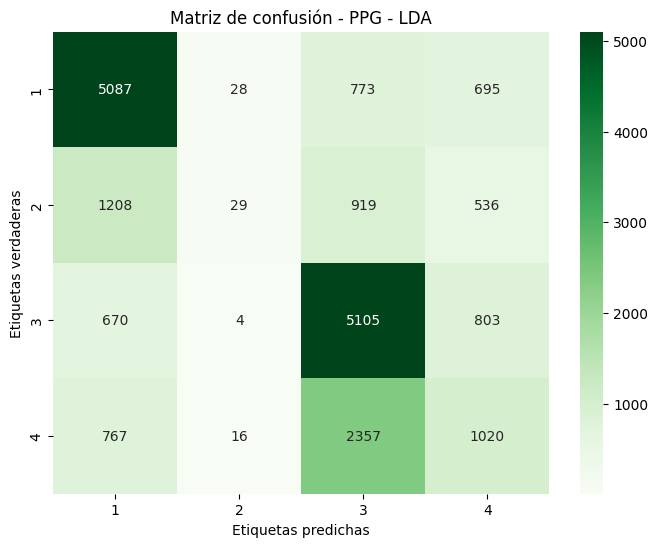

              precision    recall  f1-score   support

           1       0.66      0.77      0.71      6583
           2       0.38      0.01      0.02      2692
           3       0.56      0.78      0.65      6582
           4       0.33      0.25      0.28      4160

    accuracy                           0.56     20017
   macro avg       0.48      0.45      0.42     20017
weighted avg       0.52      0.56      0.51     20017

Training KNN model for PPG...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
PPG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.882949  PPG - KNN
1  Precision  0.882701  PPG - KNN
2     Recall  0.882949  PPG - KNN
3   F1 Score  0.882814  PPG - KNN
[PPG - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[PPG - KNN] Accuracy: 0.8829
PPG - KNN - Confusion Matrix
[[6066  182  170  165]
 [ 207 2170  159  156]
 [ 137  176 5944  325]
 [ 198  121  347 3494]]


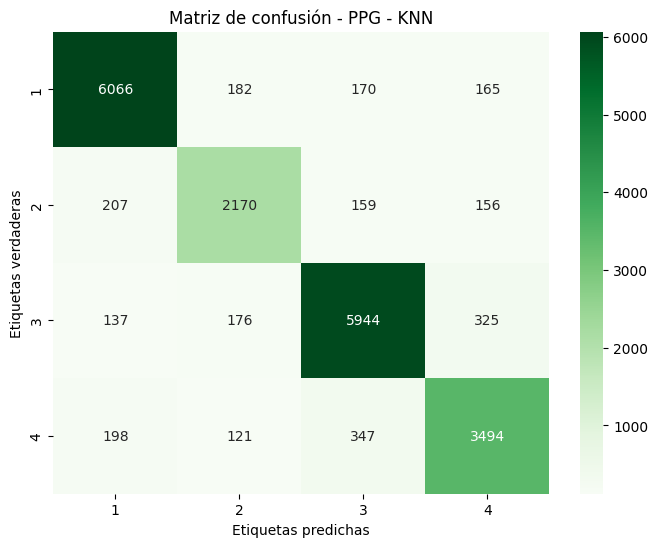

Training by signal:  50%|█████     | 2/4 [1:26:26<1:26:07, 2583.98s/it]

              precision    recall  f1-score   support

           1       0.92      0.92      0.92      6583
           2       0.82      0.81      0.81      2692
           3       0.90      0.90      0.90      6582
           4       0.84      0.84      0.84      4160

    accuracy                           0.88     20017
   macro avg       0.87      0.87      0.87     20017
weighted avg       0.88      0.88      0.88     20017

Training DecisionTree model for EDA...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
EDA - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.518559  EDA - DecisionTree
1  Precision  0.592203  EDA - DecisionTree
2     Recall  0.518559  EDA - DecisionTree
3   F1 Score  0.531905  EDA - DecisionTree
[EDA - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[EDA - DecisionTree] Accuracy: 0.5186
EDA - DecisionTree - Confusion Matrix
[[3474 1106  747 1256]
 [ 2

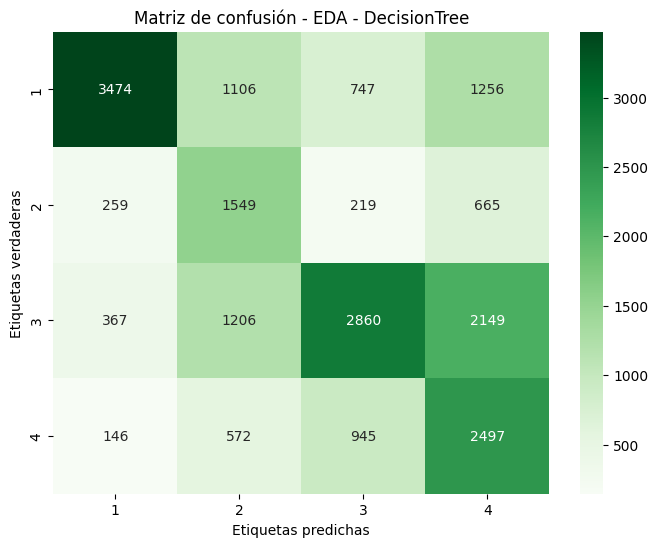

              precision    recall  f1-score   support

           1       0.82      0.53      0.64      6583
           2       0.35      0.58      0.43      2692
           3       0.60      0.43      0.50      6582
           4       0.38      0.60      0.47      4160

    accuracy                           0.52     20017
   macro avg       0.54      0.53      0.51     20017
weighted avg       0.59      0.52      0.53     20017

Training RandomForest model for EDA...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
EDA - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.992656  EDA - RandomForest
1  Precision  0.992669  EDA - RandomForest
2     Recall  0.992656  EDA - RandomForest
3   F1 Score  0.992653  EDA - RandomForest
[EDA - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[EDA - RandomForest] Accuracy: 0.9927
EDA - RandomForest - Confusion Matrix
[[6553    5   18    7]
 [  18 2656   12    6]
 

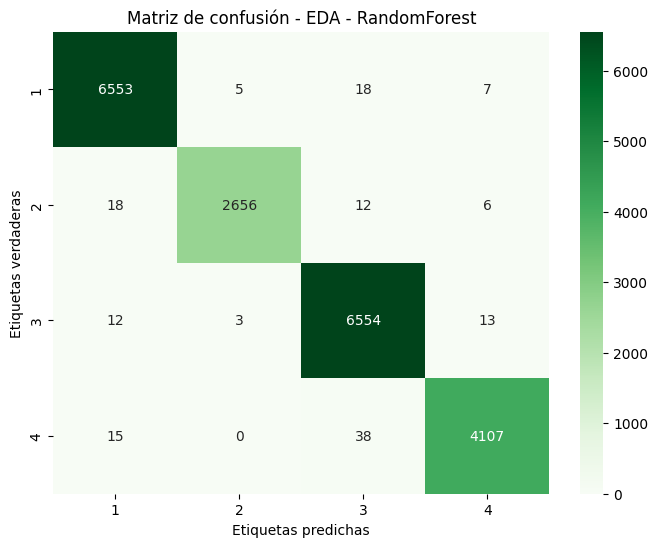

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      6583
           2       1.00      0.99      0.99      2692
           3       0.99      1.00      0.99      6582
           4       0.99      0.99      0.99      4160

    accuracy                           0.99     20017
   macro avg       0.99      0.99      0.99     20017
weighted avg       0.99      0.99      0.99     20017

Training AdaBoost model for EDA...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
EDA - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.640605  EDA - AdaBoost
1  Precision  0.660503  EDA - AdaBoost
2     Recall  0.640605  EDA - AdaBoost
3   F1 Score  0.646235  EDA - AdaBoost
[EDA - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[EDA - AdaBoost] Accuracy: 0.6406
EDA - AdaBoost - Confusion Matrix
[[4104 1329  759  391]
 [ 435 1564  348  345]
 [ 516  589 

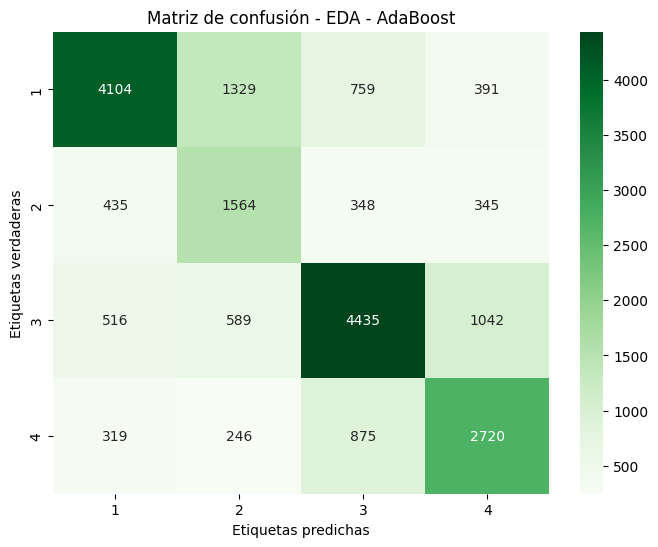

              precision    recall  f1-score   support

           1       0.76      0.62      0.69      6583
           2       0.42      0.58      0.49      2692
           3       0.69      0.67      0.68      6582
           4       0.60      0.65      0.63      4160

    accuracy                           0.64     20017
   macro avg       0.62      0.63      0.62     20017
weighted avg       0.66      0.64      0.65     20017

Training LDA model for EDA...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
EDA - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.417995  EDA - LDA
1  Precision  0.417615  EDA - LDA
2     Recall  0.417995  EDA - LDA
3   F1 Score  0.350615  EDA - LDA
[EDA - LDA] Best Params: {'solver': 'svd'}
[EDA - LDA] Accuracy: 0.4180
EDA - LDA - Confusion Matrix
[[4872    3 1455  253]
 [1466    7 1122   97]
 [3132    0 3182  268]
 [1850    3 2001  306]]


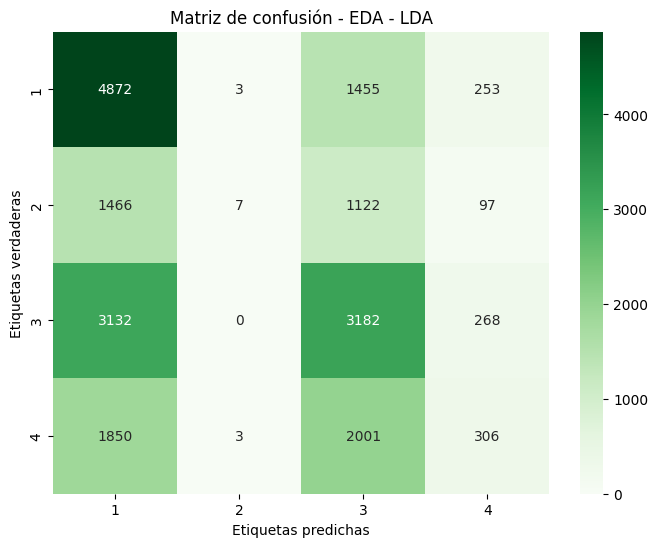

              precision    recall  f1-score   support

           1       0.43      0.74      0.54      6583
           2       0.54      0.00      0.01      2692
           3       0.41      0.48      0.44      6582
           4       0.33      0.07      0.12      4160

    accuracy                           0.42     20017
   macro avg       0.43      0.32      0.28     20017
weighted avg       0.42      0.42      0.35     20017

Training KNN model for EDA...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
EDA - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.923115  EDA - KNN
1  Precision  0.923083  EDA - KNN
2     Recall  0.923115  EDA - KNN
3   F1 Score  0.923096  EDA - KNN
[EDA - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[EDA - KNN] Accuracy: 0.9231
EDA - KNN - Confusion Matrix
[[6205  107  166  105]
 [ 105 2427  100   60]
 [ 189   94 6088  211]
 [ 107   68  227 3758]]


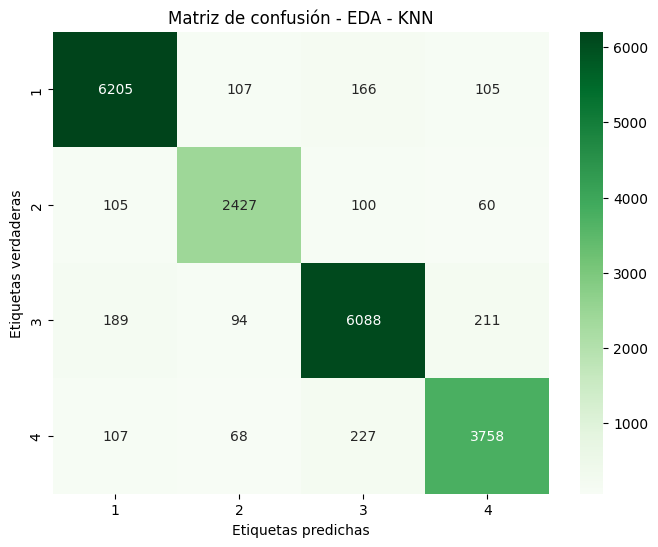

Training by signal:  75%|███████▌  | 3/4 [2:00:41<39:02, 2342.25s/it]  

              precision    recall  f1-score   support

           1       0.94      0.94      0.94      6583
           2       0.90      0.90      0.90      2692
           3       0.93      0.92      0.93      6582
           4       0.91      0.90      0.91      4160

    accuracy                           0.92     20017
   macro avg       0.92      0.92      0.92     20017
weighted avg       0.92      0.92      0.92     20017

Training DecisionTree model for RESP...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
RESP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.454064  RESP - DecisionTree
1  Precision  0.475188  RESP - DecisionTree
2     Recall  0.454064  RESP - DecisionTree
3   F1 Score  0.453421  RESP - DecisionTree
[RESP - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_split': 2}
[RESP - DecisionTree] Accuracy: 0.4541
RESP - DecisionTree - Confusion Matrix
[[2399 1299 1615 

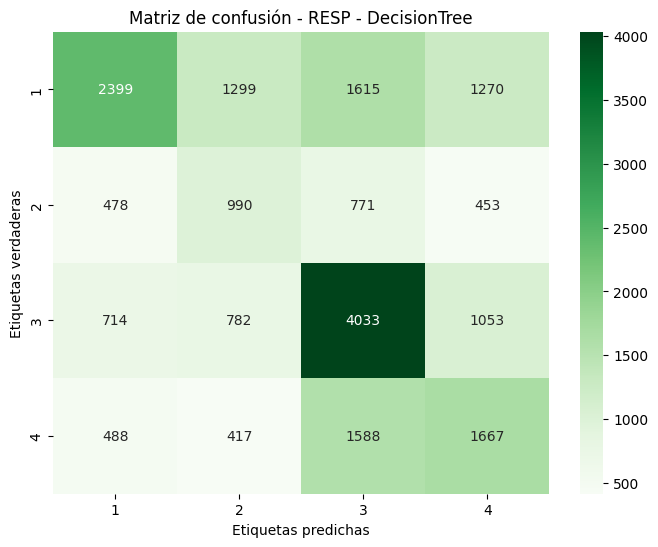

              precision    recall  f1-score   support

           1       0.59      0.36      0.45      6583
           2       0.28      0.37      0.32      2692
           3       0.50      0.61      0.55      6582
           4       0.38      0.40      0.39      4160

    accuracy                           0.45     20017
   macro avg       0.44      0.44      0.43     20017
weighted avg       0.48      0.45      0.45     20017

Training RandomForest model for RESP...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
RESP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.991807  RESP - RandomForest
1  Precision  0.991833  RESP - RandomForest
2     Recall  0.991807  RESP - RandomForest
3   F1 Score  0.991806  RESP - RandomForest
[RESP - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[RESP - RandomForest] Accuracy: 0.9918
RESP - RandomForest - Confusion Matrix
[[6547    2   28    6]
 [  13 2658   

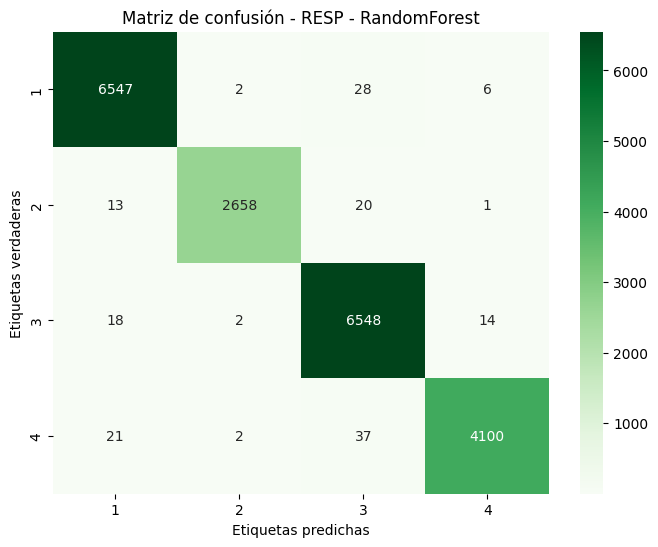

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      6583
           2       1.00      0.99      0.99      2692
           3       0.99      0.99      0.99      6582
           4       0.99      0.99      0.99      4160

    accuracy                           0.99     20017
   macro avg       0.99      0.99      0.99     20017
weighted avg       0.99      0.99      0.99     20017

Training AdaBoost model for RESP...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
RESP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.676475  RESP - AdaBoost
1  Precision  0.680425  RESP - AdaBoost
2     Recall  0.676475  RESP - AdaBoost
3   F1 Score  0.672559  RESP - AdaBoost
[RESP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[RESP - AdaBoost] Accuracy: 0.6765
RESP - AdaBoost - Confusion Matrix
[[4961  192 1043  387]
 [ 641 1481  445  125]
 [

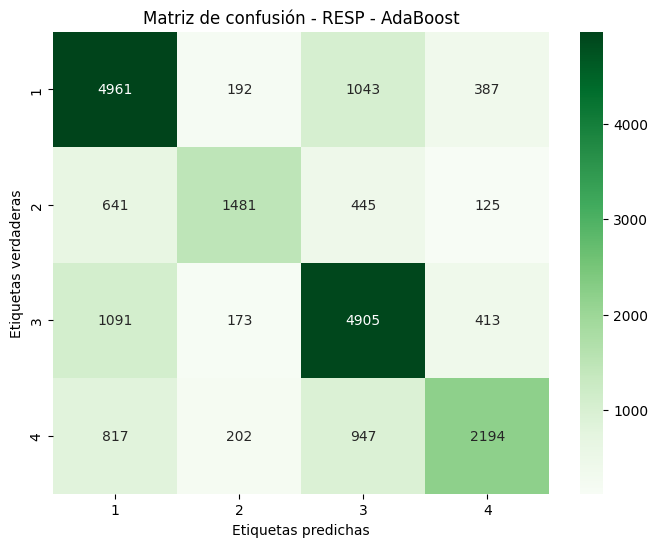

              precision    recall  f1-score   support

           1       0.66      0.75      0.70      6583
           2       0.72      0.55      0.62      2692
           3       0.67      0.75      0.70      6582
           4       0.70      0.53      0.60      4160

    accuracy                           0.68     20017
   macro avg       0.69      0.64      0.66     20017
weighted avg       0.68      0.68      0.67     20017

Training LDA model for RESP...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
RESP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.438477  RESP - LDA
1  Precision  0.496975  RESP - LDA
2     Recall  0.438477  RESP - LDA
3   F1 Score  0.363873  RESP - LDA
[RESP - LDA] Best Params: {'solver': 'svd'}
[RESP - LDA] Accuracy: 0.4385
RESP - LDA - Confusion Matrix
[[4372    0 2051  160]
 [1782    0  837   73]
 [2222    0 4222  138]
 [2495    0 1482  183]]


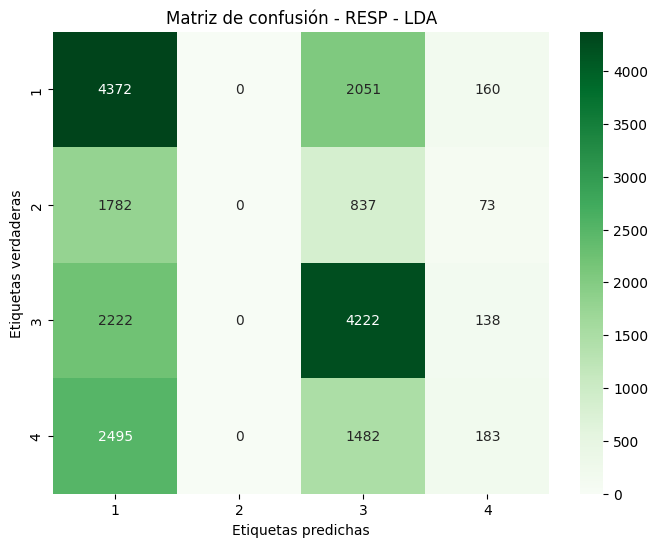

              precision    recall  f1-score   support

           1       0.40      0.66      0.50      6583
           2       0.00      0.00      0.00      2692
           3       0.49      0.64      0.56      6582
           4       0.33      0.04      0.08      4160

    accuracy                           0.44     20017
   macro avg       0.31      0.34      0.28     20017
weighted avg       0.36      0.44      0.36     20017

Training KNN model for RESP...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RESP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.976670  RESP - KNN
1  Precision  0.976686  RESP - KNN
2     Recall  0.976670  RESP - KNN
3   F1 Score  0.976669  RESP - KNN
[RESP - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[RESP - KNN] Accuracy: 0.9767
RESP - KNN - Confusion Matrix
[[6466   25   46   46]
 [  36 2613   29   14]
 [  78   27 6410   67]
 [  34   12   53 4061]]


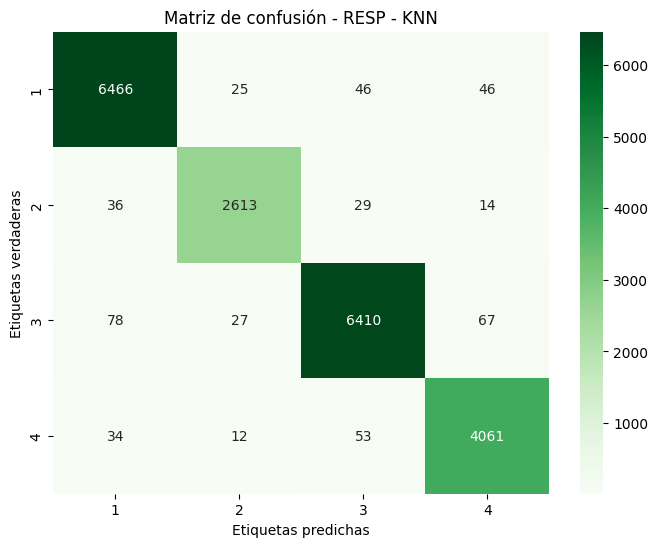

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      6583
           2       0.98      0.97      0.97      2692
           3       0.98      0.97      0.98      6582
           4       0.97      0.98      0.97      4160

    accuracy                           0.98     20017
   macro avg       0.98      0.98      0.98     20017
weighted avg       0.98      0.98      0.98     20017



Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOSO...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.454064  ALL - DecisionTree
1  Precision  0.475188  ALL - DecisionTree
2     Recall  0.454064  ALL - DecisionTree
3   F1 Score  0.453421  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_split': 2}
[ALL - DecisionTree] Accuracy: 0.4541
ALL - DecisionTree - Confusion Matrix
[[2399 1299 1615 1270]
 [ 478  990  771  453]
 [ 714  782 4033 1053]
 [ 488  417 1588 1667]]


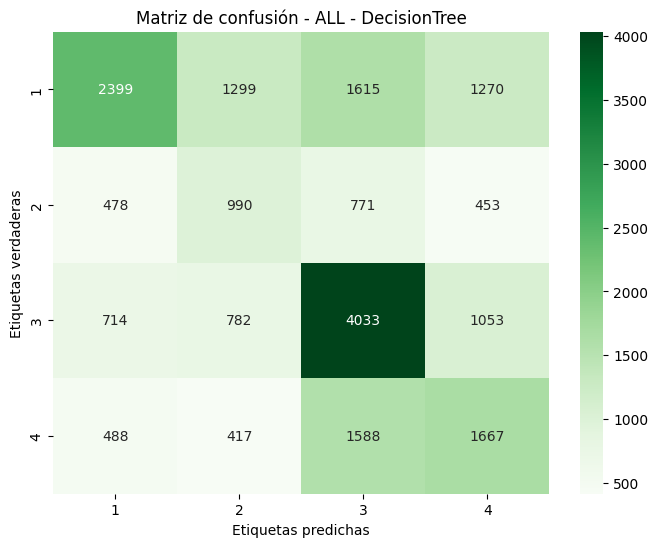

Training with ALL signals:  20%|██        | 1/5 [00:30<02:03, 30.80s/it]

              precision    recall  f1-score   support

           1       0.59      0.36      0.45      6583
           2       0.28      0.37      0.32      2692
           3       0.50      0.61      0.55      6582
           4       0.38      0.40      0.39      4160

    accuracy                           0.45     20017
   macro avg       0.44      0.44      0.43     20017
weighted avg       0.48      0.45      0.45     20017

Training RandomForest model for ALL signals using LOSO...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
ALL - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.991807  ALL - RandomForest
1  Precision  0.991833  ALL - RandomForest
2     Recall  0.991807  ALL - RandomForest
3   F1 Score  0.991806  ALL - RandomForest
[ALL - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[ALL - RandomForest] Accuracy: 0.9918
ALL - RandomForest - Confusion Matrix
[[6547    2   28    6]
 [  1

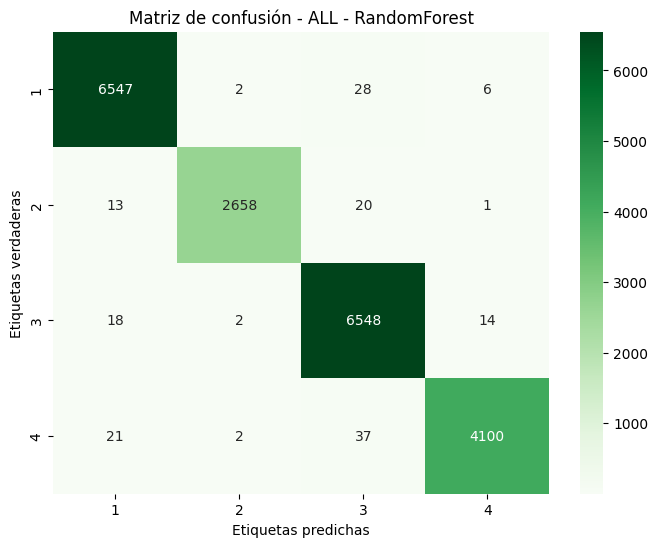

Training with ALL signals:  40%|████      | 2/5 [15:54<27:48, 556.00s/it]

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      6583
           2       1.00      0.99      0.99      2692
           3       0.99      0.99      0.99      6582
           4       0.99      0.99      0.99      4160

    accuracy                           0.99     20017
   macro avg       0.99      0.99      0.99     20017
weighted avg       0.99      0.99      0.99     20017

Training AdaBoost model for ALL signals using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ALL - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.676475  ALL - AdaBoost
1  Precision  0.680425  ALL - AdaBoost
2     Recall  0.676475  ALL - AdaBoost
3   F1 Score  0.672559  ALL - AdaBoost
[ALL - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[ALL - AdaBoost] Accuracy: 0.6765
ALL - AdaBoost - Confusion Matrix
[[4961  192 1043  387]
 [ 641 1481  445

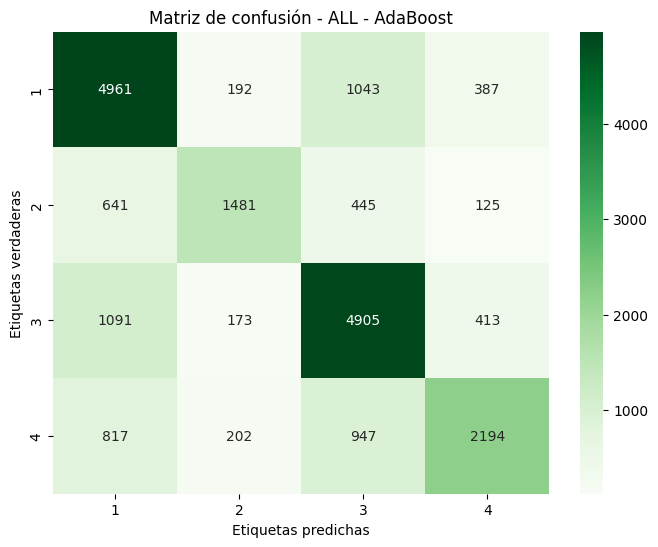

Training with ALL signals:  60%|██████    | 3/5 [28:25<21:30, 645.01s/it]

              precision    recall  f1-score   support

           1       0.66      0.75      0.70      6583
           2       0.72      0.55      0.62      2692
           3       0.67      0.75      0.70      6582
           4       0.70      0.53      0.60      4160

    accuracy                           0.68     20017
   macro avg       0.69      0.64      0.66     20017
weighted avg       0.68      0.68      0.67     20017

Training LDA model for ALL signals using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ALL - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.438477  ALL - LDA
1  Precision  0.496975  ALL - LDA
2     Recall  0.438477  ALL - LDA
3   F1 Score  0.363873  ALL - LDA
[ALL - LDA] Best Params: {'solver': 'svd'}
[ALL - LDA] Accuracy: 0.4385
ALL - LDA - Confusion Matrix
[[4372    0 2051  160]
 [1782    0  837   73]
 [2222    0 4222  138]
 [2495    0 1482  183]]


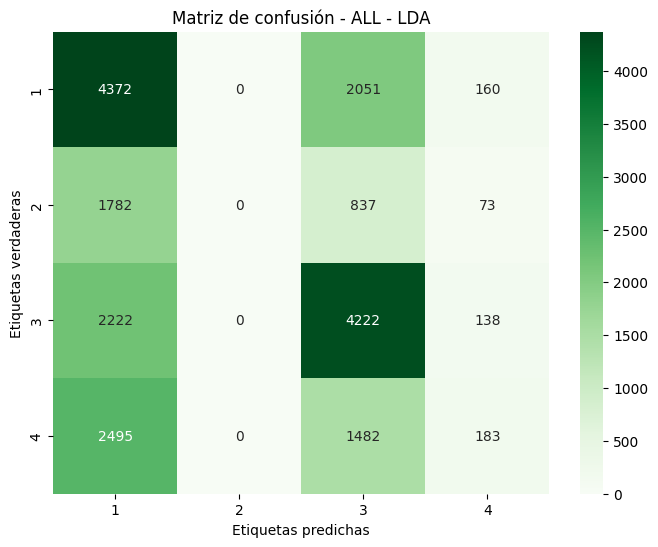

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training with ALL signals

              precision    recall  f1-score   support

           1       0.40      0.66      0.50      6583
           2       0.00      0.00      0.00      2692
           3       0.49      0.64      0.56      6582
           4       0.33      0.04      0.08      4160

    accuracy                           0.44     20017
   macro avg       0.31      0.34      0.28     20017
weighted avg       0.36      0.44      0.36     20017

Training KNN model for ALL signals using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ALL - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.976670  ALL - KNN
1  Precision  0.976686  ALL - KNN
2     Recall  0.976670  ALL - KNN
3   F1 Score  0.976669  ALL - KNN
[ALL - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[ALL - KNN] Accuracy: 0.9767
ALL - KNN - Confusion Matrix
[[6466   25   46   46]
 [  36 2613   29   14]
 [  78   27 6410   67]
 [  34   12   53 4061]]


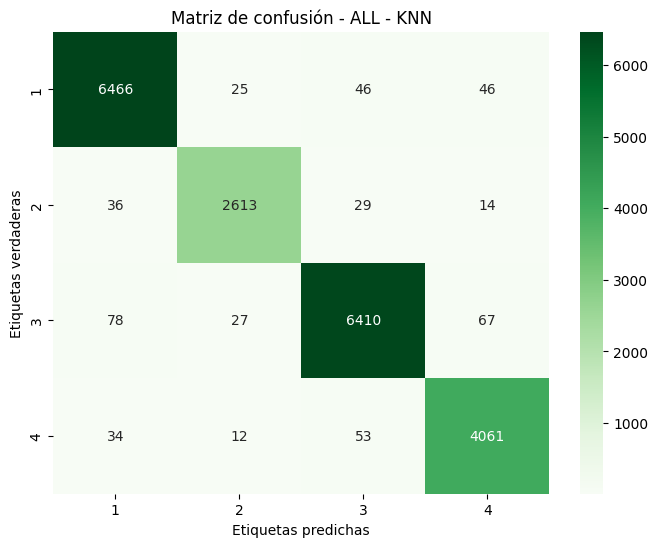

Training with ALL signals: 100%|██████████| 5/5 [28:28<00:00, 341.70s/it]

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      6583
           2       0.98      0.97      0.97      2692
           3       0.98      0.97      0.98      6582
           4       0.97      0.98      0.97      4160

    accuracy                           0.98     20017
   macro avg       0.98      0.98      0.98     20017
weighted avg       0.98      0.98      0.98     20017


Final Comparison:
ECG - DecisionTree:      Métrica     Valor               Etapa
0   Accuracy  0.426637  ECG - DecisionTree
1  Precision  0.524099  ECG - DecisionTree
2     Recall  0.426637  ECG - DecisionTree
3   F1 Score  0.356113  ECG - DecisionTree
ECG - RandomForest:      Métrica     Valor               Etapa
0   Accuracy  0.942499  ECG - RandomForest
1  Precision  0.943431  ECG - RandomForest
2     Recall  0.942499  ECG - RandomForest
3   F1 Score  0.942231  ECG - RandomForest
ECG - AdaBoost:      Métrica     Valor           Etapa
0   Accuracy  0.58615

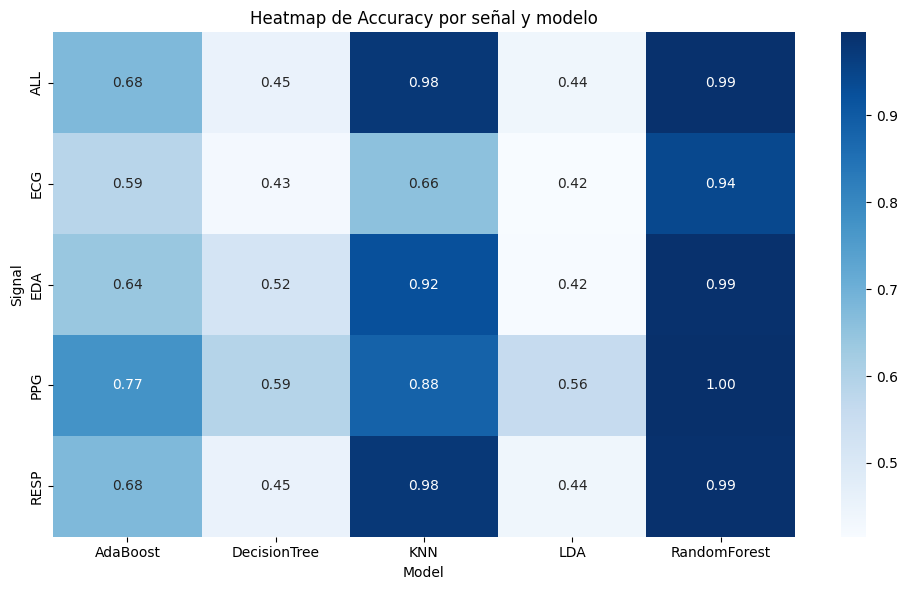

In [ ]:
"""# Entrenamiento por cada tipo de señal
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features]
        y = df['label']
        subjects = df['subject']  # Se agrega el identificador de sujetos para LOSO
        
        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal}...')
            metrics = train_and_evaluate(X, y, model, param_grid, model_name, signal)
            results[(signal, model_name)] = metrics

# Entrenamiento con todas las señales combinadas
X_all = df.drop(columns=['label', 'subject'])  # También se excluye 'subject'
y_all = df['label']
subjects_all = df['subject']

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOSO...')
    acc = train_and_evaluate(X, y, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = acc

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}: {acc}')

rows = []

for (signal, model), df_metrics in results.items():
    # Convertimos el DataFrame a formato entendible
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo')
plt.tight_layout()
plt.show()"""

In [ ]:
print(terminado)

In [ ]:
import pandas as pd

data = [
    ["ECG", "DecisionTree", "Accuracy", 0.426637],
    ["ECG", "DecisionTree", "Precision", 0.524099],
    ["ECG", "DecisionTree", "Recall", 0.426637],
    ["ECG", "DecisionTree", "F1 Score", 0.356113],
    
    ["ECG", "RandomForest", "Accuracy", 0.942499],
    ["ECG", "RandomForest", "Precision", 0.943431],
    ["ECG", "RandomForest", "Recall", 0.942499],
    ["ECG", "RandomForest", "F1 Score", 0.942231],
    
    ["ECG", "AdaBoost", "Accuracy", 0.586152],
    ["ECG", "AdaBoost", "Precision", 0.581555],
    ["ECG", "AdaBoost", "Recall", 0.586152],
    ["ECG", "AdaBoost", "F1 Score", 0.580388],
    
    ["ECG", "LDA", "Accuracy", 0.415197],
    ["ECG", "LDA", "Precision", 0.417248],
    ["ECG", "LDA", "Recall", 0.415197],
    ["ECG", "LDA", "F1 Score", 0.358256],
    
    ["ECG", "KNN", "Accuracy", 0.657541],
    ["ECG", "KNN", "Precision", 0.655851],
    ["ECG", "KNN", "Recall", 0.657541],
    ["ECG", "KNN", "F1 Score", 0.655284],
    
    ["PPG", "DecisionTree", "Accuracy", 0.589749],
    ["PPG", "DecisionTree", "Precision", 0.657386],
    ["PPG", "DecisionTree", "Recall", 0.589749],
    ["PPG", "DecisionTree", "F1 Score", 0.611145],
    
    ["PPG", "RandomForest", "Accuracy", 0.995204],
    ["PPG", "RandomForest", "Precision", 0.995213],
    ["PPG", "RandomForest", "Recall", 0.995204],
    ["PPG", "RandomForest", "F1 Score", 0.995199],
    
    ["PPG", "AdaBoost", "Accuracy", 0.774192],
    ["PPG", "AdaBoost", "Precision", 0.775871],
    ["PPG", "AdaBoost", "Recall", 0.774192],
    ["PPG", "AdaBoost", "F1 Score", 0.774591],
    
    ["PPG", "LDA", "Accuracy", 0.561573],
    ["PPG", "LDA", "Precision", 0.519806],
    ["PPG", "LDA", "Recall", 0.561573],
    ["PPG", "LDA", "F1 Score", 0.508671],
    
    ["PPG", "KNN", "Accuracy", 0.882949],
    ["PPG", "KNN", "Precision", 0.882701],
    ["PPG", "KNN", "Recall", 0.882949],
    ["PPG", "KNN", "F1 Score", 0.882814],
    
    ["EDA", "DecisionTree", "Accuracy", 0.518559],
    ["EDA", "DecisionTree", "Precision", 0.592203],
    ["EDA", "DecisionTree", "Recall", 0.518559],
    ["EDA", "DecisionTree", "F1 Score", 0.531905],
    
    ["EDA", "RandomForest", "Accuracy", 0.992656],
    ["EDA", "RandomForest", "Precision", 0.992669],
    ["EDA", "RandomForest", "Recall", 0.992656],
    ["EDA", "RandomForest", "F1 Score", 0.992653],
    
    ["EDA", "AdaBoost", "Accuracy", 0.640605],
    ["EDA", "AdaBoost", "Precision", 0.660503],
    ["EDA", "AdaBoost", "Recall", 0.640605],
    ["EDA", "AdaBoost", "F1 Score", 0.646235],
    
    ["EDA", "LDA", "Accuracy", 0.417995],
    ["EDA", "LDA", "Precision", 0.417615],
    ["EDA", "LDA", "Recall", 0.417995],
    ["EDA", "LDA", "F1 Score", 0.350615],
    
    ["EDA", "KNN", "Accuracy", 0.923115],
    ["EDA", "KNN", "Precision", 0.923083],
    ["EDA", "KNN", "Recall", 0.923115],
    ["EDA", "KNN", "F1 Score", 0.923096],
    
    ["RESP", "DecisionTree", "Accuracy", 0.454064],
    ["RESP", "DecisionTree", "Precision", 0.475188],
    ["RESP", "DecisionTree", "Recall", 0.454064],
    ["RESP", "DecisionTree", "F1 Score", 0.453421],
    
    ["RESP", "RandomForest", "Accuracy", 0.991807],
    ["RESP", "RandomForest", "Precision", 0.991833],
    ["RESP", "RandomForest", "Recall", 0.991807],
    ["RESP", "RandomForest", "F1 Score", 0.991806],
    
    ["RESP", "AdaBoost", "Accuracy", 0.676475],
    ["RESP", "AdaBoost", "Precision", 0.680425],
    ["RESP", "AdaBoost", "Recall", 0.676475],
    ["RESP", "AdaBoost", "F1 Score", 0.672559],
    
    ["RESP", "LDA", "Accuracy", 0.438477],
    ["RESP", "LDA", "Precision", 0.496975],
    ["RESP", "LDA", "Recall", 0.438477],
    ["RESP", "LDA", "F1 Score", 0.363873],
    
    ["RESP", "KNN", "Accuracy", 0.976670],
    ["RESP", "KNN", "Precision", 0.976686],
    ["RESP", "KNN", "Recall", 0.976670],
    ["RESP", "KNN", "F1 Score", 0.976669],
    
    ["ALL", "DecisionTree", "Accuracy", 0.454064],
    ["ALL", "DecisionTree", "Precision", 0.475188],
    ["ALL", "DecisionTree", "Recall", 0.454064],
    ["ALL", "DecisionTree", "F1 Score", 0.453421],
    
    ["ALL", "RandomForest", "Accuracy", 0.991807],
    ["ALL", "RandomForest", "Precision", 0.991833],
    ["ALL", "RandomForest", "Recall", 0.991807],
    ["ALL", "RandomForest", "F1 Score", 0.991806],
    
    ["ALL", "AdaBoost", "Accuracy", 0.676475],
    ["ALL", "AdaBoost", "Precision", 0.680425],
    ["ALL", "AdaBoost", "Recall", 0.676475],
    ["ALL", "AdaBoost", "F1 Score", 0.672559],
    
    ["ALL", "LDA", "Accuracy", 0.438477],
    ["ALL", "LDA", "Precision", 0.496975],
    ["ALL", "LDA", "Recall", 0.438477],
    ["ALL", "LDA", "F1 Score", 0.363873],
    
    ["ALL", "KNN", "Accuracy", 0.976670],
    ["ALL", "KNN", "Precision", 0.976686],
    ["ALL", "KNN", "Recall", 0.976670],
    ["ALL", "KNN", "F1 Score", 0.976669],
]

df = pd.DataFrame(data, columns=["Señal", "Modelo", "Métrica", "Valor"])

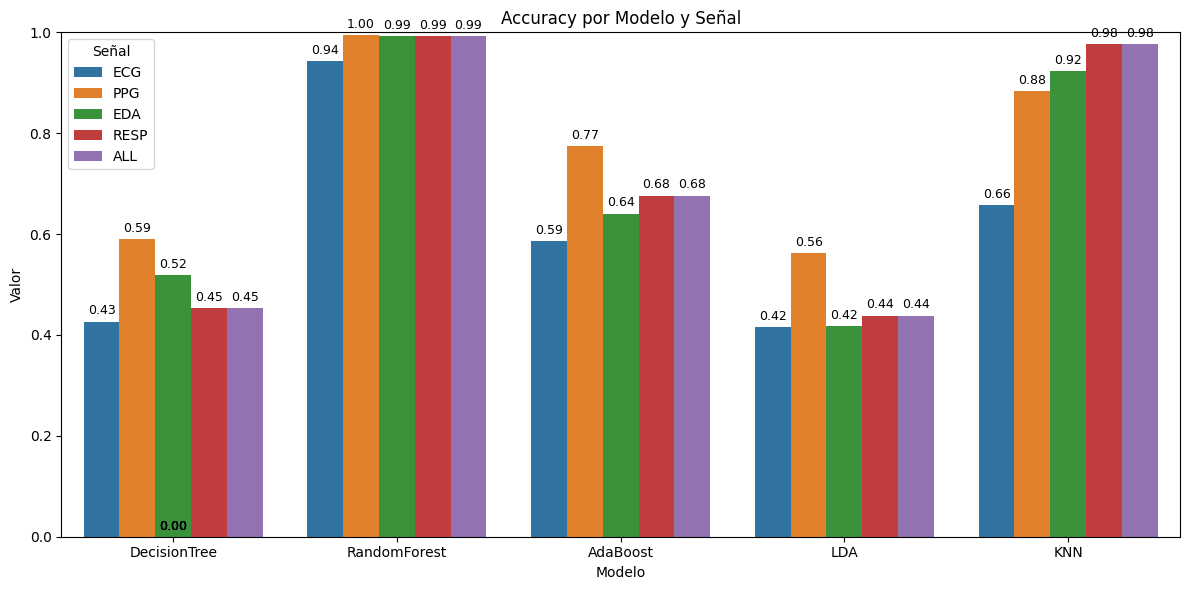

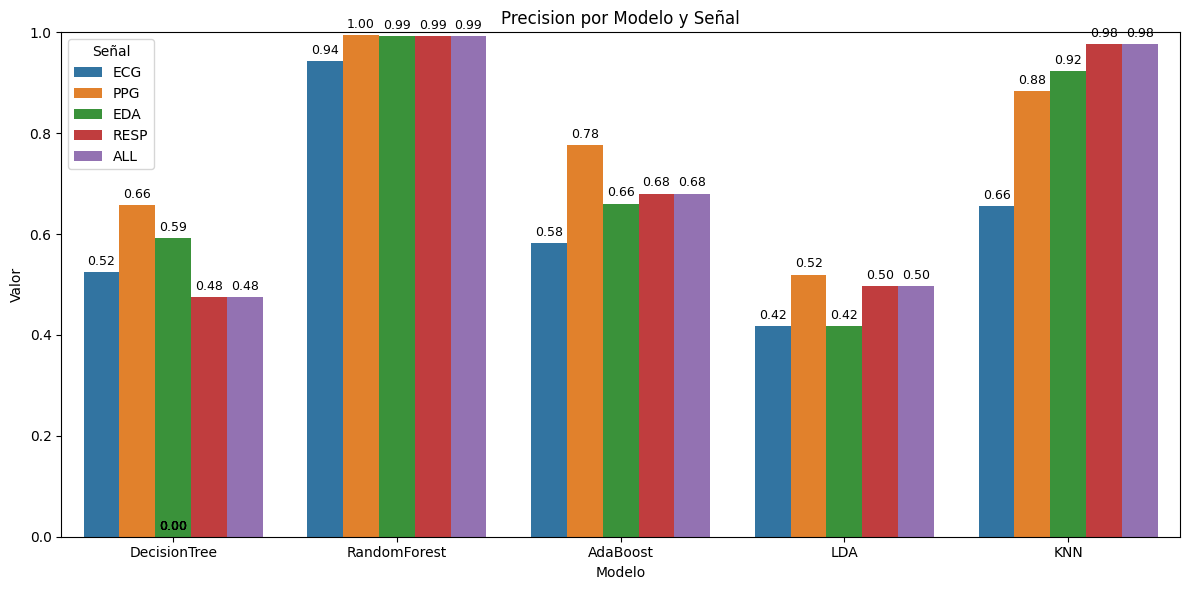

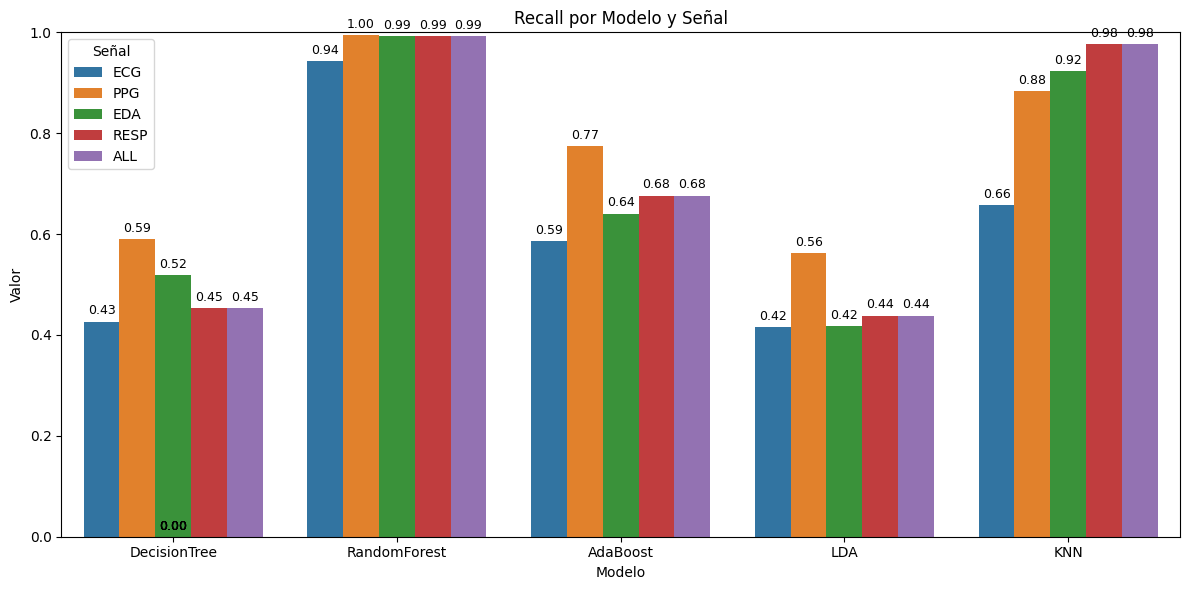

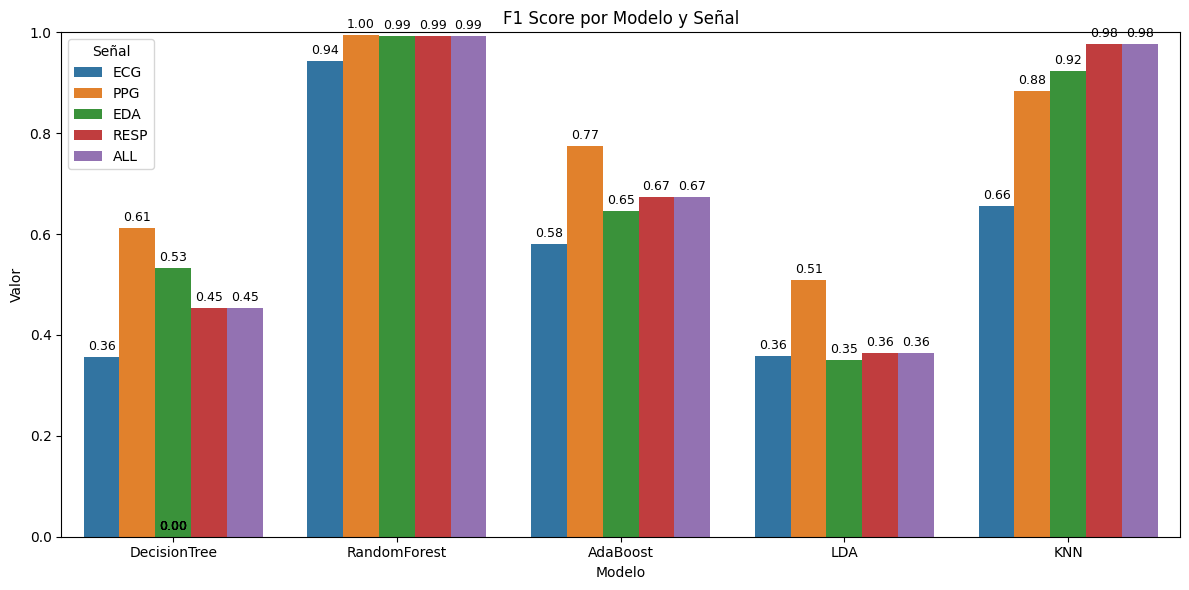

In [ ]:
metricas = df["Métrica"].unique()

# Una figura por métrica
for metrica in metricas:
    plt.figure(figsize=(12, 6))
    data_metrica = df[df["Métrica"] == metrica]
    ax = sns.barplot(data=data_metrica, x="Modelo", y="Valor", hue="Señal")
    
    plt.title(f"{metrica} por Modelo y Señal")
    plt.ylim(0, 1)
    plt.legend(title="Señal")
    plt.tight_layout()

    # Añadir los valores encima de las barras
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax.annotate(f'{height:.2f}', 
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        fontsize=9, color='black', xytext=(0, 3),
                        textcoords='offset points')

    plt.show()

*RANDOM FOREST*

In [ ]:
param_gridrRD = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

randomfor_model = RandomForestClassifier(random_state=random)

print("Sin balanceo")
train_and_evaluate(randomfor_model, param_gridrRD, X_train, y_train, X_test, y_test)

Sin balanceo


NameError: name 'X_train' is not defined

*ADA BOOST*

In [ ]:
param_gridADA = {
    'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 58],
    'estimator__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
}

base_estimator = DecisionTreeClassifier(random_state=random)
adaboost_model = AdaBoostClassifier(estimator=base_estimator, random_state=random)

train_and_evaluate(adaboost_model, param_gridADA, X_train, y_train, X_test, y_test)

*KNN*

In [ ]:
param_gridKNN = {
    'n_neighbors': [2, 3, 4, 5, 8, 10, 12, 15, 18, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree']
}

knn_model = KNeighborsClassifier()

train_and_evaluate(knn_model, param_gridKNN, X_train, y_train, X_test, y_test)

*DECISION TREE*

In [ ]:
param_gridDT = {
    'criterion': ['gini', 'entropy'],  # Función para medir la calidad de una división
    'max_depth': [None, 3, 5, 10, 20],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 8],  # Muestras mínimas en una hoja
    'max_features': ['sqrt', 'log2', None]  # Número de características a considerar en cada división
}

decision_tree_model = DecisionTreeClassifier(random_state=random)

train_and_evaluate(decision_tree_model, param_gridDT, X_train, y_train, X_test, y_test)

*LDA*

In [ ]:
param_gridLDA = {
    'solver': ['lsqr', 'eigen'],  # Excluye 'svd'
    'shrinkage': ['auto', 0.1, 0.5, 1.0]  # Compatible con 'lsqr' y 'eigen'
}

lda_model = LinearDiscriminantAnalysis()

train_and_evaluate(lda_model, param_gridLDA, X_train, y_train, X_test, y_test)